# Предисловие

Согласно опросу «инФОМ» от декабря 2021 года, у 27 % россиян хватает денег только на еду, а ещё 9 % не могут позволить себе полноценное питание. Эти люди особенно внимательно следят за ценами, а темп роста цен на продукты обычно превышает средний темп инфляции. При этом Росстат считает, что расходы на продукты питания должны составлять примерно 36 % от среднемесячных расходов россиянина (ещё около 10 % приходится на услуги ЖКХ и жильё, 4 % — на лекарства). До 2021 года «черта бедности» (жизнь на сумму ниже прожиточного минимума) в России определялась стоимостью минимальной продуктовой корзины. В том же году правительство «отвязало» уровень бедности от цен на базовые продукты: с 2021 года прожиточный минимум рассчитывается как 44.2 % от медианного дохода граждан РФ за прошлый год.

В вашем распоряжении есть данные о доходах, заболеваемости, социально незащищённых слоях населения России и другие экономические и демографические данные.

### Имеющиеся таблицы

* child_mortality_rural_1990_2023.xls — число умерших на первом году жизни детей за год, по всем регионам, в сельской местности.
* child_mortality_urban_1990_2023.xls — число умерших на первом году жизни детей за год, по всем регионам, в городской местности.
* disabled_total_by_age_2017_2022.csv — число людей с инвалидностью по регионам, по месяцам, по возрастным группам.
* morbidity_2005_2020_age_disease.xls — заболеваемость на 100 тыс. человек населения, по возрастным группам и группам заболеваний.(по факту только до 2016)
* poverty_percent_by_regions_1992_2020.csv — процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам.
* welfare_expense_share_2015_2020 — расходы на социальную политику от общих расходов бюджета региона, % в год*.
* cash_real_income_wages_2015_2020 — среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная зарплата, по регионам*.
* poverty_socdem_20*.xls — распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2022 гг., по регионам.
* housing_2020 — характеристика жилищных условий домохозяйств. Оценка домохозяйствами состояния занимаемого ими жилого помещения, обследование 2020 года*.
* population.xlsx — численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2024 гг.
* gross_regional_product_1996_2020.xls — валовой региональный продукт на душу населения, в рублях.
* regional_production_*_*.csv — объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг).
* retail_turnover_per_capita_2000_2023.xls — оборот розничной торговли на душу населения, в рублях.
* newborn_2006_2022_monthly.csv — рождённые в этом месяце, по регионам, без учёта мертворождённых.

### Цели

* кластеризовать регионы России и определить, какие из них наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения
* описать группы населения, сталкивающиеся с бедностью;
* определить:
    * влияет ли число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе;
    * связаны ли уровень бедности/социального неблагополучия с производством и потреблением в регионе;
    * какие ещё зависимости можно наблюдать относительно социально незащищённых слоёв населения

### Этапы работы над проектом

* #### Разведываетльный анализ данных
    * Обработка от пропусков и предобработка
    * Модели временных рядов и заполнение данных до 24-го года включительно
    * Построение основных таблиц, проектирование признаков
    * Статистические тесты
* #### Моделирование
    * Выбор модели
    * Кластеризация и описание классов
* #### Подготовка к продакшену
    * вывод графиков на сайт, где по выбору года будет подтягиваться нужный график
### Возможная доработка
* можно обработать сведения о преступлениях, сведения о заболеваемости алкоголизмом и наркоманией
* ещё есть мысль чтобы пользователь вводил любые данные и ему выдавался вариант к какому кластеру относится данный регион, например является ли регион с такими показателями экономически неблагополучным
* можно разделить регионы на большее количество кластеров и выделить кластер регионов с повышенным риском оказаться среди неблагополучных

In [327]:

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
import seaborn as sns
sns.set(style='whitegrid')
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import decomposition
import plotly.graph_objs as go
from sklearn import metrics
from sklearn import manifold
from clustergram import Clustergram

from tqdm import tqdm
import geopandas as gpd
import shapely
from shapely.ops import snap, unary_union
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import Point

from warnings import filterwarnings
filterwarnings("ignore")

# 1. EDA

вначале создадим словарь с таблицами, куда будем добавлять данные за каждый год наблюдений и предсказанные данные по временным рядам.

In [328]:
# создаем словарь в котором будут храниться все таблицы за каждый год, начиная с 2017
list_result = [i for i in range(2017,2025)]
dict_result = {}
for name in list_result:
    dict_result['df_'+str(name)] = pd.DataFrame()

## 1. Обработка от пропусков и остальная предобработка

### 1. число умерших на первом году жизни детей за год, по всем регионам, в сельской местности

In [329]:
df = pd.read_excel('data/child_mortality_rural_1990_2023.xlsx')
df.head()

Unnamed: 0     1990     1991     1992    1993    1994    1995   
0  Российская Федерация  11186.0  10943.0  10111.0  9840.0  9010.0  8582.0  \
1  Белгородская область    103.0     92.0     75.0    79.0    80.0    72.0   
2      Брянская область    124.0    109.0     83.0   121.0    99.0   104.0   
3  Владимирская область     80.0     58.0     60.0    62.0    46.0    50.0   
4   Воронежская область    138.0    179.0    156.0   149.0   154.0   137.0   

     1996    1997    1998  ...    2014    2015    2016    2017    2018   
0  7983.0  7701.0  7214.0  ...  4681.0  4165.0  3568.0  3032.0  2521.0  \
1    72.0    67.0    61.0  ...    41.0    42.0    36.0    34.0    33.0   
2    96.0    67.0    75.0  ...    39.0    44.0    36.0    31.0    12.0   
3    47.0    38.0    39.0  ...    23.0    31.0    28.0    17.0    22.0   
4   133.0   132.0   125.0  ...    33.0    25.0    24.0    18.0    22.0   

     2019    2020    2021    2022    2023  
0  2122.0  1916.0  1852.0  1636.0  1420.0  
1    16.0    22.0    20.0    15.0    11.0  
2    11.0    12.0    13.0    17.0    15.0  
3    15.0    10.0    14.0    10.0     8.0  
4     7.0    12.0    10.0    18.0    19.0  

[5 rows x 35 columns]

In [330]:
# настраиваем индексы, транспонируем, чтобы годы были индексами
df.set_index('Unnamed: 0', inplace=True)
df = df.T

In [331]:
# проверяем на пропуски
na = df.isnull().sum()
na[na>0]

Unnamed: 0
Город Москва                                                          15
Город Санкт-Петербург                                                 16
Республика Крым                                                       25
Город Севастополь                                                     25
Чеченская Республика                                                   3
Коми-Пермяцкий округ, входящий в состав Пермского края                15
Ханты-Мансийский автономный округ                                      3
Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)    13
Эвенкийский автономный округ (Красноярский край)                      13
Усть-Ордынский Бурятский округ                                        13
Агинский Бурятский округ (Забайкальский край)                         13
Камчатский край                                                        1
Корякский округ, входящий в состав Камчатского края                   13
dtype: int64

Большинство пропусков в регионах впоследствии присоединенных к другим регионам, или наоборот отделившиеся. В этих регионах заменим пропуски нулями. С остальными работаем.

In [332]:
# список на удаление
list_drop = ['Российская Федерация',
             'Коми-Пермяцкий округ, входящий в состав Пермского края',
             'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
             'Эвенкийский автономный округ (Красноярский край)',
             'Усть-Ордынский Бурятский округ',
             'Агинский Бурятский округ (Забайкальский край)',
             'Корякский округ, входящий в состав Камчатского края'
]

In [333]:
#Крым и Севастополь были присоединены в 2014 году, поэтому отсчет начинается с 2015, здесь значения заменим цифрами из 2015
df['Республика Крым'].fillna(method='bfill', inplace=True)
df['Город Севастополь'].fillna(method='bfill', inplace=True)

# Ханты-Мансийский автономный округ - пропуски после 2020, заменим пропуски на значение 2020
df['Ханты-Мансийский автономный округ'].fillna(method='ffill', inplace=True)

# Камчатский край аналогично на 2022
df['Камчатский край'].fillna(method='ffill', inplace=True)

# Москва и Санкт-Петербург города с отсутствием сельской местности - заменяем на 0
# в Чеченской республике в более ранние и более поздние годы 0
# и регионы из списка на удаление заменим на 0
df.fillna(0, inplace=True)

In [334]:
# преобразуем в правильные на данный момент данные
df['Пермский край'] = df['Пермский край'] + df['Коми-Пермяцкий округ, входящий в состав Пермского края']
df['Тюменская область'] = df['Тюменская область'] - df['Ханты-Мансийский автономный округ'] - df['Ямало-Ненецкий автономный округ']
df['Красноярский край'] = df['Красноярский край'] + df['Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)'] + df['Эвенкийский автономный округ (Красноярский край)']
df['Иркутская область'] = df['Иркутская область'] + df['Усть-Ордынский Бурятский округ']
df['Забайкальский край'] = df['Забайкальский край'] + df['Агинский Бурятский округ (Забайкальский край)']
df['Камчатский край'] = df['Камчатский край'] + df['Корякский округ, входящий в состав Камчатского края']
df['Архангельская область'] = df['Архангельская область'] - df['Ненецкий автономный округ']
df.drop(list_drop, axis=1, inplace=True)

In [335]:
# проверяем на пропуски
df.isnull().sum().sum()

0

In [336]:
# устанавливаем индексы в формате даты
df.index = pd.to_datetime(df.index)

In [337]:
# список названий регионов
list_region = ['Белгородская область', 'Брянская область', 'Владимирская область','Воронежская область',
          'Ивановская область', 'Калужская область', 'Костромская область', 'Курская область',
          'Липецкая область', 'Московская область', 'Орловская область', 'Рязанская область',
          'Смоленская область', 'Тамбовская область', 'Тверская область', 'Тульская область',
          'Ярославская область', 'Город Москва', 'Республика Карелия', 'Республика Коми',
          'Архангельская область', 'Ненецкий автономный округ', 'Вологодская область', 'Калининградская область',
          'Ленинградская область', 'Мурманская область', 'Новгородская область', 'Псковская область',
          'Город Санкт-Петербург', 'Республика Адыгея', 'Республика Калмыкия', 'Республика Крым',
          'Краснодарский край', 'Астраханская область', 'Волгоградская область', 'Ростовская область',
          'Город Севастополь', 'Республика Дагестан', 'Республика Ингушетия', 'Кабардино-Балкарская Республика',
          'Карачаево-Черкесская Республика', 'Республика Северная Осетия', 'Чеченская Республика','Ставропольский край',
          'Республика Башкортостан', 'Республика Марий Эл', 'Республика Мордовия', 'Республика Татарстан',
          'Удмуртская Республика', 'Чувашская Республика', 'Пермский край', 'Кировская область',
          'Нижегородская область', 'Оренбургская область', 'Пензенская область', 'Самарская область',
          'Саратовская область', 'Ульяновская область', 'Курганская область', 'Свердловская область',
          'Тюменская область', 'Ханты-Мансийский автономный округ', 'Ямало-Ненецкий автономный округ','Челябинская область',
          'Республика Алтай', 'Республика Тыва', 'Республика Хакасия', 'Алтайский край',
          'Красноярский край', 'Иркутская область', 'Кемеровская область', 'Новосибирская область',
          'Омская область', 'Томская область', 'Республика Бурятия', 'Забайкальский край',
          'Республика Саха', 'Камчатский край', 'Приморский край', 'Хабаровский край', 'Амурская область',
          'Магаданская область', 'Сахалинская область', 'Еврейская автономная область', 'Чукотский автономный округ'
]

# функция для проверки правильности написания регионов
def region_name(name):
    temp=[]
    for i in list(name):
        if i in list_region:
            continue
        else:
            temp.append(i)
    return temp

In [338]:
# проверяем названия регионов
print(region_name(df.columns))

[]


In [339]:
child_mor_rur = df.copy()

### 2. число умерших на первом году жизни детей за год, по всем регионам, в городской местности

In [340]:
df = pd.read_excel('data/child_mortality_urban_1990_2023.xlsx')

# настраиваем индексы,транспонируем, чтобы годы были индексами
df.set_index('Unnamed: 0', inplace=True)
df = df.T

In [341]:
# проверяем на пропуски
na = df.isnull().sum()
na[na>0]

Unnamed: 0
Республика Крым                                                       25
Город Севастополь                                                     25
Чеченская Республика                                                   3
Коми-Пермяцкий округ, входящий в состав Пермского края                15
Ханты-Мансийский автономный округ                                      3
Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)    13
Эвенкийский автономный округ (Красноярский край)                      13
Усть-Ордынский Бурятский округ                                        27
Агинский Бурятский округ (Забайкальский край)                         13
Камчатский край                                                        1
Корякский округ, входящий в состав Камчатского края                   13
dtype: int64

почти такая же картина как и в таблице выше, за исключением Москвы и Санкт-Петербурга

In [342]:
#Крым и Севастополь были присоединены в 2014 году, поэтому отсчет начинается с 2015, здесь значения заменим цифрами из 2015
df['Республика Крым'].fillna(method='bfill', inplace=True)
df['Город Севастополь'].fillna(method='bfill', inplace=True)

# Ханты-Мансийский автономный округ - пропуски после 2020, заменим пропуски на значение 2020
df['Ханты-Мансийский автономный округ'].fillna(method='ffill', inplace=True)

# Камчатский край аналогично на 2022
df['Камчатский край'].fillna(method='ffill', inplace=True)

# и регионы из списка на удаление заменим на 0
df.fillna(0, inplace=True)

In [343]:
# преобразуем в правильные на данный момент данные
df['Пермский край'] = df['Пермский край'] + df['Коми-Пермяцкий округ, входящий в состав Пермского края']
df['Тюменская область'] = df['Тюменская область'] - df['Ханты-Мансийский автономный округ'] - df['Ямало-Ненецкий автономный округ']
df['Красноярский край'] = df['Красноярский край'] + df['Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)'] + df['Эвенкийский автономный округ (Красноярский край)']
df['Иркутская область'] = df['Иркутская область'] + df['Усть-Ордынский Бурятский округ']
df['Забайкальский край'] = df['Забайкальский край'] + df['Агинский Бурятский округ (Забайкальский край)']
df['Камчатский край'] = df['Камчатский край'] + df['Корякский округ, входящий в состав Камчатского края']
df['Архангельская область'] = df['Архангельская область'] - df['Ненецкий автономный округ']
df.drop(list_drop, axis=1, inplace=True)

# устанавливаем индексы в формате даты
df.index = pd.to_datetime(df.index)

# проверяем названия регионов
print(region_name(df.columns))

[]


In [344]:
# проверяем на пропуски
df.isnull().sum().sum()

0

In [345]:
child_mor_urb = df.copy()

### 3. число людей с инвалидностью по регионам, по месяцам, по возрастным группам

In [346]:
df = pd.read_csv('data/disabled_total_by_age_2017_2022.csv')
df.head()

region       total     18_30     31_40      41_50   
0           Российская Федерация  11640873.0  550895.0  766054.0  1030652.0  \
1  Центральный федеральный округ   3420310.0  118579.0  172662.0   257484.0   
2           Белгородская область    223030.0    6318.0   10383.0    16596.0   
3               Брянская область    110418.0    4215.0    6568.0    10230.0   
4           Владимирская область    133352.0    4454.0    6811.0     9606.0   

       51_60        60_        date  
0  2135436.0  7157836.0  2017-01-01  
1   598102.0  2273483.0  2017-01-01  
2    37444.0   152289.0  2017-01-01  
3    21481.0    67924.0  2017-01-01  
4    23322.0    89159.0  2017-01-01

In [347]:
# удаляем по маске лишние данные
df.drop(df[df.region.str.contains('федеральный округ|г. Байконур|Российская Федерация')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)

# проверка названий регонов
set(region_name(df.region))

{'Республика Саха (Якутия)',
 'Республика Северная Осетия-Алания',
 'город Москва',
 'город Санкт-Петербург',
 'город Севастополь'}

In [348]:
# преобразуем в правильные на данный момент данные
dict_name = {'город Москва':'Город Москва',
            'город Санкт-Петербург':'Город Санкт-Петербург',
            'город Севастополь':'Город Севастополь',
            'Республика Саха (Якутия)':'Республика Саха',
            'Республика Северная Осетия-Алания':'Республика Северная Осетия'
}
df.region.replace(dict_name, inplace=True)

# проверка названий регонов
region_name(set(df.region))

[]

In [349]:
# проверяем пропуски
df.isnull().sum()

region    0
total     6
18_30     6
31_40     6
41_50     6
51_60     6
60_       6
date      0
dtype: int64

В каждом столбце пропуски

In [350]:
# смотрим строки с пропусками
df[df.isnull().any(axis=1)]

region  total  18_30  31_40  41_50  51_60  60_        date
375  Ставропольский край    NaN    NaN    NaN    NaN    NaN  NaN  2017-05-01
379   Краснодарский край    NaN    NaN    NaN    NaN    NaN  NaN  2017-05-01
407       Алтайский край    NaN    NaN    NaN    NaN    NaN  NaN  2017-05-01
412    Красноярский край    NaN    NaN    NaN    NaN    NaN  NaN  2017-05-01
416     Хабаровский край    NaN    NaN    NaN    NaN    NaN  NaN  2017-05-01
424      Приморский край    NaN    NaN    NaN    NaN    NaN  NaN  2017-05-01

Заполним средним между прошлым месяцем и будущим.

In [351]:
for i in df.columns[1:-1]:
    for j in df[df.isnull().any(axis=1)].index:
        df.at[j, i] = (abs(df.iloc[j-1][i] - df.iloc[j+1][i]))/2

Создадим новые таблицы по возрастам, данными в них будет динамика изменения количества людей с инвалидностью за год.

In [352]:
# создание новых таблиц по возрастам
disabled_18_30 = pd.DataFrame(columns=list_region, index=range(2017,2022))
disabled_31_40 = pd.DataFrame(columns=list_region, index=range(2017,2022))
disabled_41_50 = pd.DataFrame(columns=list_region, index=range(2017,2022))
disabled_51_60 = pd.DataFrame(columns=list_region, index=range(2017,2022))
disabled_61_ = pd.DataFrame(columns=list_region, index=range(2017,2022))

# заполнение таблиц
for name in list_region:
    for i in range(2017,2022):
        mask1 = (df.region==name)&(df.date==str(i)+'-01-01')
        mask2 = (df.region==name)&(df.date==str(i+1)+'-01-01')
        disabled_18_30[name].loc[i] = df[mask2]['18_30'].values[0]-df[mask1]['18_30'].values[0]
        disabled_31_40[name].loc[i] = df[mask2]['31_40'].values[0]-df[mask1]['31_40'].values[0]
        disabled_41_50[name].loc[i] = df[mask2]['41_50'].values[0]-df[mask1]['41_50'].values[0]
        disabled_51_60[name].loc[i] = df[mask2]['51_60'].values[0]-df[mask1]['51_60'].values[0]
        disabled_61_[name].loc[i] = df[mask2]['60_'].values[0]-df[mask1]['60_'].values[0]

In [353]:
# устанавливаем индексы в формате даты
disabled_18_30.index = pd.to_datetime(disabled_18_30.index, format='%Y')
disabled_31_40.index = pd.to_datetime(disabled_31_40.index, format='%Y')
disabled_41_50.index = pd.to_datetime(disabled_41_50.index, format='%Y')
disabled_51_60.index = pd.to_datetime(disabled_51_60.index, format='%Y')
disabled_61_.index = pd.to_datetime(disabled_61_.index, format='%Y')

### 4. заболеваемость на 100 тыс. человек населения, по возрастным группам и группам заболеваний

In [354]:
df = pd.read_excel('data/morbidity_2005_2020_age_disease.xlsx')

# удаляем первую строку, меняем названия будущих столбцов, устанавливаем названия столбцов, удаляются лишние пробелы
df.drop(0, axis=0, inplace=True)
df.iloc[0, 0] = 'region'
df.iloc[0, 1] = 'disease'
df.iloc[0, 2] = 'age'
df.columns = df.iloc[0].values
df = df.iloc[1:]
df.region = [i.strip() for i in df.region]

# удаляются по маске лишние данные, обновление индексов
df.drop(df[df.region.str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)

# проверка названий регионов
set(region_name(df.region))

{'Ненецкий автономный округ (Архангельская область)',
 'Республика Адыгея (Адыгея) (до 03.06.2014)',
 'Республика Саха (Якутия)',
 'Республика Северная Осетия-Алания',
 'Республика Татарстан (Татарстан)',
 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
 'Чувашская Республика - Чувашия',
 'Ямало-Ненецкий автономный округ (Тюменская область)',
 'г. Москва',
 'г. Санкт-Петербург',
 'г. Севастополь'}

In [355]:
# замена названий
dict_name = {'Ненецкий автономный округ (Архангельская область)':'Ненецкий автономный округ',
             'Республика Северная Осетия-Алания':'Республика Северная Осетия',
             'Республика Татарстан (Татарстан)':'Республика Татарстан',
             'Ханты-Мансийский автономный округ - Югра (Тюменская область)':'Ханты-Мансийский автономный округ',
             'Чувашская Республика - Чувашия':'Чувашская Республика',
             'Ямало-Ненецкий автономный округ (Тюменская область)':'Ямало-Ненецкий автономный округ',
             'Республика Саха (Якутия)':'Республика Саха',
             'г. Москва':'Город Москва',
             'г. Санкт-Петербург':'Город Санкт-Петербург',
             'г. Севастополь':'Город Севастополь',
             'Республика Адыгея (Адыгея) (до 03.06.2014)':'Республика Адыгея'
}
df.region.replace(dict_name, inplace=True)

# проверка названий регионов
print(set(region_name(df.region)))

set()


In [356]:
# в каких регионах пропуски
print(df.isna().sum())

na = df.T.isna().sum()
region_na = [df.region.iloc[i] for i in set(na[na>0].index)]
set(region_na)

region      0
disease     0
age         0
2005.0     98
2006.0     98
2007.0     98
2008.0     98
2009.0     98
2010.0     98
2011.0     98
2012.0     98
2013.0     98
2014.0      0
2015.0      0
2016.0      0
dtype: int64


{'Город Севастополь', 'Республика Крым'}

Пропуски до 2014. Заполню их средним за три года.

In [357]:
# заменяем пропуски на среднее за три года
table_na = pd.concat([df[df.region=='Город Севастополь'].loc[:, [2014, 2015, 2016]].T.mean(),
                      df[df.region=='Республика Крым'].loc[: , [2014, 2015, 2016]].T.mean()
                      ], axis=0
).round(2)

for ind in table_na.index:
    for year in range(2005, 2014):
        df.loc[ind, year] = table_na[ind]
        
print(df.isna().sum().sum())

0


Заболеваний много, предполагаю что влияние на благополучность региона имеют беременности, новообразования, врожденные аномалии(вне зависимости от возраста) и общее число заболеваний.

In [358]:
# создание таблиц
pregnancy_14 = df[(df.disease=='Беременность, роды и послеродовой период')&(df.age=='0-14 лет')].reset_index(drop=True)
pregnancy_15_17 = df[(df.disease=='Беременность, роды и послеродовой период')&(df.age=='15-17 лет')].reset_index(drop=True)
pregnancy_18_ = df[(df.disease=='Беременность, роды и послеродовой период')&(df.age=='18 лет и старше')].reset_index(drop=True)
neoplasm_14 = df[(df.disease=='Новообразования')&(df.age=='0-14 лет')].reset_index(drop=True)
neoplasm_15_17 = df[(df.disease=='Новообразования')&(df.age=='15-17 лет')].reset_index(drop=True)
neoplasm_18_ = df[(df.disease=='Новообразования')&(df.age=='18 лет и старше')].reset_index(drop=True)
all_diseases_14 = df[(df.disease=='Все заболевания')&(df.age=='0-14 лет')].reset_index(drop=True)
all_diseases_15_17 = df[(df.disease=='Все заболевания')&(df.age=='15-17 лет')].reset_index(drop=True)
all_diseases_18_ = df[(df.disease=='Все заболевания')&(df.age=='18 лет и старше')].reset_index(drop=True)
congenital_anomaly = df[df.disease=='Врожденные аномалии (пороки развития), деформации и хромосомные нарушения'].groupby('region').sum()

#удаление двух ненужных столбцов, установка индексов, тип столбцов в дату, почему-то не получается транспонирование, его отдельно
list_name = [pregnancy_14, pregnancy_15_17, pregnancy_18_,
             neoplasm_14, neoplasm_15_17, neoplasm_18_,
             all_diseases_14, all_diseases_15_17, all_diseases_18_
]
for i in list_name:
    i.drop(['disease', 'age'], axis=1, inplace=True)
    i.set_index('region', inplace=True)
    i.columns = pd.to_datetime(i.columns.astype('int'), format='%Y')
    
# транспонирование, замена пропусков
pregnancy_14 = pregnancy_14.T.replace(0.0, np.nan).fillna(method='bfill').fillna(method='ffill').fillna(0)
pregnancy_15_17 = pregnancy_15_17.T.replace(0.0, np.nan).fillna(method='bfill').fillna(method='ffill').fillna(0)
pregnancy_18_ = pregnancy_18_.T.replace(0.0, np.nan).fillna(method='bfill').fillna(method='ffill').fillna(0)
neoplasm_14 = neoplasm_14.T.replace(0.0, np.nan).fillna(method='bfill').fillna(method='ffill').fillna(0)
neoplasm_15_17 = neoplasm_15_17.T.replace(0.0, np.nan).fillna(method='bfill').fillna(method='ffill').fillna(0)
neoplasm_18_ = neoplasm_18_.T.replace(0.0, np.nan).fillna(method='bfill').fillna(method='ffill').fillna(0)
all_diseases_14 = all_diseases_14.T.replace(0.0, np.nan).fillna(method='bfill').fillna(method='ffill').fillna(0)
all_diseases_15_17 = all_diseases_15_17.T.replace(0.0, np.nan).fillna(method='bfill').fillna(method='ffill').fillna(0)
all_diseases_18_ = all_diseases_18_.T.replace(0.0, np.nan).fillna(method='bfill').fillna(method='ffill').fillna(0)

# таблица сделана другим способом, поэтому отдельно
congenital_anomaly.drop(['disease', 'age'], axis=1, inplace=True)
congenital_anomaly.columns = pd.to_datetime(congenital_anomaly.columns.astype('int'), format='%Y')
congenital_anomaly = congenital_anomaly.T

### 5. процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам

In [359]:
df = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
df.head()

region  year  poverty_percent
0  Российская Федерация  1992             33.5
1  Российская Федерация  1993             31.3
2  Российская Федерация  1994             22.4
3  Российская Федерация  1995             24.8
4  Российская Федерация  1996             22.1

In [360]:
# создаем таблицу: строки - регионы, столбцы - годы
df = df.groupby(['region', 'year']).sum().pivot_table(
    values='poverty_percent',
    index='region',
    columns='year' 
)

# создание столбца с регионами для фильтрации
df['region'] = df.index

# удаляются по маске лишние данные, обновление индексов
df.drop(df[df.region.str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)
df.region = [i.strip() for i in df.region]

# проверка названий регионов
set(region_name(df.region))

{'Архангельская область (кроме Ненецкого автономного округа)',
 'Город Москва столица Российской Федерации город федерального значения',
 'Город Санкт-Петербург город федерального значения',
 'Город федерального значения Севастополь',
 'Кемеровская область - Кузбасс',
 'Ненецкий автономный округ (Архангельская область)',
 'Республика Адыгея (Адыгея)',
 'Республика Саха (Якутия)',
 'Республика Северная Осетия-Алания',
 'Республика Татарстан (Татарстан)',
 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
 'Чувашская Республика - Чувашия',
 'Ямало-Ненецкий автономный округ (Тюменская область)'}

В дальнейшем обнаружены некоторые несоответствия регионов, поэтому возвращаемся на этот уровень и обрабатываем их: у Архангельской области без Ненецкого округа данные только с 2012 года, считаю что эту строку стоит удалить. Такая же ситуация у Тюменской области.

In [361]:
df.drop(df[df.region=='Архангельская область (кроме Ненецкого автономного округа)'].index, axis=0, inplace=True)
df.drop(df[df.region=='Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'].index, axis=0, inplace=True)
df = df.reset_index(drop=True)

# замена названий
dict_name = {'Город Москва столица Российской Федерации город федерального значения':'Город Москва',
             'Город Санкт-Петербург город федерального значения':'Город Санкт-Петербург',
             'Город федерального значения Севастополь':'Город Севастополь',
             'Кемеровская область - Кузбасс':'Кемеровская область',
             'Ненецкий автономный округ (Архангельская область)':'Ненецкий автономный округ',
             'Республика Адыгея (Адыгея)':'Республика Адыгея',
             'Республика Саха (Якутия)':'Республика Саха',
             'Республика Северная Осетия-Алания':'Республика Северная Осетия',
             'Республика Татарстан (Татарстан)':'Республика Татарстан',
             'Ханты-Мансийский автономный округ - Югра (Тюменская область)':'Ханты-Мансийский автономный округ',
             'Чувашская Республика - Чувашия':'Чувашская Республика',
             'Ямало-Ненецкий автономный округ (Тюменская область)':'Ямало-Ненецкий автономный округ',
}
df.region.replace(dict_name, inplace=True)

# проверка названий регионов
print(region_name(df.region))

[]


In [362]:
# с 1992 по 1995 данных нет ни у одного региона, удалим их
df.drop([1992, 1993, 1994], axis=1, inplace=True)
df = df.reset_index(drop=True)

# замена 0 на пустые значения
df = df.replace(0.0, np.nan)

# в каких столбцах пропуски
print(df.isna().sum())

# пропуски по регионам
na = df.T.isna().sum()
region_na = [df.region.iloc[i] for i in na[na>0].index]
region_na

year
1995      8
1996      8
1997      8
1998      8
1999      8
2000      4
2001      4
2002      3
2003      3
2004      3
2005      3
2006      3
2007      3
2008      3
2009      3
2010      3
2011      3
2012      2
2013      2
2014      2
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
region    0
dtype: int64


['Ненецкий автономный округ',
 'Ханты-Мансийский автономный округ',
 'Ямало-Ненецкий автономный округ',
 'Город Севастополь',
 'Еврейская автономная область',
 'Камчатский край',
 'Республика Крым',
 'Чеченская Республика',
 'Чукотский автономный округ']

У всех пропуски в самом начале, заполним их первым непустым значением.

In [363]:
# заполнение пропусков
df = df.T.fillna(method='bfill').T

# количество пропусков
df.isna().sum().sum()

0

In [364]:
# настраиваем индексы,транспонируем, чтобы годы были индексами
df.set_index('region', inplace=True)
df = df.T

# устанавливаем индексы в формате даты
df.index = pd.to_datetime(df.index, format='%Y')

In [365]:
poverty = df.copy()

### 6. расходы на социальную политику от общих расходов бюджета региона, % в год

In [366]:
df = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx')

In [367]:
# удаляются по маске лишние данные, обновление индексов
df.drop(df[df.region.str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)
# проверка названий регионов
set(region_name(df.region))

{'Кабардино-Балкарская\nРеспублика',
 'Карачаево-Черкесская\nРеспублика',
 'Республика Саха (Якутия)',
 'Республика Северная\nОсетия-Алания',
 'Ханты-Мансийский \nавтономный округ - Югра',
 'Ямало-Ненецкий \nавтономный округ',
 'г. Москва',
 'г. Санкт-Петербург',
 'г. Севастополь'}

In [368]:
# замена названий
dict_name = {'г. Москва':'Город Москва',
             'г. Санкт-Петербург':'Город Санкт-Петербург',
             'г. Севастополь':'Город Севастополь',
             'Кабардино-Балкарская\nРеспублика':'Кабардино-Балкарская Республика',
             'Карачаево-Черкесская\nРеспублика':'Карачаево-Черкесская Республика',
             'Республика Саха (Якутия)':'Республика Саха',
             'Республика Северная\nОсетия-Алания':'Республика Северная Осетия',
             'Ханты-Мансийский \nавтономный округ - Югра':'Ханты-Мансийский автономный округ',
             'Ямало-Ненецкий \nавтономный округ':'Ямало-Ненецкий автономный округ',
}
df.region.replace(dict_name, inplace=True)

# проверка названий регионов
print(region_name(df.region))

[]


In [369]:
# в каких столбцах пропуски
print(df.isna().sum().sum())

0


In [370]:
# настраиваем индексы,транспонируем, чтобы годы были индексами
df.set_index('region', inplace=True)
df = df.T

# устанавливаем индексы в формате даты
df.index = pd.to_datetime(df.index, format='%Y')

In [371]:
welfare = df.copy()

### 7. среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная зарплата, по регионам

In [372]:
df = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx')

In [373]:
# удаляются по маске лишние данные, обновление индексов
df.drop(df[df.region.str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)
# проверка названий регионов
set(region_name(df.region))

{'Архангельская область без\nавтономного округа',
 'Кабардино-Балкарская\nРеспублика',
 'Карачаево-Черкесская\nРеспублика',
 'Республика Саха (Якутия)',
 'Республика Северная\nОсетия-Алания',
 'Тюменская область без\nавтономных округов',
 'Ханты-Мансийский \nавтономный округ - Югра',
 'Ямало-Ненецкий \nавтономный округ',
 'в том числе:',
 'г. Москва',
 'г. Санкт-Петербург',
 'г. Севастополь'}

In [374]:
# удаляем Тюменскую и Архангельскую области, так как у нас есть данные по ним без округов
df.drop(df[df.region=='Архангельская область'].index, axis=0, inplace=True)
df.drop(df[df.region=='Тюменская область'].index, axis=0, inplace=True)
df.drop(df[df.region=='в том числе:'].index, axis=0, inplace=True)
df = df.reset_index(drop=True)

In [375]:
# замена названий
dict_name = {'г. Москва':'Город Москва',
             'г. Санкт-Петербург':'Город Санкт-Петербург',
             'г. Севастополь':'Город Севастополь',
             'Архангельская область без\nавтономного округа':'Архангельская область',
             'Тюменская область без\nавтономных округов':'Тюменская область',
             'Кабардино-Балкарская\nРеспублика':'Кабардино-Балкарская Республика',
             'Карачаево-Черкесская\nРеспублика':'Карачаево-Черкесская Республика',
             'Республика Саха (Якутия)':'Республика Саха',
             'Республика Северная\nОсетия-Алания':'Республика Северная Осетия',
             'Ханты-Мансийский \nавтономный округ - Югра':'Ханты-Мансийский автономный округ',
             'Ямало-Ненецкий \nавтономный округ':'Ямало-Ненецкий автономный округ',
}
df.region.replace(dict_name, inplace=True)

# проверка названий регионов
print(region_name(df.region))

[]


In [376]:
# в каких столбцах пропуски
print(df.isna().sum().sum())

0


In [377]:
# настраиваем индексы,транспонируем, чтобы годы были индексами
df.set_index('region', inplace=True)
df = df.T

# устанавливаем индексы в формате даты
df.index = pd.to_datetime(df.index, format='%Y')

In [378]:
income = df.copy()

### 8. распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2022 гг., по регионам

In [379]:
#загружаем данные
df_2017 = pd.read_excel('data/poverty_socdem_2017.xls')
df_2018 = pd.read_excel('data/poverty_socdem_2018.xls')
df_2019 = pd.read_excel('data/poverty_socdem_2019.xls')
df_2020 = pd.read_excel('data/poverty_socdem_2020.xls')
df_2021 = pd.read_excel('data/poverty_socdem_2021.xls')
df_2022 = pd.read_excel('data/poverty_socdem_2022.xls')
df_2017.columns

Index(['Распределение малоимущего населения по социально-демографическим группам (2017, процент, значение показателя за год)',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],
      dtype='object')

In [380]:
# переименование столбца с регионами
list_name = [df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]
for i in list_name:
    i = i.rename({i.columns[0]:'region'}, axis=1, inplace=True)

In [381]:
# проверка названий регионов
for i in list_name:
    i.iloc[0, 0] = '1'
    i.iloc[1, 0] = '2'
    i.region = [i.strip() for i in i.region] # убрали лишние пробелы
    i.drop(i[i.region.str.contains('федеральный округ|Российская Федерация')].index, inplace=True) # удаление строк по маске
    print(set(region_name(i.region))) # вывод несовпадающих наименований регионов

{'Архангельская область (без АО)', 'Город Москва столица Российской Федерации город федерального значения', 'Ханты-Мансийский автономный округ - Югра (Тюменская область)', 'Город федерального значения Севастополь', 'Город Санкт-Петербург город федерального значения', 'Республика Татарстан (Татарстан)', 'Ненецкий автономный округ (Архангельская область)', '2', '1', 'Республика Северная Осетия-Алания', 'Чувашская Республика - Чувашия', 'Ямало-Ненецкий автономный округ (Тюменская область)', 'Республика Адыгея (Адыгея)', 'Кемеровская область - Кузбасс', 'Тюменская область (без АО)', 'Республика Саха (Якутия)'}
{'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Город Москва столица Российской Федерации город федерального значения', 'Архангельская область (кроме Ненецкого автономного округа)', 'Ханты-Мансийский автономный округ - Югра (Тюменская область)', 'Город федерального значения Севастополь', 'Город Санкт-Петербург город федера

In [382]:
# замена названий
dict_name = {'Ненецкий автономный округ (Архангельская область)':'Ненецкий автономный округ',
             'Республика Северная Осетия-Алания':'Республика Северная Осетия',
             'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)':'Тюменская область (без АО)',
             'Архангельская область (кроме Ненецкого автономного округа)':'Архангельская область (без АО)',
             'Кемеровская область - Кузбасс':'Кемеровская область',
             'Республика Татарстан (Татарстан)':'Республика Татарстан',
             'Ханты-Мансийский автономный округ - Югра (Тюменская область)':'Ханты-Мансийский автономный округ',
             'Чувашская Республика - Чувашия':'Чувашская Республика',
             'Ямало-Ненецкий автономный округ (Тюменская область)':'Ямало-Ненецкий автономный округ',
             'Республика Саха (Якутия)':'Республика Саха',
             'Город Москва столица Российской Федерации город федерального значения':'Город Москва',
             'Город Санкт-Петербург город федерального значения':'Город Санкт-Петербург',
             'Город федерального значения Севастополь':'Город Севастополь',
             'Республика Адыгея (Адыгея)':'Республика Адыгея'
}

# замена названий регионов
for i in list_name:
    i.region.replace(dict_name, inplace=True)
    print(set(region_name(i.region)))

{'2', '1', 'Архангельская область (без АО)', 'Тюменская область (без АО)'}
{'2', '1', 'Архангельская область (без АО)', 'Тюменская область (без АО)'}
{'2', '1', 'Архангельская область (без АО)', 'Тюменская область (без АО)'}
{'2', '1', 'Архангельская область (без АО)', 'Тюменская область (без АО)'}
{'2', '1', 'Архангельская область (без АО)', 'Тюменская область (без АО)'}
{'2', '1', 'Архангельская область (без АО)', 'Тюменская область (без АО)'}


In [383]:
# удаление регионов и замена названий
for i in list_name:
    i.drop(i[i.region=='Архангельская область'].index, inplace=True)
    i.drop(i[i.region=='Тюменская область'].index, inplace=True)
    i.region.replace({'Тюменская область (без АО)':'Тюменская область',
                      'Архангельская область (без АО)':'Архангельская область'}, inplace=True
    )
    print(set(region_name(i.region)))

{'2', '1'}
{'2', '1'}
{'2', '1'}
{'2', '1'}
{'2', '1'}
{'2', '1'}


In [384]:
# функция для объединения таблиц вида 'регион-годы' с разделением по возрастным группам
def join_df(column):
    temp = pd.DataFrame() # пустой фрейм
    temp['region'] = df_2017.region # задаём столбец с регионами
    count = 2017 # счётчик для наименования столбцов
    list_columns = ['region', 2017] # список имён столбцов
    for i in list_name:
        temp = pd.merge(temp, i.iloc[:, [0, column]], how='left', on='region') # объединение по регионам
        temp.columns = list_columns
        count +=1
        list_columns.append(count)
    return temp[2:].reset_index(drop=True)

In [385]:
poverty_16 = join_df(2)
poverty_work = join_df(4)
poverty_old = join_df(3)

In [386]:
# пропуски
print(poverty_16[poverty_16.isnull().any(axis=1)])
print(poverty_work[poverty_work.isnull().any(axis=1)])
print(poverty_old[poverty_old.isnull().any(axis=1)])

                        region  2017  2018  2019 2020  2021  2022
0         Белгородская область  43.4  44.8     0  NaN  43.1     0
2         Владимирская область  34.8  48.9  34.8  NaN  36.2  35.8
4           Ивановская область  33.2  31.2  47.5  NaN    26     0
5            Калужская область  41.5  40.8  31.1  NaN  34.2     0
20   Ненецкий автономный округ  50.5  50.5  45.6  NaN  45.7  33.2
24       Ленинградская область  31.5    19     0  NaN  47.7     0
28       Город Санкт-Петербург  26.6  25.7     0  NaN  38.7     0
36           Город Севастополь  37.6  41.6  45.2  NaN   NaN     0
46         Республика Мордовия  35.3    38  26.8  NaN  18.8     0
81         Магаданская область  32.2  30.7  45.8  NaN    39     0
82         Сахалинская область  36.4  32.9  44.9  NaN  45.6  46.4
84  Чукотский автономный округ  46.9    51     0  NaN   NaN     0
                        region  2017  2018  2019 2020  2021  2022
0         Белгородская область  44.8  42.3     0  NaN  43.9     0
2         

In [387]:
# установка в качестве индексов названий регионов
poverty_16.set_index('region', inplace=True)
poverty_work.set_index('region', inplace=True)
poverty_old.set_index('region', inplace=True)

In [388]:
# все нулевые значения заменяем на среднее по региону за представленные годы
df = poverty_16.copy()
for i in df.index:
    df.loc[i].replace(0, df[df!=0].loc[i].mean(), inplace=True)
poverty_16 = df.copy()

df = poverty_work.copy()
for i in df.index:
    df.loc[i].replace(0, df[df!=0].loc[i].mean(), inplace=True)
poverty_work = df.copy()

df = poverty_old.copy()
for i in df.index:
    df.loc[i].replace(0, df[df!=0].loc[i].mean(), inplace=True)
poverty_old = df.copy()

Заполним пропущенные значения средними значениями по региону

In [389]:
poverty_16.loc['Белгородская область']

2017         43.4
2018         44.8
2019    43.766667
2020          NaN
2021         43.1
2022    43.766667
Name: Белгородская область, dtype: object

In [390]:
# заполняем пропуски
for i in list_region:
    poverty_16 = poverty_16.T.fillna({i:poverty_16.T[i].mean()}).T
    poverty_work = poverty_work.T.fillna({i:poverty_work.T[i].mean()}).T
    poverty_old = poverty_old.T.fillna({i:poverty_old.T[i].mean()}).T

In [391]:
# транспонируем
poverty_16 = poverty_16.T
poverty_work = poverty_work.T
poverty_old = poverty_old.T

In [392]:
# устанавливаем индексы в формате даты
poverty_16.index = pd.to_datetime(poverty_16.index, format='%Y')
poverty_work.index = pd.to_datetime(poverty_work.index, format='%Y')
poverty_old.index = pd.to_datetime(poverty_old.index, format='%Y')
print(poverty_16.isna().sum().sum())
print(poverty_work.isna().sum().sum())
print(poverty_old.isna().sum().sum())

0
0
0


In [393]:
# проверка названий регионов
print(region_name(poverty_16.columns))
print(region_name(poverty_work.columns))
print(region_name(poverty_old.columns))

[]
[]
[]


### 9. характеристика жилищных условий домохозяйств. Оценка домохозяйствами состояния занимаемого ими жилого помещения, обследование 2020 года

In [394]:
#загружаем данные
df = pd.read_excel('data/housing_2020.xlsx')

In [395]:
# удаляются по маске лишние данные, обновление индексов
df.drop(df[df['Регион'].str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)
# проверка названий регионов
set(region_name(df['Регион']))

{'Bладимирская область',
 'Bолгоградская область',
 'Bологодская область',
 'Bоронежская область',
 'Архангельская область без авт. округа',
 'Еврейская авт. область',
 'Ненецкий авт. округ',
 'Республика Саха(Якутия)',
 'Республика Северная Осетия-Алания',
 'Тюменская область без авт. округов',
 'Ханты-Мансийский авт. округ',
 'Чукотский авт. округ',
 'Ямало-Ненецкий авт. округ',
 'г. Санкт-Петербург',
 'г. Севастополь',
 'г.Москва'}

In [396]:
# замена названий
dict_name = {'Bладимирская область':'Владимирская область',
             'Bолгоградская область':'Волгоградская область',
             'Bологодская область':'Вологодская область',
             'Bоронежская область':'Воронежская область',
             'Еврейская авт. область':'Еврейская автономная область',
             'Чукотский авт. округ':'Чукотский автономный округ',
             'Ненецкий авт. округ':'Ненецкий автономный округ',
             'Республика Северная Осетия-Алания':'Республика Северная Осетия',
             'Тюменская область без авт. округов':'Тюменская область',
             'Архангельская область без авт. округа':'Архангельская область',
             'Ханты-Мансийский авт. округ':'Ханты-Мансийский автономный округ',
             'Ямало-Ненецкий авт. округ':'Ямало-Ненецкий автономный округ',
             'Республика Саха(Якутия)':'Республика Саха',
             'г.Москва':'Город Москва',
             'г. Санкт-Петербург':'Город Санкт-Петербург',
             'г. Севастополь':'Город Севастополь'
}

df['Регион'].replace(dict_name, inplace=True)

# проверка названий регионов
print(region_name(df['Регион']))

[]


In [397]:
# берем только 2 вида данных
df = df.loc[:, ['Регион', 'Размер общей площади в расчете на члена домохозяйства',
                'Размер жилой площади в расчете на члена домохозяйства']
            ]
# пропуски
df.isnull().sum().sum()

0

In [398]:
# установка индексов
df.set_index('Регион', inplace=True)

In [399]:
housing = df.copy()

### 10. численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2024 гг

In [400]:
#загружаем данные
df = pd.read_excel('data/population24.xlsx')

In [401]:
# присвоение названий столбцам
df.columns = [1, 2, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
              2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
              2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024
]

# переименование пустух мешающих значений
df.iloc[0, 0] = '1'
df.iloc[0, 1] = '2'

# удаление лишних строк и столбцов
df.drop([2], axis=1, inplace=True)
df.drop([0, 1], axis=0, inplace=True)

In [402]:
# удаляются по маске лишние данные, обновление индексов
df.drop(df[df[1].str.contains('федеральный округ|Российская Федерация|Раздел')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)
# проверка названий регионов
set(region_name(df[1]))

{'Агинский Бурятский округ (Забайкальский край)',
 'Архангельская область (кроме Ненецкого автономного округа)',
 'Город Москва столица Российской Федерации город федерального значения',
 'Город Санкт-Петербург город федерального значения',
 'Город федерального значения Севастополь',
 'Кемеровская область - Кузбасс',
 'Коми-Пермяцкий округ, входящий в состав Пермского края',
 'Корякский округ, входящий в состав Камчатского края',
 'Ненецкий автономный округ (Архангельская область)',
 'Республика Адыгея (Адыгея)',
 'Республика Саха (Якутия)',
 'Республика Северная Осетия-Алания',
 'Республика Татарстан (Татарстан)',
 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
 'Усть-Ордынский Бурятский округ',
 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
 'Чувашская Республика - Чувашия',
 'Эвенкийский автономный округ (Красноярский край)',
 'Ямало-Н

In [403]:
# замена названий
dict_name = {'Кемеровская область - Кузбасс':'Кемеровская область',
             'Республика Адыгея (Адыгея)':'Республика Адыгея',
             'Республика Татарстан (Татарстан)':'Республика Татарстан',
             'Чувашская Республика - Чувашия':'Чувашская Республика',
             'Ненецкий автономный округ (Архангельская область)':'Ненецкий автономный округ',
             'Республика Северная Осетия-Алания':'Республика Северная Осетия',
             'Ханты-Мансийский автономный округ - Югра (Тюменская область)':'Ханты-Мансийский автономный округ',
             'Ямало-Ненецкий автономный округ (Тюменская область)':'Ямало-Ненецкий автономный округ',
             'Республика Саха (Якутия)':'Республика Саха',
             'Город Москва столица Российской Федерации город федерального значения':'Город Москва',
             'Город Санкт-Петербург город федерального значения':'Город Санкт-Петербург',
             'Город федерального значения Севастополь':'Город Севастополь'
}

df[1].replace(dict_name, inplace=True)

# проверка названий регионов
print(region_name(df[1]))

['Архангельская область (кроме Ненецкого автономного округа)', 'Коми-Пермяцкий округ, входящий в состав Пермского края', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Агинский Бурятский округ (Забайкальский край)', 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)', 'Эвенкийский автономный округ (Красноярский край)', 'Усть-Ордынский Бурятский округ', 'Корякский округ, входящий в состав Камчатского края']


In [404]:
# пропуски
df[df.isnull().any(axis=1)]

1       1990    1991    1992   
22  Архангельская область (кроме Ненецкого автоном...     NaN     NaN     NaN  \
32                                    Республика Крым     NaN     NaN     NaN   
37                                  Город Севастополь     NaN     NaN     NaN   
52  Коми-Пермяцкий округ, входящий в состав Пермск...  145576  145842  146670   
65  Тюменская область (кроме Ханты-Мансийского авт...     NaN     NaN     NaN   
71      Агинский Бурятский округ (Забайкальский край)   70286   70765   71947   
73  Таймырский (Долгано-Ненецкий) автономный округ...   51867   50764   49308   
74   Эвенкийский автономный округ (Красноярский край)   24005   24290   24067   
77                     Усть-Ордынский Бурятский округ  127138  128114  129981   
85  Корякский округ, входящий в состав Камчатского...   37622   37709   37366   

      1993    1994    1995    1996    1997    1998  ...     2015     2016   
22     NaN     NaN     NaN     NaN     NaN     NaN  ...  1103821  1085277  \
32     NaN     NaN     NaN     NaN     NaN     NaN  ...  1895915  1912596   
37     NaN     NaN     NaN     NaN     NaN     NaN  ...   398973   437403   
52  147832  146730  144881  143570  142314  140580  ...      NaN      NaN   
65     NaN     NaN     NaN     NaN     NaN     NaN  ...  1447189  1477208   
71   73035   73309   72739   71932   70875   71041  ...      NaN      NaN   
73   47091   45187   42900   42137   41229   40003  ...      NaN      NaN   
74   23171   22132   20277   20034   19843   19553  ...      NaN      NaN   
77  132053  131823  131809  132552  133486  134463  ...      NaN      NaN   
85   35705   33071   31155   29881   29026   28324  ...      NaN      NaN   

       2017     2018     2019     2020     2021     2022     2023     2024  
22  1068298  1049080  1029967  1013856   995721   974604   964304   955848  
32  1922846  1929621  1932788  1938630  1931930  1931091  1916805  1909499  
37   458569   479533   499623   522366   531809   547452   558273   561374  
52      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
65  1504988  1530916  1555607  1578928  1589406  1602672  1608494  1615454  
71      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
73      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
74      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
77      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
85      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  

[10 rows x 36 columns]

In [405]:
# установка регионов в качестве индексов
df.set_index(1, inplace=True)

# транспонируем чтобы регионы стали столбцами
df = df.T

# список на удаление
list_drop = ['Агинский Бурятский округ (Забайкальский край)', 'Коми-Пермяцкий округ, входящий в состав Пермского края',
            'Корякский округ, входящий в состав Камчатского края', 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
            'Усть-Ордынский Бурятский округ', 'Эвенкийский автономный округ (Красноярский край)',
            'Архангельская область (кроме Ненецкого автономного округа)',
             'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'
]

# замена пропусков
df.loc[:2014, 'Республика Крым'] = df.loc[2015, 'Республика Крым']
df.loc[:2014, 'Город Севастополь'] = df.loc[2015, 'Город Севастополь']
df.fillna(method='ffill', axis=0, inplace=True)
df.fillna(method='bfill', axis=0, inplace=True)

In [406]:
# преобразуем в правильные на данный момент данные
df['Пермский край'] = df['Пермский край'] + df['Коми-Пермяцкий округ, входящий в состав Пермского края']
df['Тюменская область'] = df['Тюменская область'] - df['Ханты-Мансийский автономный округ'] - df['Ямало-Ненецкий автономный округ']
df['Красноярский край'] = df['Красноярский край'] + df['Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)'] + df['Эвенкийский автономный округ (Красноярский край)']
df['Иркутская область'] = df['Иркутская область'] + df['Усть-Ордынский Бурятский округ']
df['Забайкальский край'] = df['Забайкальский край'] + df['Агинский Бурятский округ (Забайкальский край)']
df['Камчатский край'] = df['Камчатский край'] + df['Корякский округ, входящий в состав Камчатского края']
df['Архангельская область'] = df['Архангельская область'] - df['Ненецкий автономный округ']
df.drop(list_drop, axis=1, inplace=True)

# устанавливаем индексы в формате даты
df.index = pd.to_datetime(df.index, format='%Y')

# проверяем названия регионов
print(region_name(df.columns))

[]


In [407]:
# пропуски
df.T[df.T.isnull().any(axis=1)]

Empty DataFrame
Columns: [1990-01-01 00:00:00, 1991-01-01 00:00:00, 1992-01-01 00:00:00, 1993-01-01 00:00:00, 1994-01-01 00:00:00, 1995-01-01 00:00:00, 1996-01-01 00:00:00, 1997-01-01 00:00:00, 1998-01-01 00:00:00, 1999-01-01 00:00:00, 2000-01-01 00:00:00, 2001-01-01 00:00:00, 2002-01-01 00:00:00, 2003-01-01 00:00:00, 2004-01-01 00:00:00, 2005-01-01 00:00:00, 2006-01-01 00:00:00, 2007-01-01 00:00:00, 2008-01-01 00:00:00, 2009-01-01 00:00:00, 2010-01-01 00:00:00, 2011-01-01 00:00:00, 2012-01-01 00:00:00, 2013-01-01 00:00:00, 2014-01-01 00:00:00, 2015-01-01 00:00:00, 2016-01-01 00:00:00, 2017-01-01 00:00:00, 2018-01-01 00:00:00, 2019-01-01 00:00:00, 2020-01-01 00:00:00, 2021-01-01 00:00:00, 2022-01-01 00:00:00, 2023-01-01 00:00:00, 2024-01-01 00:00:00]
Index: []

[0 rows x 35 columns]

In [408]:
population = df.copy()

### 11. валовой региональный продукт на душу населения, в рублях

In [409]:
# загружаем данные
df = pd.read_excel('data/gross_regional_product_1996_2020.xls')

In [410]:
# замена пустых значений, которые помешают в дальнейшем
df.iloc[0, 0] = '1'
df.iloc[1, 0] = '2'

# установка названий столбцов в целочисленном формате и удаление двух первых строк
df.columns = df.iloc[1].astype('int').values
df = df.iloc[2:]

# переименование столбца с названиями регионов
df = df.rename({df.columns[0]:'region'}, axis=1)

# очистка от лишних пробелов
df.region = [i.strip() for i in df.region]

# удаляются по маске лишние данные, обновление индексов
df.drop(df[df.region.str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)

# проверка названий регионов
set(region_name(df.region))

{'Архангельская область (кроме Ненецкого автономного округа)',
 'Город Москва столица Российской Федерации город федерального значения',
 'Город Санкт-Петербург город федерального значения',
 'Город федерального значения Севастополь',
 'Кемеровская область - Кузбасс',
 'Ненецкий автономный округ (Архангельская область)',
 'Республика Адыгея (Адыгея)',
 'Республика Саха (Якутия)',
 'Республика Северная Осетия-Алания',
 'Республика Татарстан (Татарстан)',
 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
 'Чувашская Республика - Чувашия',
 'Ямало-Ненецкий автономный округ (Тюменская область)'}

In [411]:
# замена названий
dict_name = {'Кемеровская область - Кузбасс':'Кемеровская область',
             'Республика Адыгея (Адыгея)':'Республика Адыгея',
             'Республика Татарстан (Татарстан)':'Республика Татарстан',
             'Чувашская Республика - Чувашия':'Чувашская Республика',
             'Ненецкий автономный округ (Архангельская область)':'Ненецкий автономный округ',
             'Республика Северная Осетия-Алания':'Республика Северная Осетия',
             'Ханты-Мансийский автономный округ - Югра (Тюменская область)':'Ханты-Мансийский автономный округ',
             'Ямало-Ненецкий автономный округ (Тюменская область)':'Ямало-Ненецкий автономный округ',
             'Республика Саха (Якутия)':'Республика Саха',
             'Город Москва столица Российской Федерации город федерального значения':'Город Москва',
             'Город Санкт-Петербург город федерального значения':'Город Санкт-Петербург',
             'Город федерального значения Севастополь':'Город Севастополь'
}

df.region.replace(dict_name, inplace=True)

# проверка названий регионов
print(region_name(df.region))

['Архангельская область (кроме Ненецкого автономного округа)', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)']


Так как валовой региональный продукт по округам ранее входившим в Архангельскую и Тюменскую области очень большой и оказывает сильное влияние на общий валовой продукт, значения общего валового продукта и за каждый регион очень разнятся. Поэтому удаляем столбцы с общим показателем и оставляем по каждому в отдельности, несмотря на меньшее количество данных.

In [412]:
# установка в качестве индексов названий регионов
df.set_index('region', inplace=True)
# транспонирование
df = df.T

# удаление областей и замена названий оставшихся
df.drop(['Архангельская область', 'Тюменская область'], axis=1, inplace=True)
df.rename({'Архангельская область (кроме Ненецкого автономного округа)':'Архангельская область',
           'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)':'Тюменская область'},
          axis=1, inplace = True
)

# пропуски
df.loc[df.isna().any(axis=1), df.isna().any(axis=0)]

region  Ненецкий автономный округ  Архангельская область  Республика Крым   
1996                          NaN                    NaN              NaN  \
1997                          NaN                    NaN              NaN   

region  Город Севастополь  Ханты-Мансийский автономный округ   
1996                  NaN                                NaN  \
1997                  NaN                                NaN   

region  Ямало-Ненецкий автономный округ  Тюменская область  
1996                                NaN                NaN  
1997                                NaN                NaN

In [413]:
# замена 0 на пустые значения
df = df.replace(0.0, np.nan)

# замена пропусков на первое непустое значение
df.fillna(method='bfill', axis=0, inplace=True)
# проверка пропусков
df.isna().sum().sum()

0

In [414]:
# устанавливаем индексы в формате даты
df.index = pd.to_datetime(df.index, format='%Y')

# проверяем названия регионов
print(region_name(df.columns))

[]


In [415]:
gross_product = df.copy()

### 12. объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг)

In [416]:
#загружаем данные
df1 = pd.read_csv('data/regional_production_2005_2016.csv')
df2 = pd.read_csv('data/regional_production_2017_2020.csv')

In [417]:
# очистка от пробелов
df1.region = [i.strip() for i in df1.region]
df2.region = [i.strip() for i in df2.region]

# удаляются по маске лишние данные, обновление индексов
df1.drop(df1[df1.region.str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df2.drop(df2[df2.region.str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)

# проверка названий регионов
print(set(region_name(df1.region)))
# проверка названий регионов
print(set(region_name(df2.region)))

{'Город Москва столица Российской Федерации город федерального значения', 'Архангельская область (кроме Ненецкого автономного округа)', 'Ненецкий автономный округ (Архангельская область)', 'Республика Северная Осетия-Алания', 'Эвенкийский автономный округ (Красноярский край)', 'Архангельская область (без АО)', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Московская обл. в старых границах', 'Республика Татарстан (Татарстан)', 'Ямало-Ненецкий автономный округ (Тюменская область)', 'Республика Адыгея (Адыгея)', 'Тюменская область (без АО)', 'Республика Саха (Якутия)', 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)', 'Ханты-Мансийский автономный округ - Югра (Тюменская область)', 'Город Санкт-Петербург город федерального значения', 'Коми-Пермяцкий округ, входящий в состав Пермского края', 'Москва в старых границах', 'Усть-Ордынский Бурятский округ', 'Город федерального значения Севастополь', 'Корякский окр

In [418]:
# замена названий
dict_name = {'Кемеровская область - Кузбасс':'Кемеровская область',
             'Республика Адыгея (Адыгея)':'Республика Адыгея',
             'Республика Татарстан (Татарстан)':'Республика Татарстан',
             'Чувашская Республика - Чувашия':'Чувашская Республика',
             'Ненецкий автономный округ (Архангельская область)':'Ненецкий автономный округ',
             'Республика Северная Осетия-Алания':'Республика Северная Осетия',
             'Ханты-Мансийский автономный округ - Югра (Тюменская область)':'Ханты-Мансийский автономный округ',
             'Ямало-Ненецкий автономный округ (Тюменская область)':'Ямало-Ненецкий автономный округ',
             'Республика Саха (Якутия)':'Республика Саха',
             'Город Москва столица Российской Федерации город федерального значения':'Город Москва',
             'Город Санкт-Петербург город федерального значения':'Город Санкт-Петербург',
             'Город федерального значения Севастополь':'Город Севастополь'
}

df1.region.replace(dict_name, inplace=True)
df2.region.replace(dict_name, inplace=True)

# проверка названий регионов
print(set(region_name(df1.region)))
print(set(region_name(df2.region)))

{'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)', 'Архангельская область (без АО)', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 'Московская обл. в старых границах', 'Архангельская область (кроме Ненецкого автономного округа)', 'Усть-Ордынский Бурятский округ', 'Корякский округ, входящий в состав Камчатского края', 'Коми-Пермяцкий округ, входящий в состав Пермского края', 'Москва в старых границах', 'Эвенкийский автономный округ (Красноярский край)', 'Агинский Бурятский округ (Забайкальский край)', 'Тюменская область (без АО)'}
{'Архангельская область (кроме Ненецкого автономного округа)', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'}


In [419]:
# список на удаление
list_drop = ['Агинский Бурятский округ (Забайкальский край)', 'Коми-Пермяцкий округ, входящий в состав Пермского края',
            'Корякский округ, входящий в состав Камчатского края', 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
            'Усть-Ордынский Бурятский округ', 'Эвенкийский автономный округ (Красноярский край)',
            'Архангельская область (кроме Ненецкого автономного округа)',
             'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
             'Москва в старых границах', 'Московская обл. в старых границах'
]

df1.drop(df1[df1.region.isin(list_drop)].index, axis=0, inplace=True)

# проверяем названия регионов
print(set(region_name(df1.region)))
print(set(region_name(df2.region)))

{'Архангельская область (без АО)', 'Тюменская область (без АО)'}
{'Архангельская область (кроме Ненецкого автономного округа)', 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'}


Объём товаров по округам ранее входившим в Архангельскую и Тюменскую области очень большой и оказывает сильное влияние на общий объём товаров, поэтому оставляем области без бывших округов.

In [420]:
# удаление базовых областей
df1.drop(df1[df1.region.isin(['Архангельская область', 'Тюменская область'])].index, axis=0, inplace=True)
df2.drop(df2[df2.region.isin(['Архангельская область', 'Тюменская область'])].index, axis=0, inplace=True)

# замена названий на базовые
df1.region.replace({'Архангельская область (без АО)':'Архангельская область',
           'Тюменская область (без АО)':'Тюменская область'},
           inplace = True
)
df2.region.replace({'Архангельская область (кроме Ненецкого автономного округа)':'Архангельская область',
           'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)':'Тюменская область'},
           inplace = True
)
# проверяем названия регионов
print(set(region_name(df1.region)))
print(set(region_name(df2.region)))

set()
set()


In [421]:
# количество пропусков по таблицам
print(df1.isna().sum().sum(), df2.isna().sum().sum())

90 0


In [422]:
# установка регионов в качестве индексов
df1.set_index('region', inplace=True)
df2.set_index('region', inplace=True)
# пропуски обнаружены только в первой таблице, вывод пропусков
df1.loc[df1.isna().any(axis=1), df1.isna().any(axis=0)]

2005  2006       2007       2008       2009   
region                                                               
Архангельская область   NaN   NaN        NaN        NaN        NaN  \
Архангельская область   NaN   NaN        NaN        NaN        NaN   
Архангельская область   NaN   NaN        NaN        NaN        NaN   
Республика Крым         NaN   NaN        NaN        NaN        NaN   
Республика Крым         NaN   NaN        NaN        NaN        NaN   
Республика Крым         NaN   NaN        NaN        NaN        NaN   
Город Севастополь       NaN   NaN        NaN        NaN        NaN   
Город Севастополь       NaN   NaN        NaN        NaN        NaN   
Город Севастополь       NaN   NaN        NaN        NaN        NaN   
Чеченская Республика    NaN   NaN  5462304.5  4951358.0  4152426.0   
Чеченская Республика    NaN   NaN   854813.6  1199966.6   813141.5   
Чеченская Республика    NaN   NaN  2161115.0  2909136.4  3983713.1   
Тюменская область       NaN   NaN        NaN        NaN        NaN   
Тюменская область       NaN   NaN        NaN        NaN        NaN   
Тюменская область       NaN   NaN        NaN        NaN        NaN   

                              2010          2011          2012          2013  
region                                                                        
Архангельская область    2166659.1  2.866410e+06  2.156738e+06  2.809707e+06  
Архангельская область   97211749.8  1.010991e+08  1.178609e+08  2.637913e+08  
Архангельская область   27035272.4  2.905356e+07  3.032838e+07  3.140615e+07  
Республика Крым                NaN           NaN           NaN           NaN  
Республика Крым                NaN           NaN           NaN           NaN  
Республика Крым                NaN           NaN           NaN           NaN  
Город Севастополь              NaN           NaN           NaN           NaN  
Город Севастополь              NaN           NaN           NaN           NaN  
Город Севастополь              NaN           NaN           NaN           NaN  
Чеченская Республика     4053007.0  4.404819e+06  4.290047e+06  4.909844e+06  
Чеченская Республика     4702942.8  1.645993e+06  3.065028e+06  4.473359e+06  
Чеченская Республика     4282645.1  4.585151e+06  5.303631e+06  9.764590e+06  
Тюменская область       33485956.4  5.661537e+07  8.283439e+07  1.095672e+08  
Тюменская область      521833387.0  7.000164e+08  7.732709e+08  5.932190e+08  
Тюменская область       36479279.8  4.161345e+07  4.490969e+07  5.006534e+07

In [423]:
# замена пропусков на первые непустые
df1 = df1.fillna(method='bfill', axis=1)
# количество пропусков по таблицам
print(df1.isna().sum().sum(), df2.isna().sum().sum())

0 0


In [424]:
# значения из столбца с наименованиями деятельности
df1['production_field'].value_counts()

production_field
РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ                                  85
РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА                                 85
РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭНЕРГИИ, ГАЗА И ВОДЫ    85
Name: count, dtype: int64

In [425]:
# значения из столбца с наименованиями деятельности
df2['production_field'].value_counts()

production_field
ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА                                                                                     85
ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА                                    85
Промышленное производство (промышленность)                                                                      85
ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ                                                                                      83
ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ    83
Name: count, dtype: int64

In [426]:
# замена названий деятельности первой таблицы на названия из второй
df1.replace({'РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ':'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ',
             'РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА':'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА',
             'РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭНЕРГИИ, ГАЗА И ВОДЫ':'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА'},
            inplace=True
)
# составление новых таблиц по видам деятельности
list_prod = ['ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ', 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА',
             'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА'
]
extraction = pd.merge(df1[df1.production_field==list_prod[0]].iloc[:, 1:], df2[df2.production_field==list_prod[0]].iloc[:, 1:], how='left', on='region')
production = pd.merge(df1[df1.production_field==list_prod[1]].iloc[:, 1:], df2[df2.production_field==list_prod[1]].iloc[:, 1:], how='left', on='region')
electricity = pd.merge(df1[df1.production_field==list_prod[2]].iloc[:, 1:], df2[df2.production_field==list_prod[2]].iloc[:, 1:], how='left', on='region')
# пропуски
print(extraction.loc[extraction.isna().any(axis=1), extraction.isna().any(axis=0)])
print(production.loc[production.isna().any(axis=1), production.isna().any(axis=0)])
print(electricity.loc[electricity.isna().any(axis=1), electricity.isna().any(axis=0)])

                     2017  2018  2019  2020
region                                     
Республика Калмыкия   NaN   NaN   NaN   NaN
Город Севастополь     NaN   NaN   NaN   NaN
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


Пропуски обнаружены только в первой таблице, причиной пропусков является то что добыча полезных ископаемых для данных регионов во второй таблице не указана, заменим пропуски на последнее непустое значение.

In [427]:
# транспонируем чтобы регионы стали столбцами
extraction = extraction.T
production = production.T
electricity = electricity.T

# заполнение пропусков
extraction.fillna(method='ffill', axis=0, inplace=True)

# устанавливаем индексы в формате даты
extraction.index = pd.to_datetime(extraction.index, format='%Y')
production.index = pd.to_datetime(production.index, format='%Y')
electricity.index = pd.to_datetime(electricity.index, format='%Y')

# проверяем названия регионов
print(region_name(extraction.columns))
print(region_name(production.columns))
print(region_name(electricity.columns))

[]
[]
[]


### 13. оборот розничной торговли на душу населения, в рублях

In [428]:
#загружаем данные
df = pd.read_excel('data/retail_turnover_per_capita_2000_2023.xls')

In [429]:
# замена пустых значений, которые помешают в дальнейшем
df.iloc[1, 0] = '1'
df.iloc[1, 1] = '2'

# установка названий столбцов в целочисленном формате и удаление двух первых строк
df.columns = df.iloc[1].values.astype('int')
df = df.iloc[3:]

# переименование столбца с названиями регионов
df = df.rename({df.columns[0]:'region'}, axis=1)

# очистка от лишних пробелов
df.region = [i.strip() for i in df.region]

# удаление столбца с видом валюты
df.drop(2, axis=1, inplace=True)

# удаляются по маске лишние данные, обновление индексов
df.drop(df[df.region.str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)

# проверка названий регионов
set(region_name(df.region))

{'Агинский Бурятский округ (Забайкальский край)',
 'Архангельская область (без АО)',
 'Архангельская область (кроме Ненецкого автономного округа)',
 'Город Москва столица Российской Федерации город федерального значения',
 'Город Санкт-Петербург город федерального значения',
 'Город федерального значения Севастополь',
 'Кемеровская область - Кузбасс',
 'Коми-Пермяцкий округ, входящий в состав Пермского края',
 'Корякский округ, входящий в состав Камчатского края',
 'Ненецкий автономный округ (Архангельская область)',
 'Республика Адыгея (Адыгея)',
 'Республика Саха (Якутия)',
 'Республика Северная Осетия-Алания',
 'Республика Татарстан (Татарстан)',
 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
 'Тюменская область (без АО)',
 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
 'Усть-Ордынский Бурятский округ',
 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
 'Чувашская Республика - Чуваши

In [430]:
# замена названий
dict_name = {'Кемеровская область - Кузбасс':'Кемеровская область',
             'Республика Адыгея (Адыгея)':'Республика Адыгея',
             'Республика Татарстан (Татарстан)':'Республика Татарстан',
             'Чувашская Республика - Чувашия':'Чувашская Республика',
             'Ненецкий автономный округ (Архангельская область)':'Ненецкий автономный округ',
             'Республика Северная Осетия-Алания':'Республика Северная Осетия',
             'Ханты-Мансийский автономный округ - Югра (Тюменская область)':'Ханты-Мансийский автономный округ',
             'Ямало-Ненецкий автономный округ (Тюменская область)':'Ямало-Ненецкий автономный округ',
             'Республика Саха (Якутия)':'Республика Саха',
             'Город Москва столица Российской Федерации город федерального значения':'Город Москва',
             'Город Санкт-Петербург город федерального значения':'Город Санкт-Петербург',
             'Город федерального значения Севастополь':'Город Севастополь'
}

df.region.replace(dict_name, inplace=True)

# проверка названий регионов
set(region_name(df.region))

{'Агинский Бурятский округ (Забайкальский край)',
 'Архангельская область (без АО)',
 'Архангельская область (кроме Ненецкого автономного округа)',
 'Коми-Пермяцкий округ, входящий в состав Пермского края',
 'Корякский округ, входящий в состав Камчатского края',
 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
 'Тюменская область (без АО)',
 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
 'Усть-Ордынский Бурятский округ',
 'Эвенкийский автономный округ (Красноярский край)'}

Разница в цифрах между Архангельской областью и Архангельской областью без Ненецкого округа в пределах 500 рублей, так как данных по Архангельской области не в пример больше оставляем её как основную. Между Тюменской обалстью и Тюменской областью без округов разница более значительна, в качестве основной останется Тюменская область без округов.

In [431]:
# список на удаление
list_drop = ['Агинский Бурятский округ (Забайкальский край)', 'Коми-Пермяцкий округ, входящий в состав Пермского края',
            'Корякский округ, входящий в состав Камчатского края', 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
            'Усть-Ордынский Бурятский округ', 'Эвенкийский автономный округ (Красноярский край)',
            'Архангельская область (кроме Ненецкого автономного округа)', 'Тюменская область',
            'Архангельская область (без АО)', 'Тюменская область (без АО)'
]

df.drop(df[df.region.isin(list_drop)].index, axis=0, inplace=True)

# проверяем названия регионов
set(region_name(df.region))

{'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'}

In [432]:
# замена названия Тюменской области
df.region.replace({'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)':'Тюменская область'} ,
           inplace = True
)
# проверяем названия регионов
set(region_name(df.region))

set()

In [433]:
# количество пропусков
df.isna().sum().sum()

22

In [434]:
# установка регионов в качестве индексов
df.set_index('region', inplace=True)
# вывод пропусков
df.loc[df.isna().any(axis=1), df.isna().any(axis=0)]

2000  2001  2002  2003  2004  2005  2006  2007  2008  2009   
region                                                                          
Республика Крым     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  \
Город Севастополь   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                   2010  
region                   
Республика Крым     NaN  
Город Севастополь   NaN

In [435]:
# заменяем все 0 на пустые значения
df = df.replace(0.0, np.nan)

# замена пропусков на первые непустые
df = df.fillna(method='bfill', axis=1)

# количество пропусков
df.isna().sum().sum()

0

In [436]:
# транспонируем чтобы регионы стали столбцами
df = df.T
# устанавливаем индексы в формате даты
df.index = pd.to_datetime(df.index, format='%Y')

# проверяем названия регионов
print(region_name(df.columns))

[]


In [437]:
retail = df.copy()

### 14.  рождённые в этом месяце, по регионам, без учёта мертворождённых

In [438]:
#загружаем данные
df = pd.read_csv('data/newborn_2006_2022_monthly.csv', sep=';')

In [439]:
# последний стоблец не нужен
df = df.iloc[:, :-1]

# установка названий столбцов
df.columns = [i[-7:-3] for i in df.columns]

# очистка от лишних пробелов
df.Reg = [i.strip() for i in df.Reg]
# удаляются по маске лишние данные, обновление индексов
df.drop(df[df.Reg.str.contains('федеральный округ|Российская Федерация')].index, axis=0, inplace=True)
df = df.reset_index(drop=True)

# проверка названий регионов
set(region_name(df.Reg))

{'Агинский Бурятский округ (Забайкальский край)',
 'Архангельская область (кроме Ненецкого автономного округа)',
 'Город Москва столица Российской Федерации город федерального значения',
 'Город Санкт-Петербург город федерального значения',
 'Город федерального значения Севастополь',
 'Кемеровская область - Кузбасс',
 'Коми-Пермяцкий округ, входящий в состав Пермского края',
 'Корякский округ, входящий в состав Камчатского края',
 'Москва в старых границах',
 'Московская обл. в старых границах',
 'Ненецкий автономный округ (Архангельская область)',
 'Республика Адыгея (Адыгея)',
 'Республика Саха (Якутия)',
 'Республика Северная Осетия-Алания',
 'Республика Татарстан (Татарстан)',
 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
 'Усть-Ордынский Бурятский округ',
 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
 'Чувашская Республика - Чуваш

In [440]:
# замена названий
dict_name = {'Кемеровская область - Кузбасс':'Кемеровская область',
             'Республика Адыгея (Адыгея)':'Республика Адыгея',
             'Республика Татарстан (Татарстан)':'Республика Татарстан',
             'Чувашская Республика - Чувашия':'Чувашская Республика',
             'Ненецкий автономный округ (Архангельская область)':'Ненецкий автономный округ',
             'Республика Северная Осетия-Алания':'Республика Северная Осетия',
             'Ханты-Мансийский автономный округ - Югра (Тюменская область)':'Ханты-Мансийский автономный округ',
             'Ямало-Ненецкий автономный округ (Тюменская область)':'Ямало-Ненецкий автономный округ',
             'Республика Саха (Якутия)':'Республика Саха',
             'Город Москва столица Российской Федерации город федерального значения':'Город Москва',
             'Город Санкт-Петербург город федерального значения':'Город Санкт-Петербург',
             'Город федерального значения Севастополь':'Город Севастополь'
}

df.Reg.replace(dict_name, inplace=True)

# проверка названий регионов
set(region_name(df.Reg))

{'Агинский Бурятский округ (Забайкальский край)',
 'Архангельская область (кроме Ненецкого автономного округа)',
 'Коми-Пермяцкий округ, входящий в состав Пермского края',
 'Корякский округ, входящий в состав Камчатского края',
 'Москва в старых границах',
 'Московская обл. в старых границах',
 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
 'Усть-Ордынский Бурятский округ',
 'Эвенкийский автономный округ (Красноярский край)'}

In [441]:
# список на удаление
list_drop = ['Агинский Бурятский округ (Забайкальский край)', 'Коми-Пермяцкий округ, входящий в состав Пермского края',
            'Корякский округ, входящий в состав Камчатского края', 'Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)',
            'Усть-Ордынский Бурятский округ', 'Эвенкийский автономный округ (Красноярский край)',
            'Москва в старых границах', 'Московская обл. в старых границах',
            'Архангельская область (кроме Ненецкого автономного округа)',
            'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'
]

df.drop(df[df.Reg.isin(list_drop)].index, axis=0, inplace=True)

# проверяем названия регионов
set(region_name(df.Reg))

set()

In [442]:
# установка регионов в качестве индексов
df.set_index('Reg', inplace=True)

# транспонируем чтобы регионы стали столбцами
df = df.T

# пропуски
df.loc[df.isna().any(axis=1), df.isna().any(axis=0)]

Reg  Республика Крым Город Севастополь
2006             NaN               NaN
2006             NaN               NaN
2006             NaN               NaN
2006             NaN               NaN
2006             NaN               NaN
...              ...               ...
2014             NaN               NaN
2014             NaN               NaN
2014             NaN               NaN
2014             NaN               NaN
2014             NaN               NaN

[108 rows x 2 columns]

In [443]:
# замена пропусков на 0
df.fillna(0, inplace=True)

# замена , на . в данных
df.replace(',', '.', regex=True, inplace=True)

# изменение типа данных и округление
df = df.astype('float').round()

# расчёт правильных показателей
df['Тюменская область'] = df['Тюменская область'] - df['Ханты-Мансийский автономный округ'] - df['Ямало-Ненецкий автономный округ']
df['Архангельская область'] = df['Архангельская область'] - df['Ненецкий автономный округ']

# суммируем чтобы была сумма за год
df = df.groupby(df.index).sum()

# убираем 2022 потому что он неполный
df = df[:-1]

# заполняем пропуски, которые ранее заполнили 0
df.loc[:'2014', 'Республика Крым'] = df['Республика Крым'].loc['2015']
df.loc[:'2014', 'Город Севастополь'] = df['Город Севастополь'].loc['2015']

# устанавливаем индексы в формате даты
df.index = pd.to_datetime(df.index, format='%Y')

# проверяем названия регионов
print(region_name(df.columns))

[]


In [444]:
newborn = df.copy()

## 2. Модели временных рядов и заполнение данных до 24-го года включительно

In [445]:
import pmdarima as pm
import datetime

In [446]:
# функция для расчета количества взятия разности(d)
def def_adfuller(col, name):
    try:
        if adfuller(col.dropna())[0]>adfuller(col.dropna())[4]['1%']:
            return 1 + def_adfuller(col.diff(), name)
        else:
            return 0
    except ValueError:
        print(name+'_ad')
        return 0

In [447]:
# функция для добавления информации о стационарности для построения временных рядов
def auto_pred(df):
    data = df.copy()
    list_error = []
    l = data.shape[0]
    list_pred = list(range(data.index[-1].year+1, 2025))
    list_pred = pd.to_datetime(list_pred, format='%Y')
    for i in list_pred:
        data.loc[i] = 0
    for i in data.columns:
        model = pm.auto_arima(
            data.iloc[:l][i],
            start_p=1,
            d=def_adfuller(data.iloc[:l][i], i),
            start_q=1,
            max_p=3,
            max_q=3
        )
        for year in list_pred:
            try:
                if model.predict().loc[year]>=0:
                    data.loc[year, i] = model.predict().loc[year].round()
                else:
                    data.loc[year, i] = 0
            except ValueError:
                list_error.append(i)
    return data, list(set(list_error))

In [448]:
# функция для расчета предсказаний до 2024 с подбором параметра "d"
def auto_pred_d(df):
    data = df.copy()
    list_error = []
    l = data.shape[0]
    list_pred = list(range(data.index[-1].year+1, 2025))
    list_pred = pd.to_datetime(list_pred, format='%Y')
    for i in list_pred:
        data.loc[i] = 0
    for i in data.columns:
        model = pm.auto_arima(
            data.iloc[:l][i],
            start_p=1,
            start_d=0,
            start_q=1,
            max_p=15,
            max_q=15,
            max_d=10,
            test="adf"
        )
        for year in list_pred:
            try:
                if model.predict().loc[year]>=0:
                    data.loc[year, i] = model.predict().loc[year].round()
                else:
                    data.loc[year, i] = 0
            except ValueError:
                list_error.append(i)
    return data, list(set(list_error))

### 1. число умерших на первом году жизни детей за год, по всем регионам, в сельской местности

In [449]:
# добавляем предсказания
child_mor_rur, lst = auto_pred(child_mor_rur)

Город Санкт-Петербург_ad


Здесь и далее я просматривала таблицы с результатами и в зависимости от параметра корректировала слишком неправдоподобные. В данном случае, если параметр изменился более чем на 90%, оставались данные за 2023 год

In [450]:
for i in child_mor_rur.columns:
        if (abs(child_mor_rur.loc['2023-01-01', i]-child_mor_rur.loc['2024-01-01', i])/child_mor_rur.loc['2023-01-01', i])>=0.9:
            child_mor_rur.loc['2024-01-01', i] = child_mor_rur.loc['2023-01-01', i]
        else:
            continue

### 2. число умерших на первом году жизни детей за год, по всем регионам, в городской местности

In [451]:
child_mor_urb, lst = auto_pred(child_mor_urb)

In [452]:
for i in child_mor_urb.columns:
        if (abs(child_mor_urb.loc['2023-01-01', i]-child_mor_urb.loc['2024-01-01', i])/child_mor_urb.loc['2023-01-01', i])>=0.9:
            child_mor_urb.loc['2024-01-01', i] = child_mor_urb.loc['2023-01-01', i]
        else:
            continue

### 3. число людей с инвалидностью по регионам, по месяцам, по возрастным группам

В качестве данных у меня выступает изменение количества людей с инвалидностью в зависимости от года. Наблюдейний очень мало, временные ряды по ним построить не удастся, поэтому заполним последним значением

In [453]:
list_df = [disabled_18_30, disabled_31_40, disabled_41_50, disabled_51_60, disabled_61_]

list_index = pd.to_datetime(['2022', '2023', '2024'], format='%Y')
for i in list_df:
    for j in list_index:
        i.loc[j] = i.loc['2021-01-01']

### 4. заболеваемость на 100 тыс. человек населения, по возрастным группам и группам заболеваний

такая же ситуация как и в предыдущем пункте, решаем так же - данные за последний год

In [454]:
list_df = [pregnancy_14, pregnancy_15_17, pregnancy_18_,
           neoplasm_14, neoplasm_15_17, neoplasm_18_,
           all_diseases_14, all_diseases_15_17, all_diseases_18_,
           congenital_anomaly
]

list_index = pd.to_datetime(['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024'], format='%Y')
for i in list_df:
    for j in list_index:
        i.loc[j] = i.loc['2016-01-01']

### 5. процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам

по некоторым регионам решения временных рядов странные, пока не буду с этим разбираться, просто где слишком большие расхождения заменим на 2020 или близкий прогноз 2021.

In [455]:
poverty, lst = auto_pred(poverty)

In [456]:
for i in poverty.columns:
    if abs(poverty.loc['2020-01-01', i]-poverty.loc['2024-01-01', i])>=4:
        if abs(poverty.loc['2020-01-01', i]-poverty.loc['2021-01-01', i])>=1.5:
            poverty.loc['2021-01-01':, i] = poverty.loc['2020-01-01', i]
        else:
            poverty.loc['2022-01-01':, i] = poverty.loc['2021-01-01', i]
    else:
        continue

### 6. расходы на социальную политику от общих расходов бюджета региона, % в год

Наблюдений очень мало, временные ряды по ним построить неудастся, поэтому заполним последним значением

In [457]:
list_index = pd.to_datetime(['2021', '2022', '2023', '2024'], format='%Y')
for i in list_index:
    welfare.loc[i] = welfare.loc['2020-01-01']

### 7. среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная зарплата, по регионам

Наблюдений очень мало, временные ряды по ним построить неудастся, поэтому заполним последним значением

In [458]:
list_index = pd.to_datetime(['2021', '2022', '2023', '2024'], format='%Y')
for i in list_index:
    income.loc[i] = income.loc['2020-01-01']

### 8. распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся, пенсионеры) за 2017–2022 гг., по регионам

Наблюдейний очень мало, тест Дики-Фуллера выдаёт много ошибок, временные ряды по ним построить неудастся, поэтому заполним последним значением

In [459]:
list_df = [poverty_16, poverty_work, poverty_old]

list_index = pd.to_datetime(['2023', '2024'], format='%Y')
for i in list_df:
    for j in list_index:
        i.loc[j] = i.loc['2022-01-01']

### 9. характеристика жилищных условий домохозяйств. Оценка домохозяйствами состояния занимаемого ими жилого помещения, обследование 2020 года

в наличии только 1 год, распространим его

### 10. численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2024 гг

все данные есть

### 11. валовой региональный продукт на душу населения, в рублях

здесь берем функцию с подбором параметра d, потому что с помощью предыдущей функции получались очень большие параметры и на них результаты модели были nan

In [460]:
gross_product, lst = auto_pred_d(gross_product)

In [461]:
# регионы где с 2021 до 2024 года показатели изменились более чем на 70%
gross_product.T[abs(gross_product.T['2020-01-01']-gross_product.T['2024-01-01'])/gross_product.T['2020-01-01']>0.7]

1996-01-01  1997-01-01  1998-01-01   
region                                                                  
Республика Коми                       16999.7     21659.7     26798.7  \
Ненецкий автономный округ           3913588.7   3913588.7   3913588.7   
Мурманская область                    15833.2     18427.8     23233.5   
Республика Крым                      100526.4    100526.4    100526.4   
Город Севастополь                     78009.3     78009.3     78009.3   
Ханты-Мансийский автономный округ   1575300.0   1575300.0   1575300.0   
Тюменская область                    522064.8    522064.8    522064.8   
Томская область                       15713.5     17516.7     19078.5   
Магаданская область                   26438.6     30770.0     32315.5   
Чукотский автономный округ            30606.1     33540.9     37859.4   

                                   1999-01-01  2000-01-01  2001-01-01   
region                                                                  
Республика Коми                       41025.0     56619.5     75534.6  \
Ненецкий автономный округ           3913588.7   3913588.7   3913588.7   
Мурманская область                    43012.3     59157.8     62965.4   
Республика Крым                      100526.4    100526.4    100526.4   
Город Севастополь                     78009.3     78009.3     78009.3   
Ханты-Мансийский автономный округ   1575300.0   1575300.0   1575300.0   
Тюменская область                    522064.8    522064.8    522064.8   
Томская область                       25149.2     38386.0     54221.6   
Магаданская область                   50936.4     65704.6     89987.5   
Чукотский автономный округ            49746.0     65963.0    123130.9   

                                   2002-01-01  2003-01-01  2004-01-01   
region                                                                  
Республика Коми                       84101.9    106304.1    132733.1  \
Ненецкий автономный округ           3913588.7   3913588.7   3913588.7   
Мурманская область                    76236.9     91442.1    144469.3   
Республика Крым                      100526.4    100526.4    100526.4   
Город Севастополь                     78009.3     78009.3     78009.3   
Ханты-Мансийский автономный округ   1575300.0   1575300.0   1575300.0   
Тюменская область                    522064.8    522064.8    522064.8   
Томская область                       72107.4     93193.8    128090.8   
Магаданская область                  121272.5    135180.6    139840.3   
Чукотский автономный округ           187368.1    256992.1    238227.2   

                                   2005-01-01  ...  2015-01-01  2016-01-01   
region                                         ...                           
Республика Коми                      176075.2  ...    613975.0    677818.8  \
Ненецкий автономный округ           3913588.7  ...   5210143.9   5964557.0   
Мурманская область                   156652.5  ...    525475.7    614565.5   
Республика Крым                      100526.4  ...    139873.3    189916.6   
Город Севастополь                     78009.3  ...    119384.5    211366.0   
Ханты-Мансийский автономный округ   1575300.0  ...   1947653.2   1912836.6   
Тюменская область                    522064.8  ...    628098.5    659860.8   
Томская область                      155365.2  ...    438316.5    483420.8   
Магаданская область                  157798.9  ...    854561.5   1054274.8   
Чукотский автономный округ           237134.5  ...   1226152.0   1443771.7   

                                   2017-01-01  2018-01-01  2019-01-01   
region                                                                  
Республика Коми                      719599.3    833270.1    873159.0  \
Ненецкий автономный округ           6045235.6   7296374.4   7530484.7   
Мурманская область                   634409.5    693988.6    828365.9   
Республика Крым                      201251.2    228692.9    245411.7   
Город Севастополь            

In [462]:
gross_product.loc['2024-01-01', ['Магаданская область', 'Чукотский автономный округ']] = gross_product.loc['2023-01-01', ['Магаданская область', 'Чукотский автономный округ']]

gross_product.loc['2022-01-01', ['Республика Крым', 'Город Севастополь']] = gross_product.loc['2021-01-01', ['Республика Крым', 'Город Севастополь']]
gross_product.loc['2023-01-01', ['Республика Крым', 'Город Севастополь']] = gross_product.loc['2021-01-01', ['Республика Крым', 'Город Севастополь']]
gross_product.loc['2024-01-01', ['Республика Крым', 'Город Севастополь']] = gross_product.loc['2021-01-01', ['Республика Крым', 'Город Севастополь']]

for i in gross_product.loc['2021-01-01':].index:
    gross_product.loc[i, 'Республика Коми'] = gross_product.loc['2020-01-01', 'Республика Коми']
    gross_product.loc[i, 'Ханты-Мансийский автономный округ'] = gross_product.loc['2020-01-01', 'Ханты-Мансийский автономный округ']
    gross_product.loc[i, 'Томская область'] = gross_product.loc['2020-01-01', 'Томская область']
    gross_product.loc[i, 'Ненецкий автономный округ'] = gross_product.loc['2020-01-01', 'Ненецкий автономный округ']
    gross_product.loc[i, 'Тюменская область'] = gross_product.loc['2020-01-01', 'Тюменская область']
    gross_product.loc[i, 'Томская область'] = gross_product.loc['2020-01-01', 'Томская область']

### 12. объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг)

После проведения исследования на тему более удачной функции для построения временных рядов результаты получилисьь следующие: ошибок в первой функции(без автоподбора d) почти в 2 раза меньше(11 и 20) и улетающих вврех или вниз графиков так же намного меньше(4 и 13), работаем с построением временных рядов без автоподбора d.

In [463]:
extraction, lst = auto_pred(extraction)

Город Севастополь_ad


In [464]:
# заполнение с 2021 включительно данными из 2020, если значение 2024 равно 0
for i in extraction.loc['2021-01-01':].index:
    extraction.loc[i, extraction.T[extraction.T['2024-01-01']==0].index] = extraction.loc['2020-01-01', extraction.T[extraction.T['2024-01-01']==0].index]

In [465]:
production, lst = auto_pred(production)

Ростовская область_ad


In [466]:
# заполнение с 2021 включительно данными из 2020, если значение 2024 равно 0
for i in production.loc['2021-01-01':].index:
    production.loc[i, production.T[production.T['2024-01-01']==0].index] = production.loc['2020-01-01', production.T[production.T['2024-01-01']==0].index]

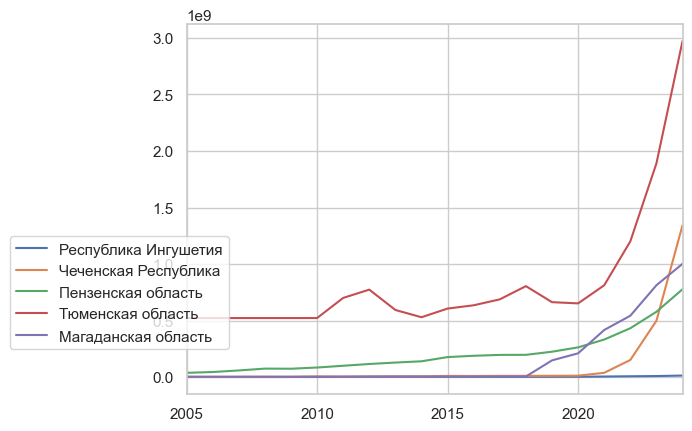

In [467]:
# график регионов в которых изменения с 2020 по 2024 более или равны 100%
production.T[abs(production.T['2020-01-01']-production.T['2024-01-01'])/production.T['2020-01-01']>=1].T.plot().legend(bbox_to_anchor=(0.1, 0.1))

In [468]:
# регионы в которых изменения с 2020 по 2024 более или равны 100%
production.T[abs(production.T['2020-01-01']-production.T['2024-01-01'])/production.T['2020-01-01']>=1]

2005-01-01    2006-01-01    2007-01-01    2008-01-01   
region                                                                         
Республика Ингушетия  1.893407e+05  3.281533e+05  3.455484e+05  3.338282e+05  \
Чеченская Республика  8.548136e+05  8.548136e+05  8.548136e+05  1.199967e+06   
Пензенская область    3.720189e+07  4.419191e+07  5.830804e+07  7.442271e+07   
Тюменская область     5.218334e+08  5.218334e+08  5.218334e+08  5.218334e+08   
Магаданская область   2.747545e+06  2.517751e+06  2.656177e+06  2.884345e+06   

                        2009-01-01   2010-01-01   2011-01-01    2012-01-01   
region                                                                       
Республика Ингушетия  4.013133e+05     454633.5    1093731.3  2.594191e+06  \
Чеченская Республика  8.131415e+05    4702942.8    1645992.8  3.065028e+06   
Пензенская область    7.348983e+07   84150111.1   99662894.2  1.153791e+08   
Тюменская область     5.218334e+08  521833387.0  700016444.3  7.732709e+08   
Магаданская область   2.796219e+06    2920714.2    3898943.2  3.894964e+06   

                        2013-01-01    2014-01-01    2015-01-01    2016-01-01   
region                                                                         
Республика Ингушетия  3.191379e+06  2.935893e+06  3.901113e+06  3.538797e+06  \
Чеченская Республика  4.473359e+06  5.662105e+06  9.812068e+06  9.103532e+06   
Пензенская область    1.281267e+08  1.392161e+08  1.764914e+08  1.880887e+08   
Тюменская область     5.932190e+08  5.290951e+08  6.057695e+08  6.348728e+08   
Магаданская область   3.796556e+06  3.448371e+06  3.074309e+06  3.175608e+06   

                       2017-01-01    2018-01-01    2019-01-01    2020-01-01   
region                                                                        
Республика Ингушетия    1864977.9  2.110618e+06  2.216358e+06  2.146474e+06  \
Чеченская Республика   10185637.6  1.038120e+07  1.093563e+07  1.193136e+07   
Пензенская область    195823094.7  1.963270e+08  2.239563e+08  2.624985e+08   
Тюменская область     687372551.0  8.043084e+08  6.623965e+08  6.516817e+08   
Магаданская область     4466985.5  4.512168e+06  1.474171e+08  2.098542e+08   

                       2021-01-01    2022-01-01    2023-01-01    2024-01-01  
region                                                                       
Республика Ингушетия    4446453.0  6.677126e+06  8.664538e+06  1.301698e+07  
Чеченская Республика   37400665.0  1.510858e+08  4.979629e+08  1.343351e+09  
Пензенская область    331760644.0  4.317494e+08  5.773493e+08  7.767787e+08  
Тюменская область     812093320.0  1.200485e+09  1.890634e+09  2.973243e+09  
Магаданская область   416226977.0  5.423781e+08  8.122189e+08  1.002084e+09

In [469]:
# индексы регионов в которых изменения с 2020 по 2024 более или равны 100%
list_index = production.T[abs(production.T['2020-01-01']-production.T['2024-01-01'])/production.T['2020-01-01']>=1].index

In [470]:
# заполнение с 2021 включительно данными из 2020, если изменения более или равны 100%
for i in production.loc['2021-01-01':].index:
    production.loc[i, list_index] = production.loc['2020-01-01', list_index]

In [471]:
electricity, lst = auto_pred(electricity)

In [472]:
# заполнение с 2021 включительно данными из 2020, если значение 2024 равно 0
for i in electricity.loc['2021-01-01':].index:
    electricity.loc[i, electricity.T[electricity.T['2024-01-01']==0].index] = electricity.loc['2020-01-01', electricity.T[electricity.T['2024-01-01']==0].index]

In [473]:
# регионы в которых изменения с 2020 по 2024 более или равны 150%
electricity.T[abs(electricity.T['2020-01-01']-electricity.T['2024-01-01'])/electricity.T['2020-01-01']>=1.5]

2005-01-01  2006-01-01   2007-01-01  2008-01-01   
region                                                                  
Ярославская область   17188925.4  19541016.7  17811617.60  21308762.4  \
Республика Адыгея      1935083.5   1899307.7   1573465.70   1851090.9   
Город Севастополь       729166.0    729166.0    729166.00    729166.0   
Республика Ингушетия    226565.4    351432.7    390342.80    536031.8   
Ставропольский край   37520842.6  33064756.8  30931110.32  42033894.5   

                       2009-01-01  2010-01-01  2011-01-01   2012-01-01   
region                                                                   
Ярославская область   24241185.00  27717501.6  30340005.4  30569538.80  \
Республика Адыгея      1662003.20   1490438.2   1698206.1   1988294.46   
Город Севастополь       729166.00    729166.0    729166.0    729166.00   
Республика Ингушетия    720504.90   1327748.1   1577956.9   1341573.70   
Ставропольский край   43591977.83  50518064.4  60225616.5  62571540.26   

                       2013-01-01   2014-01-01  2015-01-01  2016-01-01   
region                                                                   
Ярославская область   33447128.40  33655568.00  32713575.3  36052295.2  \
Республика Адыгея      2139204.05   2229229.80   2502632.9   2773105.3   
Город Севастополь       729166.00    729166.00   5805265.9   7158744.8   
Республика Ингушетия   1477482.90   1391324.80   1618607.5   2860821.2   
Ставропольский край   65085281.29  72412058.78  74463636.7  79956054.2   

                      2017-01-01   2018-01-01  2019-01-01  2020-01-01   
region                                                                  
Ярославская область   43670556.9  45608189.60  44105943.0  46191636.0  \
Республика Адыгея      2346320.3   2427567.10   2533431.5   4870689.2   
Город Севастополь      6492008.5  19102578.70   4259713.1   8877990.5   
Республика Ингушетия   1345031.2   1505786.15   1500605.4    384177.0   
Ставропольский край   82963657.5  83310803.40  74894017.8  68663889.1   

                        2021-01-01    2022-01-01    2023-01-01    2024-01-01  
region                                                                        
Ярославская область   5.934678e+07  9.150657e+07  1.510599e+08  2.468494e+08  
Республика Адыгея     8.070348e+06  1.363628e+07  2.076421e+07  3.050430e+07  
Город Севастополь     1.072929e+09  7.724820e+09  3.317072e+10  1.085586e+11  
Республика Ингушетия  7.659120e+05  9.509480e+05  1.040639e+06  1.084115e+06  
Ставропольский край   9.262507e+07  1.918363e+08  4.284103e+08  8.815139e+08

In [474]:
# индексы регионов в которых изменения с 2020 по 2024 более или равны 150%
list_index = electricity.T[abs(electricity.T['2020-01-01']-electricity.T['2024-01-01'])/electricity.T['2020-01-01']>=1.5].index

# заполнение с 2021 включительно данными из 2020, если изменения более или равны 150%
for i in electricity.loc['2021-01-01':].index:
    electricity.loc[i, list_index] = electricity.loc['2020-01-01', list_index]

### 13. оборот розничной торговли на душу населения, в рублях

ошибок больше в функции без автоподбора, "выбросов" тоже, поэтому буду использовать функцию с автоподбором

In [475]:
retail, lst = auto_pred_d(retail)

In [476]:
retail.loc['2024-01-01', 'Чукотский автономный округ'] = retail.loc['2023-01-01', 'Чукотский автономный округ']

### 14. рождённые в этом месяце, по регионам, безучёта мертворождённых

In [477]:
newborn, lst = auto_pred(newborn)

In [478]:
for i in newborn.loc['2022-01-01':].index:
    newborn.loc[i, newborn.T[newborn.T['2024-01-01']==0].index] = newborn.loc['2021-01-01', newborn.T[newborn.T['2024-01-01']==0].index]
    mask = abs(newborn.T['2021-01-01']-newborn.T['2024-01-01'])/newborn.T['2021-01-01']>=0.6
    newborn.loc[i, newborn.T[mask].index] = newborn.loc['2022-01-01', newborn.T[mask].index]

## 3. Построение основных таблиц, проектирование признаков

In [479]:
child = child_mor_rur.loc['2017-01-01':]+child_mor_urb.loc['2017-01-01':]+newborn.loc['2017-01-01':]
child_mor_rur_part = child_mor_rur.loc['2017-01-01':]/child*100000
child_mor_urb_part = child_mor_urb.loc['2017-01-01':]/child*100000
child_mor_part = (child_mor_urb + child_mor_rur).loc['2017-01-01':]/child*100000
disabled_18_30_part = disabled_18_30.loc['2017-01-01':]/population.loc['2017-01-01':]*100000
disabled_31_40_part = disabled_31_40.loc['2017-01-01':]/population.loc['2017-01-01':]*100000
disabled_41_50_part = disabled_41_50.loc['2017-01-01':]/population.loc['2017-01-01':]*100000
disabled_51_60_part = disabled_51_60.loc['2017-01-01':]/population.loc['2017-01-01':]*100000
disabled_61_part = disabled_61_.loc['2017-01-01':]/population.loc['2017-01-01':]*100000
extraction_part = extraction.loc['2017-01-01':]/population.loc['2017-01-01':]
production_part = production.loc['2017-01-01':]/population.loc['2017-01-01':]
electricity_part = electricity.loc['2017-01-01':]/population.loc['2017-01-01':]
newborn_part = newborn.loc['2017-01-01':]/population.loc['2017-01-01':]*100000

pregnancy_14_part = pregnancy_14.loc['2017-01-01':]
pregnancy_15_17_part = pregnancy_15_17.loc['2017-01-01':]
pregnancy_18_part = pregnancy_18_.loc['2017-01-01':]
neoplasm_14_part = neoplasm_14.loc['2017-01-01':]
neoplasm_15_17_part = neoplasm_15_17.loc['2017-01-01':]
neoplasm_18_part = neoplasm_18_.loc['2017-01-01':]
all_diseases_14_part = all_diseases_14.loc['2017-01-01':]
all_diseases_15_17_part = all_diseases_15_17.loc['2017-01-01':]
all_diseases_18_part = all_diseases_18_.loc['2017-01-01':]
congenital_anomaly_part = congenital_anomaly.loc['2017-01-01':]
poverty_part = poverty.loc['2017-01-01':]
welfare_part = welfare.loc['2017-01-01':]
income_part = income.loc['2017-01-01':]
poverty_16_part = poverty_16.loc['2017-01-01':]
poverty_work_part = poverty_work.loc['2017-01-01':]
poverty_old_part = poverty_old.loc['2017-01-01':]
population_part = population.loc['2017-01-01':]
gross_product_part = gross_product.loc['2017-01-01':]
retail_part = retail.loc['2017-01-01':]

In [480]:
list_result = [child_mor_rur_part, child_mor_urb_part, child_mor_part,
               disabled_18_30_part, disabled_31_40_part, disabled_41_50_part,
               disabled_51_60_part, disabled_61_part, pregnancy_14_part, pregnancy_15_17_part,
               pregnancy_18_part, neoplasm_14_part, neoplasm_15_17_part, neoplasm_18_part,
               all_diseases_14_part, all_diseases_15_17_part, all_diseases_18_part, congenital_anomaly_part,
               poverty_part, poverty_16_part, poverty_work_part, poverty_old_part,
               welfare_part, income_part, population_part, gross_product_part,
               extraction_part, production_part, electricity_part, retail_part, newborn_part
]
list_col = ['child_mor_rur', 'child_mor_urb', 'child_mor',
            'disabled_18_30', 'disabled_31_40', 'disabled_41_50',
               'disabled_51_60', 'disabled_61_', 'pregnancy_14', 'pregnancy_15_17',
               'pregnancy_18_', 'neoplasm_14', 'neoplasm_15_17', 'neoplasm_18_',
               'all_diseases_14', 'all_diseases_15_17', 'all_diseases_18_', 'congenital_anomaly',
               'poverty, %', 'poverty_16, %', 'poverty_work, %', 'poverty_old, %',
               'welfare, %', 'income, rub', 'population', 'gross_product, rub',
               'extraction', 'production', 'electricity', 'retail, rub', 'newborn'
]

for num, name  in enumerate(dict_result):
    dict_result[name] = pd.DataFrame(index=list_col, columns=child_mor_part.columns).T
    for num_col, df in enumerate(list_result):
        for reg in df.columns:
            dict_result[name].loc[reg, list_col[num_col]] = df.loc[:, reg].iloc[num]
    dict_result[name] = dict_result[name].join(housing)
    dict_result[name] = dict_result[name].astype('float')

## 4. Статистические тесты

Сравним уровень бедности по всем регионам за 2017 и за 2024 годы.

In [481]:
alpha = 0.05
_, p = stats.shapiro(dict_result['df_2017']['poverty, %'])
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Распределение не нормальное


In [482]:
_, p = stats.shapiro(dict_result['df_2024']['poverty, %'])
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Распределение не нормальное


Группы зависимы, распределение не нормальное - будем использовать критерий Уилкоксона.

Предполагаю что в 2024 году уровень бедности ниже, чем в 2017.

In [483]:
# проводим тест
_, p = stats.wilcoxon(dict_result['df_2017']['poverty, %'].values, dict_result['df_2024']['poverty, %'].values, alternative = 'greater')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


По результатам теста уровень бедности в 2024 году статистически меньше чем в 2017.

Сравним количество человек проживающее в регионах за 2017 и за 2024 годы.

In [484]:
alpha = 0.05
_, p = stats.shapiro(dict_result['df_2017']['population'])
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Распределение не нормальное


In [485]:
_, p = stats.shapiro(dict_result['df_2024']['population'])
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Распределение не нормальное


Группы зависимы, распределение не нормальное - будем использовать критерий Уилкоксона.

Предполагаю что в 2024 году количество населения больше, чем в 2017.

In [486]:
# проводим тест
_, p = stats.wilcoxon(dict_result['df_2017']['population'].values, dict_result['df_2024']['population'].values, alternative = 'less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


В 2024 году количество населения снизилось или осталось неизменным в сравнении с 2017.

2024 год в России объявлен Годом семьи по указу президента Владимира Путина от 22 ноября 2023 года. Сравним количество новорождённых за 2023 и 2024 годы.

Предположу что за 2024 год количество новорождённых больше.

In [487]:
_, p = stats.shapiro(dict_result['df_2023']['newborn'])
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Распределение не нормальное


In [488]:
_, p = stats.shapiro(dict_result['df_2024']['newborn'])
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Распределение не нормальное


In [489]:
# проводим тест, критерий Уилкоксона
_, p = stats.wilcoxon(dict_result['df_2023']['newborn'].values, dict_result['df_2024']['newborn'].values, alternative = 'less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.287
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Если и есть разница в показателях, то она не является статистически значимой, значит мы не можем утверждать что в 2024 году количество новорождённым было больше.

# 2. Моделирование

Временные ряды уже построены, осталась кластеризация. Baseline по причине отсутствия метрик бесполезен, но в его качестве может выступать k-means без понижения размености, результаты интерпретировать по коэффициенту силуэта.

## 1. Выбор модели

In [490]:
# функция для построения полярной диаграммы
def plot_cluster_profile(df, n_clusters):
    grouped_data = df.copy()
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show('png')
    

In [491]:
# наибольший коэффициент силуэта и разные модели
def silhouette(data, start=2):
    clust_dict = {'cluster':[], 'silhouette':[]}
    for i in range(start, 11):
        km = KMeans(n_clusters=i, random_state=1).fit(data)
        clust_dict['silhouette'].append(metrics.silhouette_score(data, km.labels_))
        clust_dict['cluster'].append(i)
    df = pd.DataFrame(clust_dict)
    print(f"KMeans: {df.sort_values(by='silhouette', ascending=False).iloc[0].round(2)}")
    
    clust_dict = {'cluster':[], 'silhouette':[]}
    for i in range(start, 11):
        gm = GaussianMixture(n_components=i, random_state=1).fit(data)
        predict = gm.predict(data)
        clust_dict['silhouette'].append(metrics.silhouette_score(data, predict))
        clust_dict['cluster'].append(i)
    df = pd.DataFrame(clust_dict)
    print(f"Gaussian: {df.sort_values(by='silhouette', ascending=False).iloc[0].round(2)}")
    
    clust_dict = {'cluster':[], 'silhouette':[]}
    for i in range(start, 11):
        ag = AgglomerativeClustering(n_clusters=i).fit(data)
        clust_dict['silhouette'].append(metrics.silhouette_score(data, ag.labels_))
        clust_dict['cluster'].append(i)
    df = pd.DataFrame(clust_dict)
    print(f"Агломеративная кластеризация: {df.sort_values(by='silhouette', ascending=False).iloc[0].round(2)}")
    
    clust_dict = {'cluster':[], 'silhouette':[]}
    for i in range(start, 11):
        sp = SpectralClustering(n_clusters=i, random_state=1).fit(data)
        clust_dict['silhouette'].append(metrics.silhouette_score(data, sp.labels_))
        clust_dict['cluster'].append(i)
    df = pd.DataFrame(clust_dict)
    print(f"Спектральная кластеризация: {df.sort_values(by='silhouette', ascending=False).iloc[0].round(2)}")
    
    ap = AffinityPropagation(random_state=1)
    ap.fit(data)
    print(f"По методу распространения близости: {metrics.silhouette_score(data, ap.predict(data)).round(2)}")

Было найдено исследование кластеризации регионов по уровню их социально-экономического развития за 2021 год, поэтому экспериментировать будем на 2021. Ссылка на исследование: https://cyberleninka.ru/article/n/klasterizatsiya-regionov-rf-po-urovnyu-ih-sotsialno-ekonomicheskogo-razvitiya/viewer

In [492]:
X = dict_result['df_2021'].copy()

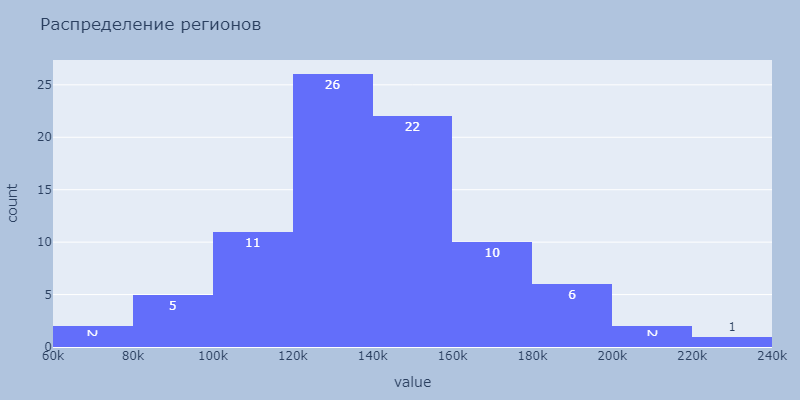

In [493]:
fig = px.histogram(X.T.iloc[15], height=400, width=800, text_auto=True,
    title='Распределение регионов'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

In [494]:
# проверка на нормальность
alpha = 0.05

for i in range(0, X.shape[1]):
    _, p = stats.shapiro(X.T.iloc[i])
    if p <= alpha:
        print('Распределение не нормальное', f'Столбец: {X.T.iloc[i].name}')
    else:
        continue

Распределение не нормальное Столбец: child_mor_rur
Распределение не нормальное Столбец: child_mor_urb
Распределение не нормальное Столбец: child_mor
Распределение не нормальное Столбец: disabled_18_30
Распределение не нормальное Столбец: disabled_31_40
Распределение не нормальное Столбец: disabled_41_50
Распределение не нормальное Столбец: pregnancy_14
Распределение не нормальное Столбец: pregnancy_15_17
Распределение не нормальное Столбец: pregnancy_18_
Распределение не нормальное Столбец: neoplasm_14
Распределение не нормальное Столбец: neoplasm_15_17
Распределение не нормальное Столбец: neoplasm_18_
Распределение не нормальное Столбец: congenital_anomaly
Распределение не нормальное Столбец: poverty, %
Распределение не нормальное Столбец: poverty_16, %
Распределение не нормальное Столбец: poverty_work, %
Распределение не нормальное Столбец: poverty_old, %
Распределение не нормальное Столбец: welfare, %
Распределение не нормальное Столбец: income, rub
Распределение не нормальное Столб

Распределение большинства признаков не нормальное, нужно использовать нормализацию. Будем использовать MinMaxScaler

In [495]:
# нормализация
col = X.columns
mm = preprocessing.MinMaxScaler()
X_scaled = X.copy()
X_scaled = pd.DataFrame(mm.fit_transform(X_scaled), columns=col)

In [496]:
# поиск наибольшего коэффициента силуэта
silhouette(X_scaled, 3)

KMeans: cluster       3.00
silhouette    0.13
Name: 0, dtype: float64
Gaussian: cluster       3.00
silhouette    0.13
Name: 0, dtype: float64
Агломеративная кластеризация: cluster       3.00
silhouette    0.23
Name: 0, dtype: float64
Спектральная кластеризация: cluster       4.0
silhouette    0.4
Name: 1, dtype: float64
По методу распространения близости: 0.06


Результаты так себе, попробуем техники снижения размерности. Наилучший результат у спектральной кластеризации.

### PCA

В начале построим пайплайн из стандартизации и снижения размерности методом PCA.

In [497]:
#определяем метод главных компонент с двумя компонентами
pca = decomposition.PCA(n_components=0.9)
#обучаем алгоритм на наших данных
principalComponents = pca.fit_transform(X_scaled)
principalComponents.shape

(85, 14)

In [498]:
pipeline = Pipeline([('mm', preprocessing.MinMaxScaler()), ('pca', decomposition.PCA(n_components=2, random_state=1))])
X_pca = X.copy()
X_pca = pd.DataFrame(pipeline.fit_transform(X_pca), columns=['axis-1', 'axis-2'])

pipeline['pca'].explained_variance_ratio_.round(2)

array([0.26, 0.13])

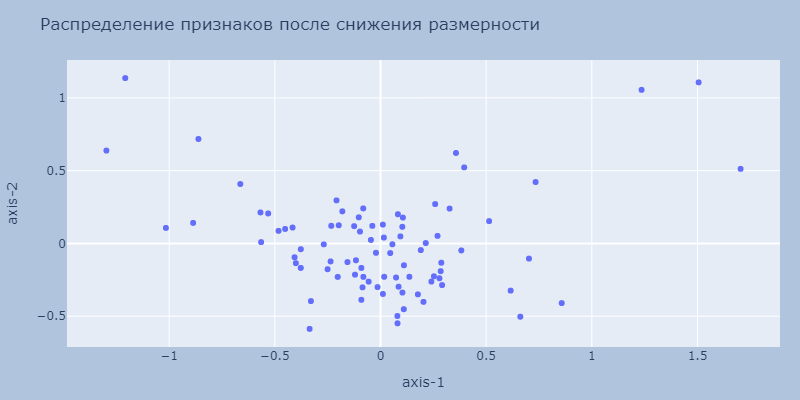

In [499]:
fig = px.scatter(X_pca, x='axis-1', y='axis-2', height=400, width=800,
    title='Распределение признаков после снижения размерности'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

In [500]:
# поиск наибольшего коэффициента силуэта
silhouette(X_pca, 3)

KMeans: cluster       3.00
silhouette    0.41
Name: 0, dtype: float64
Gaussian: cluster       3.00
silhouette    0.49
Name: 0, dtype: float64
Агломеративная кластеризация: cluster       3.00
silhouette    0.49
Name: 0, dtype: float64
Спектральная кластеризация: cluster       3.00
silhouette    0.56
Name: 0, dtype: float64
По методу распространения близости: 0.37


Коэффициент силуэта во всех случаях намного выше чем без понижения размерности и конечно же выше чем у baseline.

Сейчас сравним между собой em-кластреизацию и спектральную, потому что во многих случаях они выдавали одинаковые коэффициенты силуэта, сейчас они разные, но думаю стоит посмотреть на отличия.

In [501]:
gm = GaussianMixture(n_components=3, random_state=1).fit(X_pca)
X_pca_gm = X_pca.copy()
X_pca_gm['labels'] = gm.predict(X_pca)
X_pca_gm['labels'].value_counts()

labels
2    70
0    12
1     3
Name: count, dtype: int64

In [502]:
# количество регионов в каждом классе
sp = SpectralClustering(n_clusters=3, random_state=1, gamma=5).fit(X_pca)
X_pca_sp = X_pca.copy()
X_pca_sp['labels'] = sp.labels_
X_pca_sp['labels'].value_counts()

labels
0    79
1     3
2     3
Name: count, dtype: int64

In [503]:
# индексы Калински — Харабаса и Дэвиса — Болдина
chs_gm = metrics.calinski_harabasz_score(X_pca, gm.predict(X_pca)).round(2)
chs_sp = metrics.calinski_harabasz_score(X_pca, sp.labels_).round(2)
dbs_gm = metrics.davies_bouldin_score(X_pca, gm.predict(X_pca)).round(2)
dbs_sp = metrics.davies_bouldin_score(X_pca, sp.labels_).round(2)


if chs_gm>=chs_sp:
    print(f'{chs_gm} >= {chs_sp}, выбираем em-кластеризацию')
else:
    print(f'{chs_gm} < {chs_sp}, выбираем спектральную кластеризацию')
    
if chs_gm<=chs_sp:
    print(f'{dbs_gm} <= {dbs_sp}, выбираем em-кластеризацию')
else:
    print(f'{dbs_gm} > {dbs_sp}, выбираем спектральную кластеризацию')

59.08 >= 41.56, выбираем em-кластеризацию
0.64 > 0.43, выбираем спектральную кластеризацию


Противоположные выводы...

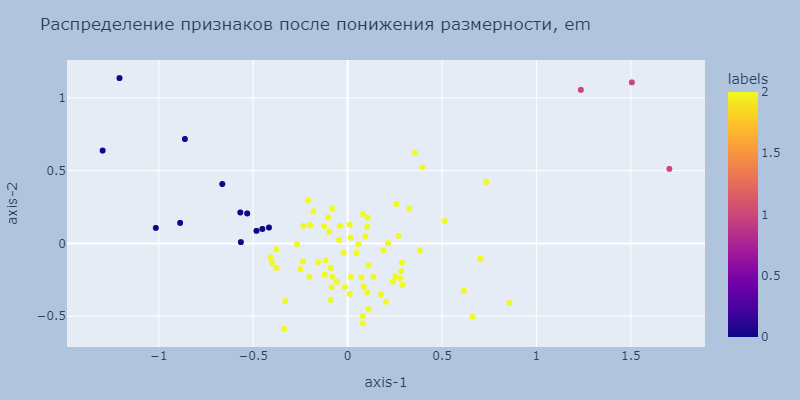

In [504]:
fig = px.scatter(X_pca_gm, x='axis-1', y='axis-2', color='labels', height=400, width=800,
    title='Распределение признаков после понижения размерности, em'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

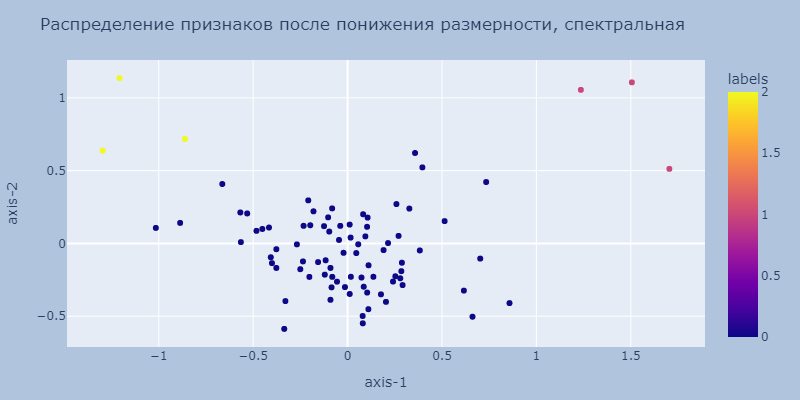

In [505]:
fig = px.scatter(X_pca_sp, x='axis-1', y='axis-2', color='labels', height=400, width=800,
    title='Распределение признаков после понижения размерности, спектральная'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

Забегая вперёд нам известно что три точки наверху принадлежат кластеру с высокими доходами и низким показателем бедности. Обе кластеризации отделяют их. Теперь посмотрим на левую сторону - спектральная кластеризация захватила только самый край, тогда как em захватила даже немного больше. Думаю что ближе к цели "выделить регионы, нуждающиеся в помощи малообеспеченным/неблагополучным слоям населения" ближе em-кластеризация, лучше помочь региону у которого пока ещё нормальные показатели чем не помочь действительно нуждающемуся в помощи региону. Так же снова забегаю вперёд - в 2023 и 2024 годах спектральная кластеризация совсем перестаёт выделять регионы со сложным положением, думаю это тоже плюс к em-кластеризации.

K=1 fitted in 0.009 seconds.
K=2 fitted in 0.049 seconds.
K=3 fitted in 0.044 seconds.
K=4 fitted in 0.039 seconds.
K=5 fitted in 0.019 seconds.
K=6 fitted in 0.019 seconds.
K=7 fitted in 0.036 seconds.


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

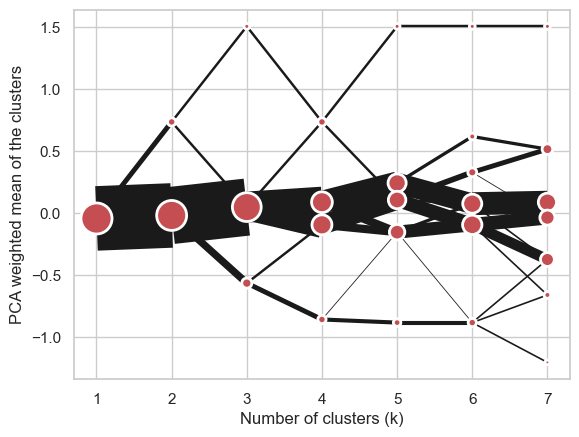

In [506]:
# задаём количество кластеров, для которых хотим получить визуализацию, определяем метод кластеризации
cgram = Clustergram(range(1, 8), method='gmm')

# запускаем алгоритм
cgram.fit(X_pca)
cgram.plot()

На трёх классах отличное разбиение.

In [507]:
# построение таблицы с данными сгруппированными по классам
X_grouppca_gm = X.copy()
X_grouppca_gm['labels'] = gm.predict(X_pca)
X_grouppca_mean_gm = X_grouppca_gm.groupby('labels').mean()
X_grouppca_mean_gm

child_mor_rur  child_mor_urb   child_mor  disabled_18_30   
labels                                                             
0          244.445064     271.073347  515.518412       18.231102  \
1          574.362810     262.362883  836.725693        0.635060   
2          128.806423     342.292045  471.098468        0.087665   

        disabled_31_40  disabled_41_50  disabled_51_60  disabled_61_   
labels                                                                 
0            18.654748        7.816440      -51.065390     16.181435  \
1             7.541615       13.844987      -49.911305    -21.855368   
2            -8.419556        8.271607      -67.588328   -187.934780   

        pregnancy_14  pregnancy_15_17  ...   income, rub    population   
labels                                 ...                               
0           7.291667       335.550000  ...  23105.666667  1.201287e+06  \
1          90.800000      2372.800000  ...  87872.000000  1.993067e+05   
2          24.841429       915.694286  ...  32369.428571  1.898122e+06   

        gross_product, rub   extraction  production  electricity   
labels                                                             
0             2.830412e+05    32.698386   48.416205    17.258366  \
1             4.206773e+06  3756.204264  868.349968   173.965118   
2             6.100440e+05   121.069510  332.323979    42.185729   

          retail, rub      newborn   
labels                               
0       165590.666667  1276.367498  \
1       268070.000000  1263.842251   
2       241168.514286   900.672605   

        Размер общей площади в расчете на члена домохозяйства   
labels                                                          
0                                               26.775000      \
1                                               25.266667       
2                                               23.975714       

        Размер жилой площади в расчете на члена домохозяйства  
labels                                                         
0                                               19.541667      
1                                               16.833333      
2                                               16.758571      

[3 rows x 33 columns]

In [508]:
# построение таблицы с данными сгруппированными по классам
X_grouppca_sp = X.copy()
X_grouppca_sp['labels'] = sp.labels_
X_grouppca_mean_sp = X_grouppca_sp.groupby('labels').mean()
X_grouppca_mean_sp

child_mor_rur  child_mor_urb   child_mor  disabled_18_30   
labels                                                             
0          139.300026     333.972560  473.272586       -0.272229  \
1          574.362810     262.362883  836.725693        0.635060   
2          315.029457     276.497017  591.526474       82.138629   

        disabled_31_40  disabled_41_50  disabled_51_60  disabled_61_   
labels                                                                 
0            -6.936995        8.106352      -67.659086   -168.763695  \
1             7.541615       13.844987      -49.911305    -21.855368   
2            60.836897       10.802649        0.366700    123.691524   

        pregnancy_14  pregnancy_15_17  ...   income, rub    population   
labels                                 ...                               
0          22.882278       853.417722  ...  31426.367089  1.834806e+06  \
1          90.800000      2372.800000  ...  87872.000000  1.993067e+05   
2           6.233333       235.066667  ...  20148.333333  7.781097e+05   

        gross_product, rub   extraction  production  electricity   
labels                                                             
0             5.761398e+05   111.535447  301.642932    39.575433  \
1             4.206773e+06  3756.204264  868.349968   173.965118   
2             1.948433e+05    18.648672    4.627126    11.214071   

          retail, rub      newborn   
labels                               
0       235181.278481   919.835361  \
1       268070.000000  1263.842251   
2        96521.000000  1898.832927   

        Размер общей площади в расчете на члена домохозяйства   
labels                                                          
0                                               24.278481      \
1                                               25.266667       
2                                               27.200000       

        Размер жилой площади в расчете на члена домохозяйства  
labels                                                         
0                                               17.050633      
1                                               16.833333      
2                                               20.200000      

[3 rows x 33 columns]

In [509]:
X_grouppca_gm[X_grouppca_gm.labels==0].index

Index(['Республика Адыгея', 'Республика Калмыкия', 'Республика Крым',
       'Астраханская область', 'Республика Дагестан', 'Республика Ингушетия',
       'Кабардино-Балкарская Республика', 'Карачаево-Черкесская Республика',
       'Чеченская Республика', 'Ставропольский край', 'Республика Тыва',
       'Республика Бурятия'],
      dtype='object', name='Unnamed: 0')

In [510]:
X_grouppca_sp[X_grouppca_sp.labels==2].index

Index(['Республика Ингушетия', 'Чеченская Республика', 'Республика Тыва'], dtype='object', name='Unnamed: 0')

Регионы из em-кластеризации наиболее соответствуют регионам с плохим социально-экономическим положением из вышеупомянутого исследования.

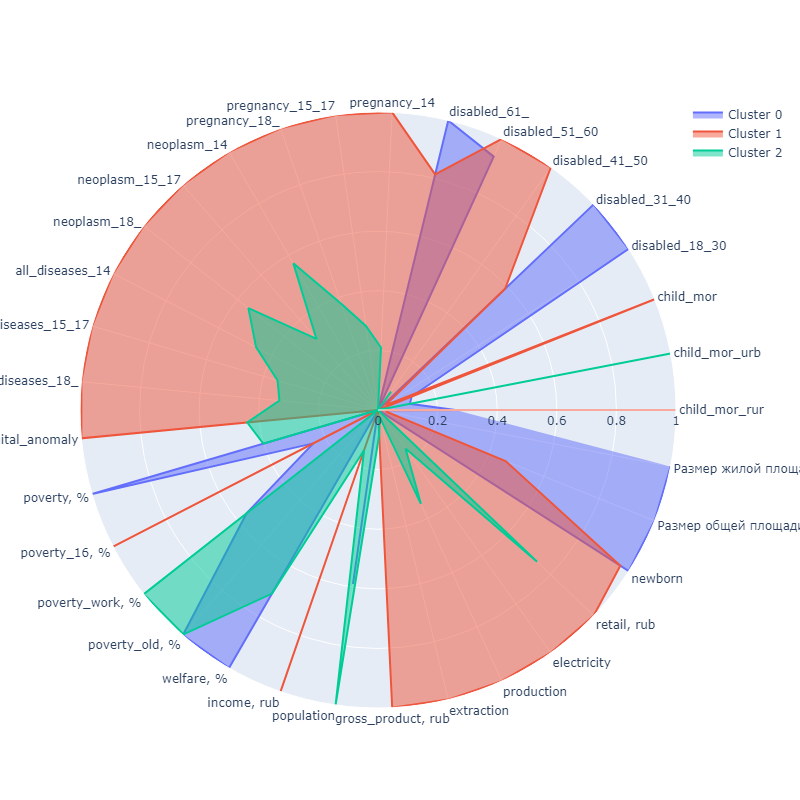

In [511]:
# полярная диаграмма
plot_cluster_profile(X_grouppca_mean_gm, 3)

При разделении на 2 класса разделение неравномерное - 82 и 3, например. При 3-х классах "основной" класс меньше. Проблема видимо возникает из-за равномерного распределения.

Снижение размерности до 2-х признаков показывает лучшие коэффициенты силуэта, чем при таком же снижении до 3-х.

При спектральной кластеризации коэффициент силуэта наибольший, по индексам Калински — Харабаса и Дэвиса — Болдина результаты противоречивы. Спектральная кластеризация как бы недозахватила целевые регионы и регионы из целевого кластера em-кластеризации наиболее полно соответствуют регионам с плохим социально-экономическим положением из исследования. Соотвественно выбираем em-кластеризацию

### TSNE

В начале построим пайплайн из стандартизации и снижения размерности методом TSNE.

In [512]:
pipeline = Pipeline([('mm', preprocessing.MinMaxScaler()),('tsne', manifold.TSNE(n_components=2, random_state=1))])
X_tsne = X.copy()
X_tsne = pd.DataFrame(pipeline.fit_transform(X_tsne), columns=['axis-1', 'axis-2'])

round(pipeline['tsne'].kl_divergence_, 2)

0.31

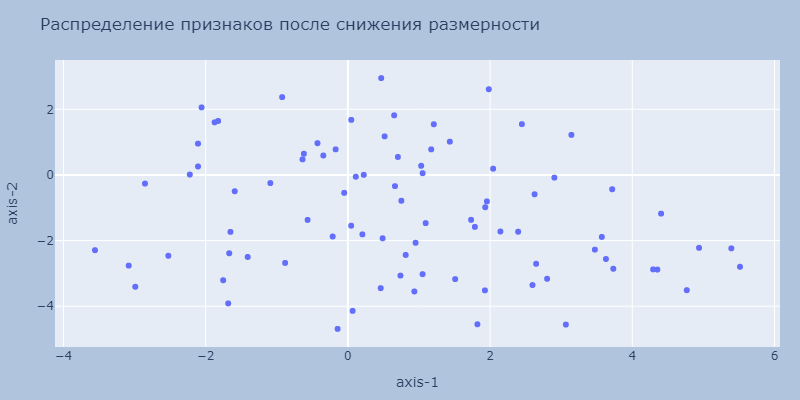

In [513]:
fig = px.scatter(X_tsne, x='axis-1', y='axis-2', height=400, width=800,
    title='Распределение признаков после снижения размерности'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

In [514]:
# поиск наибольшего коэффициента силуэта
silhouette(X_tsne, 3)

KMeans: cluster       3.0
silhouette    0.4
Name: 0, dtype: float64
Gaussian: cluster       3.00
silhouette    0.39
Name: 0, dtype: float64
Агломеративная кластеризация: cluster       3.00
silhouette    0.39
Name: 0, dtype: float64
Спектральная кластеризация: cluster       3.00
silhouette    0.39
Name: 0, dtype: float64
По методу распространения близости: 0.36000001430511475


Результаты метрики меньше чем при PCA, нет смысла проводить дальнейшие исследования с использованием этой техники.

### SVD

В начале построим пайплайн из стандартизации и снижения размерности методом SVD.

In [515]:
pipeline = Pipeline([('mm', preprocessing.MinMaxScaler()),('svd', decomposition.TruncatedSVD(n_components=2, random_state=1))])
X_svd = X.copy()
X_svd = pd.DataFrame(pipeline.fit_transform(X_svd), columns=['axis-1', 'axis-2'])

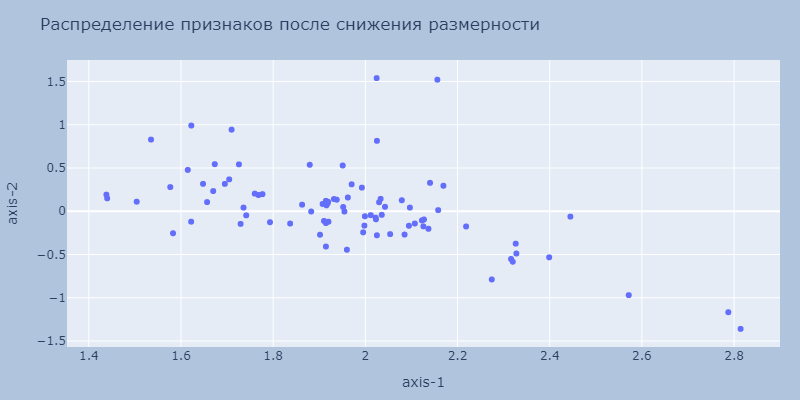

In [516]:
fig = px.scatter(X_svd, x='axis-1', y='axis-2', height=400, width=800,
    title='Распределение признаков после снижения размерности'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

In [517]:
# поиск наибольшего коэффициента силуэта
silhouette(X_svd, 3)

KMeans: cluster       3.00
silhouette    0.51
Name: 0, dtype: float64
Gaussian: cluster       3.00
silhouette    0.51
Name: 0, dtype: float64
Агломеративная кластеризация: cluster       3.00
silhouette    0.51
Name: 0, dtype: float64
Спектральная кластеризация: cluster       3.00
silhouette    0.58
Name: 0, dtype: float64
По методу распространения близости: 0.41


In [518]:
# количество регионов в каждом классе
gm = GaussianMixture(n_components=3, random_state=1).fit(X_svd)
X_svd_gm = X_svd.copy()
X_svd_gm['labels'] = gm.predict(X_svd)
X_svd_gm['labels'].value_counts()

labels
0    67
1     9
2     9
Name: count, dtype: int64

In [519]:
sp = SpectralClustering(n_clusters=3, random_state=1).fit(X_svd)
X_svd_sp = X_svd.copy()
X_svd_sp['labels'] = sp.labels_
X_svd_sp['labels'].value_counts()

labels
0    80
1     3
2     2
Name: count, dtype: int64

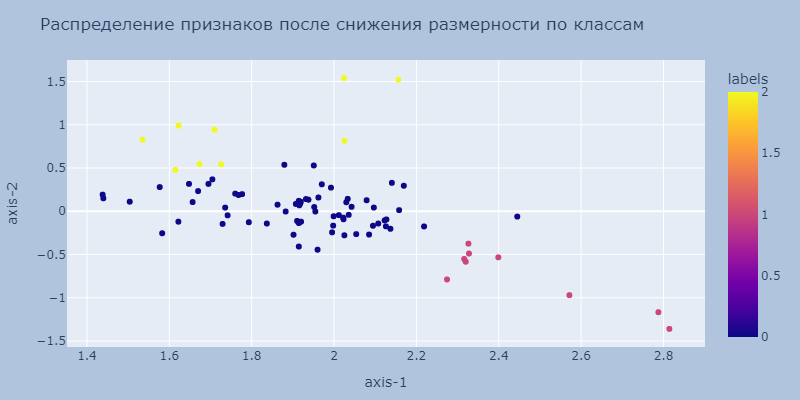

In [520]:
fig = px.scatter(X_svd_gm, x='axis-1', y='axis-2', color='labels', height=400, width=800,
    title='Распределение признаков после снижения размерности по классам'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

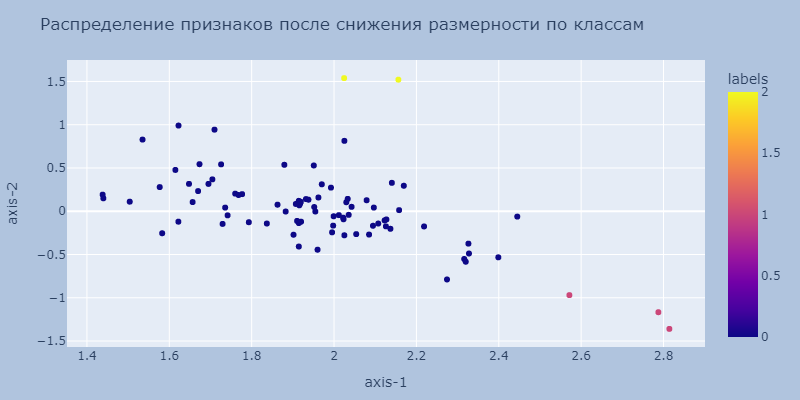

In [521]:
fig = px.scatter(X_svd_sp, x='axis-1', y='axis-2', color='labels', height=400, width=800,
    title='Распределение признаков после снижения размерности по классам'
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
    paper_bgcolor='LightSteelBlue',
    showlegend=False
)

fig.show('png')

In [522]:
# индексы Калински — Харабаса и Дэвиса — Болдина
chs_gm = metrics.calinski_harabasz_score(X_svd, gm.predict(X_svd)).round(2)
chs_sp = metrics.calinski_harabasz_score(X_svd, sp.labels_).round(2)
dbs_gm = metrics.davies_bouldin_score(X_svd, gm.predict(X_svd)).round(2)
dbs_sp = metrics.davies_bouldin_score(X_svd, sp.labels_).round(2)


if chs_gm>=chs_sp:
    print(f'{chs_gm} >= {chs_sp}, выбираем em-кластеризацию')
else:
    print(f'{chs_gm} < {chs_sp}, выбираем спектральную кластеризацию')
    
if chs_gm<=chs_sp:
    print(f'{dbs_gm} <= {dbs_sp}, выбираем em-кластеризацию')
else:
    print(f'{dbs_gm} > {dbs_sp}, выбираем спектральную кластеризацию')

75.63 >= 34.18, выбираем em-кластеризацию
0.67 > 0.32, выбираем спектральную кластеризацию


K=1 fitted in 0.009 seconds.
K=2 fitted in 0.017 seconds.
K=3 fitted in 0.014 seconds.
K=4 fitted in 0.032 seconds.
K=5 fitted in 0.027 seconds.
K=6 fitted in 0.023 seconds.
K=7 fitted in 0.031 seconds.


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

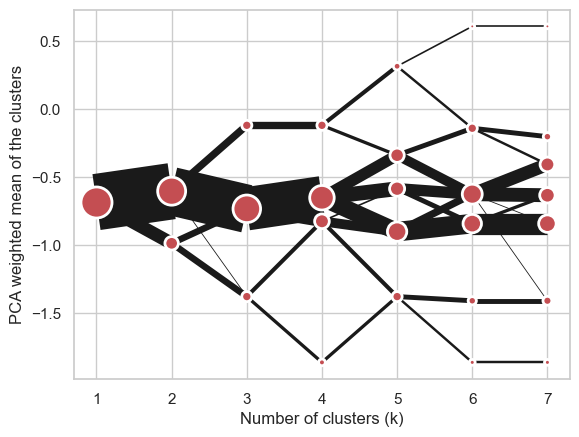

In [523]:
# задаём количество кластеров, для которых хотим получить визуализацию, определяем метод кластеризации
cgram = Clustergram(range(1, 8), method='gmm')

# запускаем алгоритм
cgram.fit(X_svd)
cgram.plot()

In [524]:
# построение таблицы с данными сгруппированными по классам
X_groupsvd_gm = X.copy()
X_groupsvd_gm['labels'] = gm.predict(X_svd)
X_groupsvd_mean_gm = X_groupsvd_gm.groupby('labels').mean()
X_groupsvd_mean_gm

child_mor_rur  child_mor_urb   child_mor  disabled_18_30   
labels                                                             
0          134.483794     337.135179  471.618973       -0.607781  \
1          240.996644     321.296250  562.292894        3.487451   
2          277.054980     280.076527  557.131507       26.238803   

        disabled_31_40  disabled_41_50  disabled_51_60  disabled_61_   
labels                                                                 
0            -7.928798        8.443689      -68.485983   -175.216291  \
1            -4.635873       13.382476      -54.831040   -183.401153   
2            25.562804        3.130589      -45.740146     40.364270   

        pregnancy_14  pregnancy_15_17  ...   income, rub    population   
labels                                 ...                               
0          24.010448       839.449254  ...  31055.507463  1.874223e+06  \
1          47.066667      1764.700000  ...  58228.888889  1.069100e+06   
2           7.388889       346.466667  ...  22440.555556  1.409679e+06   

        gross_product, rub   extraction  production  electricity   
labels                                                             
0             5.673505e+05    89.622923  313.512488    40.338999  \
1             2.057431e+06  1556.390100  560.950243    92.117336   
2             2.433922e+05    13.734713   43.870450    16.691979   

          retail, rub      newborn   
labels                               
0       233252.253731   899.958788  \
1       293427.888889  1062.269420   
2       156038.000000  1366.372832   

        Размер общей площади в расчете на члена домохозяйства   
labels                                                          
0                                               24.174627      \
1                                               24.111111       
2                                               26.522222       

        Размер жилой площади в расчете на члена домохозяйства  
labels                                                         
0                                               16.895522      
1                                               16.733333      
2                                               19.500000      

[3 rows x 33 columns]

In [525]:
# построение таблицы с данными сгруппированными по классам
X_groupsvd_sp = X.copy()
X_groupsvd_sp['labels'] = sp.labels_
X_groupsvd_mean_sp = X_groupsvd_sp.groupby('labels').mean()
X_groupsvd_mean_sp

child_mor_rur  child_mor_urb   child_mor  disabled_18_30   
labels                                                             
0          142.246744     332.048128  474.294872       -0.227625  \
1          574.362810     262.362883  836.725693        0.635060   
2          285.025434     324.736525  609.761959      121.559876   

        disabled_31_40  disabled_41_50  disabled_51_60  disabled_61_   
labels                                                                 
0            -6.737915        7.885163      -66.888259   -166.141000  \
1             7.541615       13.844987      -49.911305    -21.855368   
2            86.760613       20.998355        3.546539    165.011342   

        pregnancy_14  pregnancy_15_17  ...  income, rub    population   
labels                                 ...                              
0           22.79125        848.34125  ...   31270.6875  1.816043e+06  \
1           90.80000       2372.80000  ...   87872.0000  1.993067e+05   
2            1.55000        128.95000  ...   20736.5000  1.000302e+06   

        gross_product, rub   extraction  production  electricity  retail, rub   
labels                                                                          
0             5.721338e+05   110.772779  297.893023    39.285557   233348.325  \
1             4.206773e+06  3756.204264  868.349968   173.965118   268070.000   
2             1.644350e+05     2.712006    6.115578     8.628443   100509.000   

            newborn  Размер общей площади в расчете на члена домохозяйства   
labels                                                                       
0        933.167069                                          24.210000      \
1       1263.842251                                          25.266667       
2       1855.063404                                          31.400000       

        Размер жилой площади в расчете на члена домохозяйства  
labels                                                         
0                                               17.007500      
1                                               16.833333      
2                                               23.500000      

[3 rows x 33 columns]

In [526]:
# регионы нуждающиеся в помощи, em-кластеризация
X_groupsvd_gm[X_groupsvd_gm.labels==2].index

Index(['Республика Крым', 'Республика Дагестан', 'Республика Ингушетия',
       'Кабардино-Балкарская Республика', 'Карачаево-Черкесская Республика',
       'Чеченская Республика', 'Ставропольский край', 'Республика Тыва',
       'Республика Бурятия'],
      dtype='object', name='Unnamed: 0')

In [527]:
# регионы нуждающиеся в помощи, спектральная кластеризация
X_groupsvd_sp[X_groupsvd_sp.labels==2].index

Index(['Республика Ингушетия', 'Чеченская Республика'], dtype='object', name='Unnamed: 0')

In [528]:
# регионы нуждающиеся в помощи, em-кластеризация, pca
X_grouppca_gm[X_grouppca_gm.labels==0].index

Index(['Республика Адыгея', 'Республика Калмыкия', 'Республика Крым',
       'Астраханская область', 'Республика Дагестан', 'Республика Ингушетия',
       'Кабардино-Балкарская Республика', 'Карачаево-Черкесская Республика',
       'Чеченская Республика', 'Ставропольский край', 'Республика Тыва',
       'Республика Бурятия'],
      dtype='object', name='Unnamed: 0')

### Вывод по подбору модели

С техникой SVD получилось лучше чем с PCA - меньший разброс. Как итог буду использовать метод снижения размерности SVD и em-кластеризацию.

## 2. Кластеризация и описание классов

In [529]:
# функция для кластеризации таблиц по годам и описания
def add_labels(df):
    data = df.copy()
    # понижение размерности
    pipe = Pipeline([('ss', preprocessing.MinMaxScaler()), ('svd', decomposition.TruncatedSVD(n_components=2, random_state=1))])
    data_svd = data.copy()
    data_svd = pd.DataFrame(pipe.fit_transform(data_svd), columns=['axis-1', 'axis-2'])

    # кластеризация
    gm = GaussianMixture(n_components=3, random_state=1).fit(data_svd)
    predictions = gm.predict(data_svd)
    data_svd['labels'] = predictions
    print(data_svd['labels'].value_counts())
    
    # диаграмма рассеяния после понижения размерности
    fig = px.scatter(data_svd, x='axis-1', y='axis-2', color='labels', height=400, width=800,
        title='Распределение признаков после снижения размерности по классам'
    )

    fig.update_layout(
        margin=dict(l=20, r=20, t=60, b=20),
        paper_bgcolor='LightSteelBlue',
        showlegend=False
    )

    print(fig.show('png'))

    # таблица средних
    data['labels'] = predictions
    data_group_mean = data.groupby('labels').mean().reset_index()
    return data, data_group_mean

### 2017 год

labels
1    69
0    10
2     6
Name: count, dtype: int64


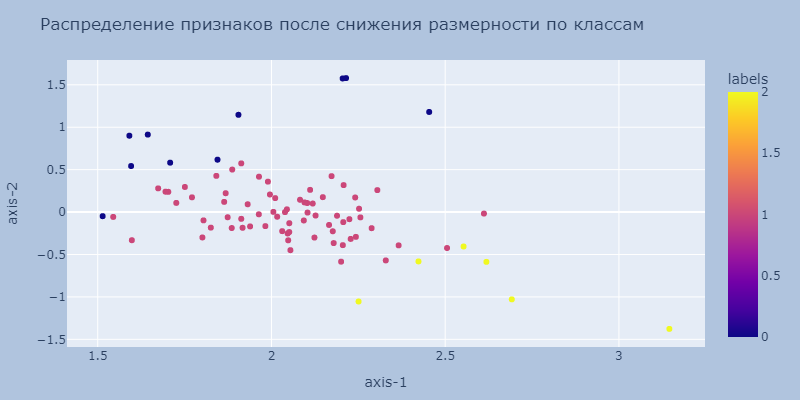

None


In [530]:
X = dict_result['df_2017']
df_2017, data2017_group = add_labels(dict_result['df_2017'])

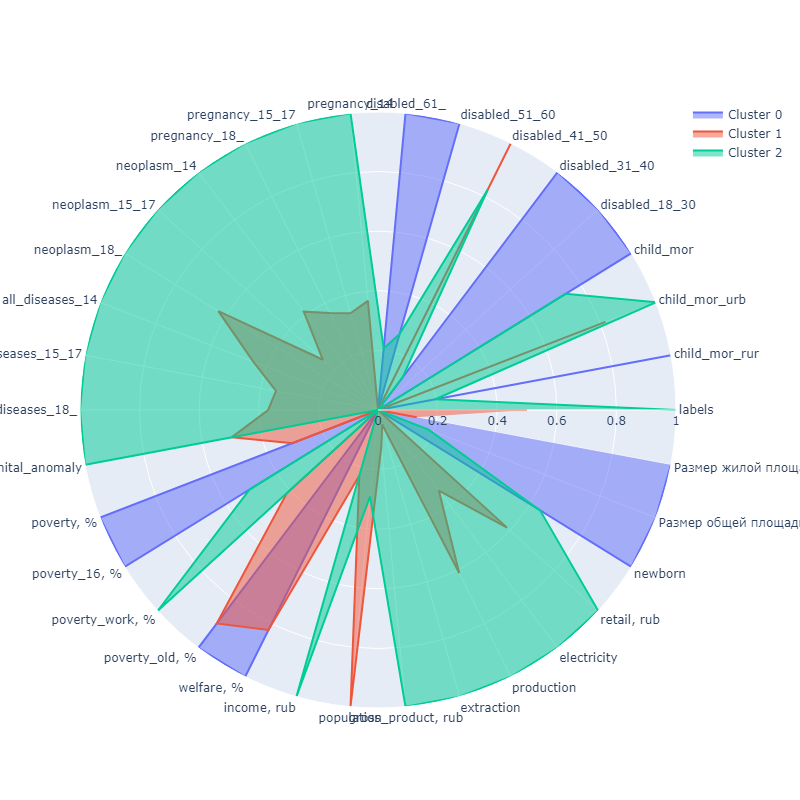

In [531]:
plot_cluster_profile(data2017_group, 3)

Кластер 0

Тамбовская область, Республика Калмыкия, Республика Крым, Республика Дагестан, Республика Ингушетия, Кабардино-Балкарская Республика, Карачаево-Черкесская Республика, Чеченская Республика, Республика Тыва, Республика Бурятия

Очень высокий процент бедности - почти в два раза выше чем в других регионах, наибольшее количество это дети и трудоспособное население; самая высокая детская смертность в сельской местности, возможно это связано с большим количеством сельской местности в регионе; наибольшее увеличение количества людей с инвалидностью за год на 100тыс. человек населения, такая ситуация наблюдается почти по всем возрастным категориям кроме 41-50; наименьшее количество зарегистрированных беременностей, но при этом наибольшее количество новорождённых; наименьшее количество зарегистрированных заболеваний, в том числе новообразований и врожденных хромосомных аномалий; самые большие расходы на социальную политику, возможно это связано с количеством людей, имеющих доходы ниже величины прожиточного минимума; наименьшие среднедушевые и реальные доходы населения; в этих регионах наименьший объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, и наименьший оборот розничной торговли; наибольшие размеры общей и жилой площади, что косвенно подстверждает наличие большого количества сельской метсности.

Видимо эти регионы наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения.

Кластер 1

Наименьшая детская смертность - в городах больше, в сельской местности меньше, возможно это связано с тем что наибольшее количество населения проживает в городах; лучшая динамика по изменению количества людей с инвалидностью во всех возрастных категориях кроме 18-30 и 41-50; особых примечаний относительно общего уровня заболеваемости(в том числе новообразования и хромосомные аномалии) нет, средний уровень; остальные показатели также на среднем уровне.

Это наиболее многочисленный кластер, сложилось впечатление что это средние регионы без резких подъёмов и падений, видимо в помощи не нуждаются.

Кластер 2

Республика Коми, Архангельская область, Ненецкий автономный округ, Город Санкт-Петербург, Ямало-Ненецкий автономный округ, Чукотский автономный округ

Самое большое количество зарегистрированных беременностей; наибольшие среднедушевые и реальные доходы населения, наибольший валовой региональный продукт и наибольшая добыча полезных ископаемых и обеспечение элктроэнергией. Также наименьшие расходы на социальную политику, возможно это связано с наименьшим количеством населения.

In [532]:
data2017_group.T

0   
labels                                              0.000000e+00  \
child_mor_rur                                       3.764996e+02   
child_mor_urb                                       2.672580e+02   
child_mor                                           6.437577e+02   
disabled_18_30                                     -6.796925e+00   
disabled_31_40                                      2.489279e+01   
disabled_41_50                                     -1.271987e+01   
disabled_51_60                                     -1.663334e+01   
disabled_61_                                        5.341165e+01   
pregnancy_14                                        5.980000e+00   
pregnancy_15_17                                     3.680000e+02   
pregnancy_18_                                       6.411290e+03   
neoplasm_14                                         2.214600e+02   
neoplasm_15_17                                      2.346400e+02   
neoplasm_18_                                        7.865200e+02   
all_diseases_14                                     1.168066e+05   
all_diseases_15_17                                  1.066923e+05   
all_diseases_18_                                    4.400941e+04   
congenital_anomaly                                  7.238700e+02   
poverty, %                                          2.216000e+01   
poverty_16, %                                       3.979000e+01   
poverty_work, %                                     5.304000e+01   
poverty_old, %                                      7.180000e+00   
welfare, %                                          2.468000e+01   
income, rub                                         2.041470e+04   
population                                          1.084462e+06   
gross_product, rub                                  2.074907e+05   
extraction                                          1.250464e+01   
production                                          3.666989e+01   
electricity                                         1.317694e+01   
retail, rub                                         1.200328e+05   
newborn                                             1.447272e+03   
Размер общей площади в расчете на члена домохоз...  2.695000e+01   
Размер жилой площади в расчете на члена домохоз...  1.964000e+01   

                                                               1             2  
labels                                              1.000000e+00  2.000000e+00  
child_mor_rur                                       1.797224e+02  2.182242e+02  
child_mor_urb                                       3.787272e+02  4.034034e+02  
child_mor                                           5.584497e+02  6.216275e+02  
disabled_18_30                                     -2.152843e+01 -2.170490e+01  
disabled_31_40                                      6.792905e-01  3.992920e+00  
disabled_41_50                                     -5.662948e+00 -6.893856e+00  
disabled_51_60                                     -7.558405e+01 -5.997341e+01  
disabled_61_                                       -7.197938e+01 -4.600510e+01  
pregnancy_14                                        2.462174e+01  5.668333e+01  
pregnancy_15_17                                     8.746478e+02  1.868817e+03  
pregnancy_18_                                       7.655317e+03  9.836717e+03  
neoplasm_14                                         4.769246e+02  8.393333e+02  
neoplasm_15_17                                      4.578072e+02  1.126533e+03  
neoplasm_18_                                        1.335226e+03  1.657083e+03  
all_diseases_14                                     1.864533e+05  2.719665e+05  
all_diseases_15_17                                  1.402508e+05  2.030671e+05  
all_diseases_18_                                    5.472318e+04  7.306623e+04  
congenital_anomaly                                  1.590720e+03  2.458050e+03  
poverty, %                                          1.403188e+

### 2018 год

labels
2    66
0    10
1     9
Name: count, dtype: int64


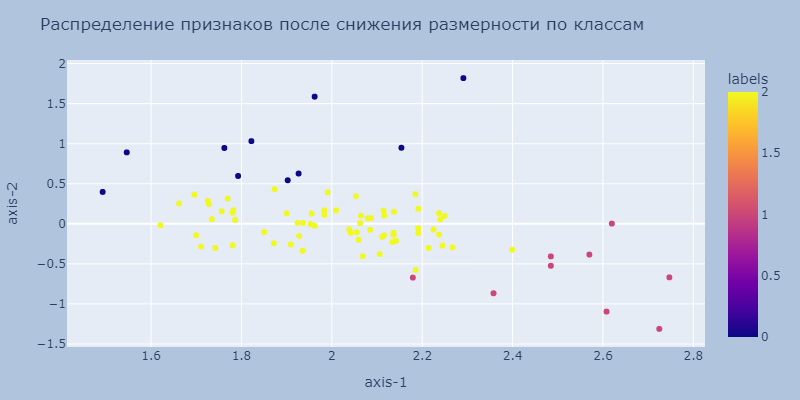

None


In [533]:
df_2018, data2018_group = add_labels(dict_result['df_2018'])

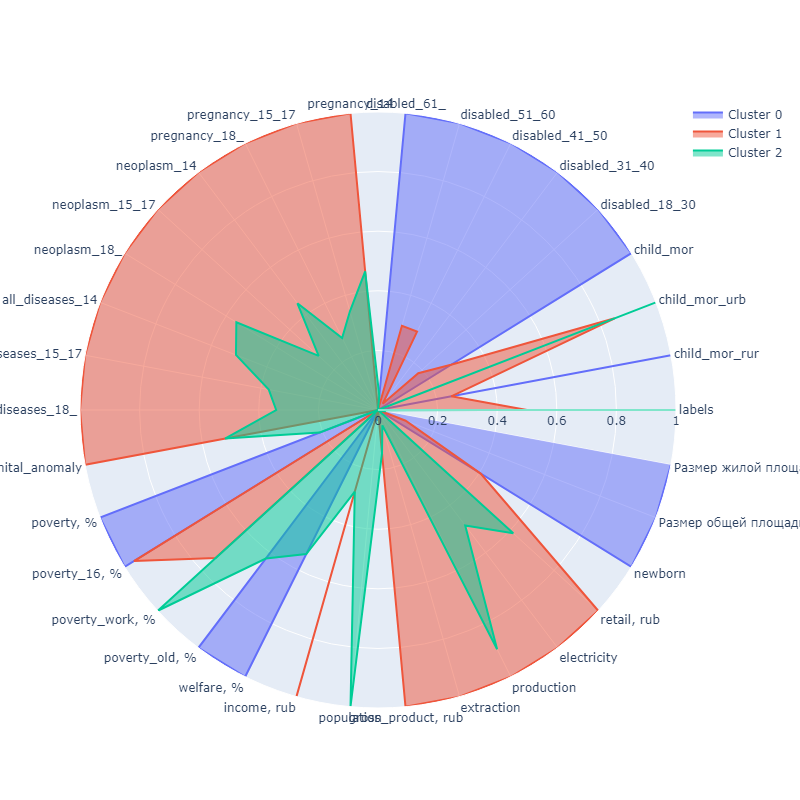

In [534]:
plot_cluster_profile(data2018_group, 3)

In [535]:
df_2018[df_2018.labels==1].index

Index(['Республика Карелия', 'Республика Коми', 'Архангельская область',
       'Ненецкий автономный округ', 'Город Санкт-Петербург',
       'Ямало-Ненецкий автономный округ', 'Алтайский край',
       'Сахалинская область', 'Чукотский автономный округ'],
      dtype='object', name='Unnamed: 0')

Кластер 0

По сравнению с предыдущим годом особых изменений нет

Республика Калмыкия, Республика Крым, Республика Дагестан, Республика Ингушетия, Кабардино-Балкарская Республика, Карачаево-Черкесская Республика, Чеченская Республика, Ставропольский край, Республика Тыва, Республика Бурятия

Очень высокий процент бедности - почти в два раза выше чем в других регионах, наибольшее количество это дети и трудоспособное население; самая высокая детская смертность, особенно в сельской местности, возможно это связано с большим количеством сельской местности в регионе; наибольшее увеличение количества людей с инвалидностью за год на 100тыс. человек населения, такая ситуация наблюдается по всем возрастным категориям; наименьшее количество зарегистрированных беременностей, но при этом наибольшее количество новорождённых; наименьшее количество зарегистрированных заболеваний, в том числе новообразований и врожденных хромосомных аномалий; самые большие расходы на социальную политику, возможно это связано с количеством людей, имеющих доходы ниже величины прожиточного минимума; наименьшие среднедушевые и реальные доходы населения; в этих регионах наименьший объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, и наименьший оборот розничной торговли; наибольшие размеры общей и жилой площади, что косвенно подстверждает наличие большого количества сельской метсности.

Видимо эти регионы наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения.

Кластер 1

Республика Карелия, Республика Коми, Архангельская область, Ненецкий автономный округ, Город Санкт-Петербург, Ямало-Ненецкий автономный округ, Алтайский край, Сахалинская область, Чукотский автономный округ

Самое большое количество зарегистрированных беременностей по всем возрастным категориям; наибольший уровень заболеваемости(включая новообразования и хромосомные аномалии); наибольшие среднедушевые и реальные доходы населения, наибольший валовой региональный продукт и наибольшая добыча полезных ископаемых и обеспечение электроэнергией. Также наименьшие расходы на социальную политику, возможно это связано с наименьшим количеством населения.

Кластер 2

Детская смертность низкая - в городах больше, в сельской местности меньше, возможно это связано с тем что наибольшее количество населения проживает в городах; лучшая динамика по изменению количества людей с инвалидностью во всех возрастных категориях кроме 61+; особых примечаний относительно общего уровня заболеваемости(в том числе новообразования и хромосомные аномалии) нет; процент бедности стал выше, также большой уровень бедности среди пенсионеров; остальные показатели на среднем уровне.

Это наиболее многочисленный кластер, сложилось впечатление что это средние регионы без резких подъёмов и падений, видимо в помощи не нуждаются.

In [536]:
data2018_group.T

0   
labels                                              0.000000e+00  \
child_mor_rur                                       3.795635e+02   
child_mor_urb                                       2.830697e+02   
child_mor                                           6.626332e+02   
disabled_18_30                                      9.532417e+00   
disabled_31_40                                      5.528744e+01   
disabled_41_50                                      4.434000e+01   
disabled_51_60                                      1.399979e+01   
disabled_61_                                        1.341355e+02   
pregnancy_14                                        6.650000e+00   
pregnancy_15_17                                     3.209200e+02   
pregnancy_18_                                       6.221740e+03   
neoplasm_14                                         2.032000e+02   
neoplasm_15_17                                      2.270900e+02   
neoplasm_18_                                        7.742400e+02   
all_diseases_14                                     1.120674e+05   
all_diseases_15_17                                  1.048712e+05   
all_diseases_18_                                    4.372533e+04   
congenital_anomaly                                  7.615400e+02   
poverty, %                                          2.208000e+01   
poverty_16, %                                       4.072000e+01   
poverty_work, %                                     5.223000e+01   
poverty_old, %                                      7.050000e+00   
welfare, %                                          2.485000e+01   
income, rub                                         2.056750e+04   
population                                          1.275053e+06   
gross_product, rub                                  2.196096e+05   
extraction                                          1.478460e+01   
production                                          3.515129e+01   
electricity                                         1.500542e+01   
retail, rub                                         1.216107e+05   
newborn                                             1.422501e+03   
Размер общей площади в расчете на члена домохоз...  2.694000e+01   
Размер жилой площади в расчете на члена домохоз...  1.957000e+01   

                                                               1             2  
labels                                              1.000000e+00  2.000000e+00  
child_mor_rur                                       2.092122e+02  1.523684e+02  
child_mor_urb                                       3.355002e+02  3.446189e+02  
child_mor                                           5.447123e+02  4.969873e+02  
disabled_18_30                                     -1.229172e+01 -1.717833e+01  
disabled_31_40                                      6.848553e+00  5.540665e+00  
disabled_41_50                                      1.746824e+01  6.275530e+00  
disabled_51_60                                     -4.704631e+01 -7.241903e+01  
disabled_61_                                       -3.457680e+01 -2.653217e+01  
pregnancy_14                                        4.516667e+01  2.463333e+01  
pregnancy_15_17                                     1.833078e+03  8.414652e+02  
pregnancy_18_                                       1.078777e+04  7.455194e+03  
neoplasm_14                                         7.958889e+02  4.691424e+02  
neoplasm_15_17                                      1.025922e+03  4.422742e+02  
neoplasm_18_                                        1.735689e+03  1.311738e+03  
all_diseases_14                                     2.557243e+05  1.854992e+05  
all_diseases_15_17                                  1.955809e+05  1.386923e+05  
all_diseases_18_                                    7.344682e+04  5.388055e+04  
congenital_anomaly                                  2.302833e+03  1.566755e+03  
poverty, %                                          1.118889e+

In [537]:
# приводим номера кластеров к единому порядку
df_2018.labels.replace({2:1, 1:2}, inplace=True)
data2018_group.labels.replace({2:1, 1:2}, inplace=True)

Далее сгруппирую талблицы за годы с 2019 по 2023, приведу к единым наименованиям кластеров и построю таблицу с усредненными данными за эти годы.

### 2019 год

labels
2    65
0    13
1     7
Name: count, dtype: int64


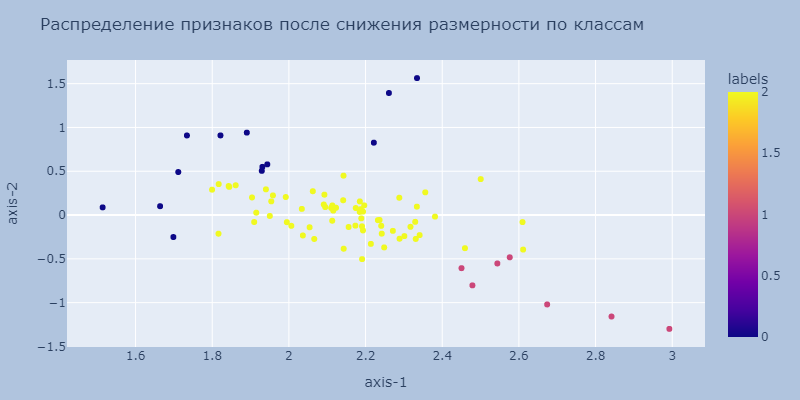

None


In [538]:
df_2019, data2019_group = add_labels(dict_result['df_2019'])

In [539]:
# приводим номера кластеров к единому порядку
df_2019.labels.replace({2:1, 1:2}, inplace=True)
data2019_group.labels.replace({2:1, 1:2}, inplace=True)

### 2020 год

labels
2    63
0    13
1     9
Name: count, dtype: int64


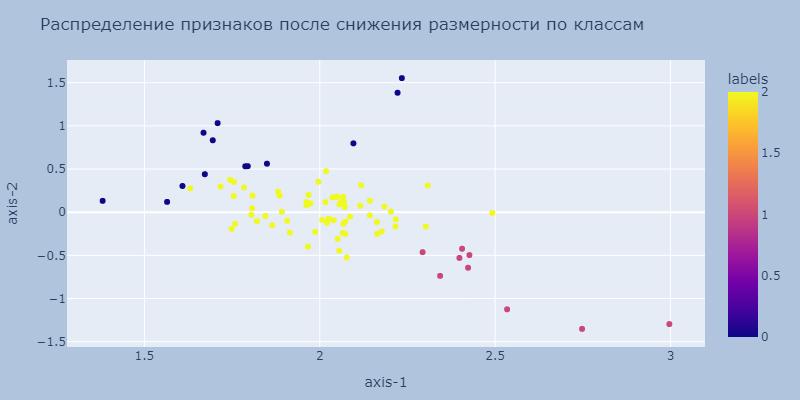

None


In [540]:
df_2020, data2020_group = add_labels(dict_result['df_2020'])

In [541]:
# приводим номера кластеров к единому порядку
df_2020.labels.replace({2:1, 1:2}, inplace=True)
data2020_group.labels.replace({2:1, 1:2}, inplace=True)

### 2021 год

labels
0    67
1     9
2     9
Name: count, dtype: int64


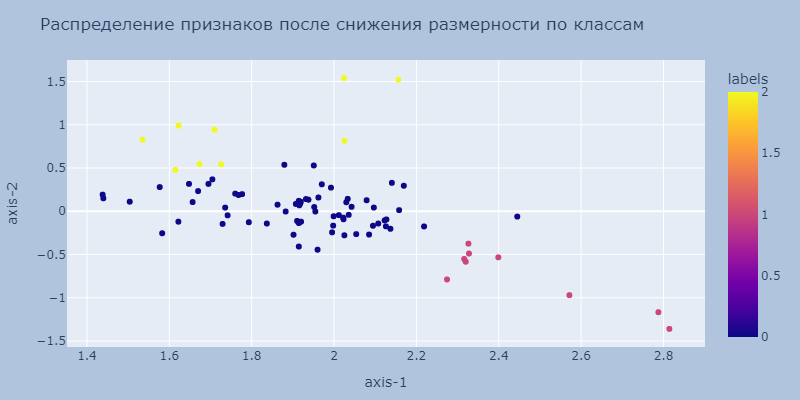

None


In [542]:
X = dict_result['df_2021']
df_2021, data2021_group = add_labels(X)

In [543]:
df_2021[df_2021.labels==1].index

Index(['Республика Карелия', 'Республика Коми', 'Архангельская область',
       'Ненецкий автономный округ', 'Мурманская область',
       'Город Санкт-Петербург', 'Ямало-Ненецкий автономный округ',
       'Сахалинская область', 'Чукотский автономный округ'],
      dtype='object', name='Unnamed: 0')

In [544]:
df_2021[df_2021.labels==0].index

Index(['Белгородская область', 'Брянская область', 'Владимирская область',
       'Воронежская область', 'Ивановская область', 'Калужская область',
       'Костромская область', 'Курская область', 'Липецкая область',
       'Московская область', 'Орловская область', 'Рязанская область',
       'Смоленская область', 'Тамбовская область', 'Тверская область',
       'Тульская область', 'Ярославская область', 'Город Москва',
       'Вологодская область', 'Калининградская область',
       'Ленинградская область', 'Новгородская область', 'Псковская область',
       'Республика Адыгея', 'Республика Калмыкия', 'Краснодарский край',
       'Астраханская область', 'Волгоградская область', 'Ростовская область',
       'Город Севастополь', 'Республика Северная Осетия',
       'Республика Башкортостан', 'Республика Марий Эл', 'Республика Мордовия',
       'Республика Татарстан', 'Удмуртская Республика', 'Чувашская Республика',
       'Пермский край', 'Кировская область', 'Нижегородская область',
  

In [545]:
# приводим номера кластеров к единому порядку
df_2021.labels.replace({2:0, 1:2, 0:1}, inplace=True)
data2021_group.labels.replace({2:0, 1:2, 0:1}, inplace=True)

### 2022 год

labels
2    66
0    10
1     9
Name: count, dtype: int64


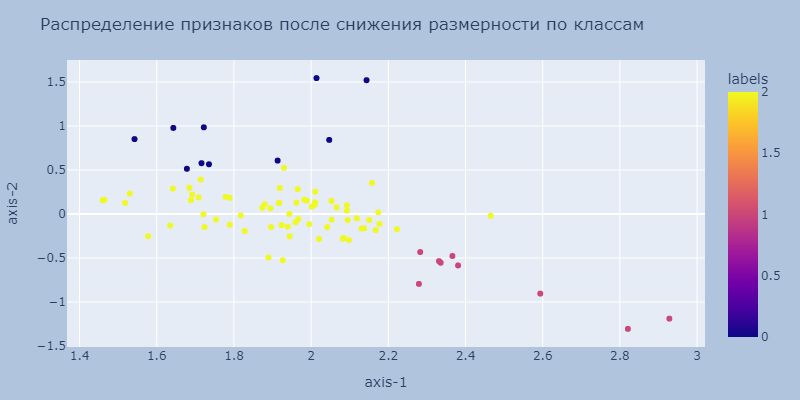

None


In [546]:
df_2022, data2022_group = add_labels(dict_result['df_2022'])

In [547]:
# приводим номера кластеров к единому порядку
df_2022.labels.replace({1:2, 2:1}, inplace=True)
data2022_group.labels.replace({1:2, 2:1}, inplace=True)

### 2023 год

labels
2    57
0    19
1     9
Name: count, dtype: int64


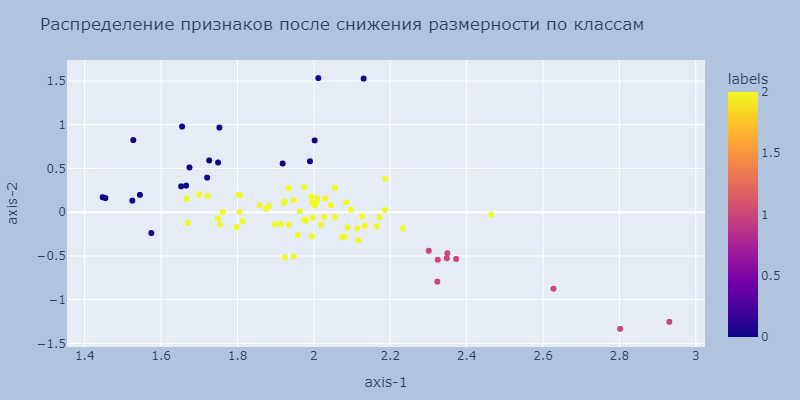

None


In [548]:
df_2023, data2023_group = add_labels(dict_result['df_2023'])

In [549]:
# приводим номера кластеров к единому порядку
df_2023.labels.replace({1:2, 2:1}, inplace=True)
data2023_group.labels.replace({1:2, 2:1}, inplace=True)

### Таблица со средними

In [550]:
# объединение таблиц средних в одну
data_mean = pd.concat([data2019_group, data2020_group, data2021_group, data2022_group, data2023_group], axis=0)

In [551]:
# рассчет средних показателей по кластерам за 5 лет(с 2019 по 2023)
data_mean_group = data_mean.groupby('labels').mean().reset_index()

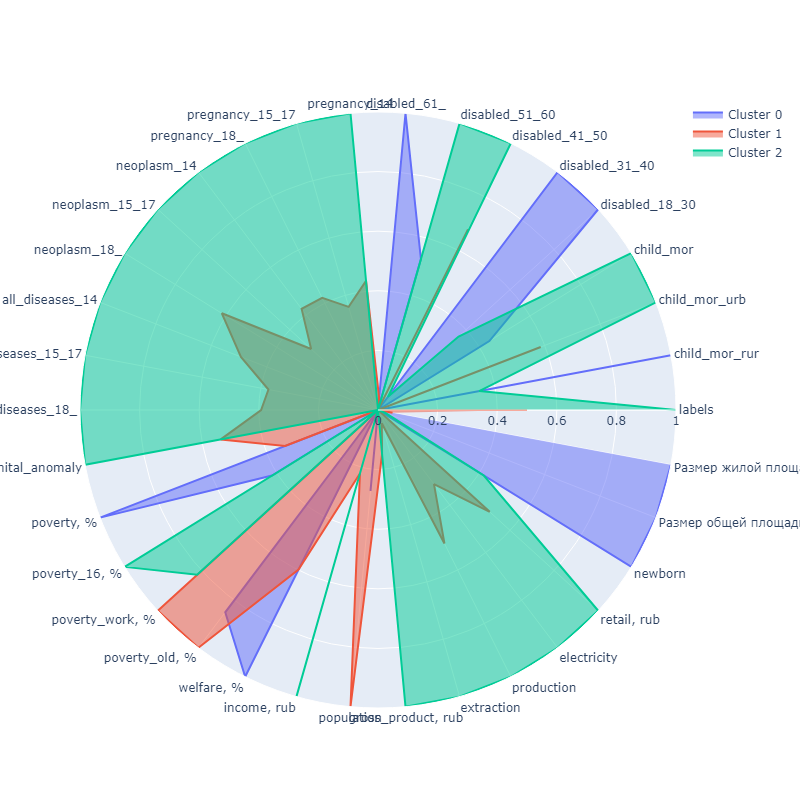

In [552]:
# полярная диаграмма
plot_cluster_profile(data_mean_group, 3)

In [553]:
data_mean_group.T

0   
labels                                              0.000000e+00  \
child_mor_rur                                       2.315384e+02   
child_mor_urb                                       2.560691e+02   
child_mor                                           4.876075e+02   
disabled_18_30                                      1.002808e+01   
disabled_31_40                                      1.551443e+01   
disabled_41_50                                     -2.189133e+00   
disabled_51_60                                     -5.954922e+01   
disabled_61_                                        4.305144e+00   
pregnancy_14                                        6.886482e+00   
pregnancy_15_17                                     3.415876e+02   
pregnancy_18_                                       6.177830e+03   
neoplasm_14                                         2.023070e+02   
neoplasm_15_17                                      2.176021e+02   
neoplasm_18_                                        8.312469e+02   
all_diseases_14                                     1.148806e+05   
all_diseases_15_17                                  1.068264e+05   
all_diseases_18_                                    4.517072e+04   
congenital_anomaly                                  8.600577e+02   
poverty, %                                          2.001972e+01   
poverty_16, %                                       4.002401e+01   
poverty_work, %                                     5.385233e+01   
poverty_old, %                                      6.123244e+00   
welfare, %                                          2.602799e+01   
income, rub                                         2.343041e+04   
population                                          1.309359e+06   
gross_product, rub                                  2.924210e+05   
extraction                                          1.881993e+01   
production                                          9.119326e+01   
electricity                                         1.883902e+01   
retail, rub                                         1.741133e+05   
newborn                                             1.276327e+03   
Размер общей площади в расчете на члена домохоз...  2.652443e+01   
Размер жилой площади в расчете на члена домохоз...  1.916574e+01   

                                                               1             2  
labels                                              1.000000e+00  2.000000e+00  
child_mor_rur                                       1.311955e+02  1.658576e+02  
child_mor_urb                                       3.209871e+02  3.669279e+02  
child_mor                                           4.521826e+02  5.327855e+02  
disabled_18_30                                     -3.780777e+00  1.272443e+00  
disabled_31_40                                     -5.565125e+00 -4.397349e+00  
disabled_41_50                                      9.159654e+00  1.456724e+01  
disabled_51_60                                     -6.828286e+01 -5.169175e+01  
disabled_61_                                       -1.443254e+02 -1.506395e+02  
pregnancy_14                                        2.511535e+01  4.877905e+01  
pregnancy_15_17                                     8.714909e+02  1.814043e+03  
pregnancy_18_                                       7.679917e+03  9.750243e+03  
neoplasm_14                                         4.765465e+02  8.472238e+02  
neoplasm_15_17                                      4.592516e+02  1.013533e+03  
neoplasm_18_                                        1.335737e+03  1.649701e+03  
all_diseases_14                                     1.875475e+05  2.621984e+05  
all_diseases_15_17                                  1.399492e+05  1.953893e+05  
all_diseases_18_                                    5.469553e+04  6.945505e+04  
congenital_anomaly                                  1.594798e+03  2.228346e+03  
poverty, %                                          1.329263e+

In [554]:
# стандартизация для понимания разницы
col = data_mean_group.columns
MM = preprocessing.MinMaxScaler()
data_scaled = data_mean_group.copy()
data_scaled = pd.DataFrame(MM.fit_transform(data_scaled), columns=col)

In [555]:
data_scaled.T

0         1   
labels                                              0.000000  0.500000  \
child_mor_rur                                       1.000000  0.000000   
child_mor_urb                                       0.000000  0.585591   
child_mor                                           0.439499  0.000000   
disabled_18_30                                      1.000000  0.000000   
disabled_31_40                                      1.000000  0.000000   
disabled_41_50                                      0.000000  0.677282   
disabled_51_60                                      0.526405  0.000000   
disabled_61_                                        1.000000  0.040751   
pregnancy_14                                        0.000000  0.435134   
pregnancy_15_17                                     0.000000  0.359877   
pregnancy_18_                                       0.000000  0.420468   
neoplasm_14                                         0.000000  0.425232   
neoplasm_15_17                                      0.000000  0.303606   
neoplasm_18_                                        0.000000  0.616393   
all_diseases_14                                     0.000000  0.493266   
all_diseases_15_17                                  0.000000  0.374003   
all_diseases_18_                                    0.000000  0.392220   
congenital_anomaly                                  0.000000  0.536978   
poverty, %                                          1.000000  0.334121   
poverty_16, %                                       0.418122  0.000000   
poverty_work, %                                     0.000000  1.000000   
poverty_old, %                                      0.850595  1.000000   
welfare, %                                          1.000000  0.598243   
income, rub                                         0.000000  0.221305   
population                                          0.272691  1.000000   
gross_product, rub                                  0.000000  0.148849   
extraction                                          0.000000  0.046225   
production                                          0.000000  0.500181   
electricity                                         0.000000  0.311739   
retail, rub                                         0.000000  0.507365   
newborn                                             1.000000  0.000000   
Размер общей площади в расчете на члена домохоз...  1.000000  0.000000   
Размер жилой площади в расчете на члена домохоз...  1.000000  0.049613   

                                                           2  
labels                                              1.000000  
child_mor_rur                                       0.345437  
child_mor_urb                                       1.000000  
child_mor                                           1.000000  
disabled_18_30                                      0.365941  
disabled_31_40                                      0.055399  
disabled_41_50                                      1.000000  
disabled_51_60                                      1.000000  
disabled_61_                                        0.000000  
pregnancy_14                                        1.000000  
pregnancy_15_17                                     1.000000  
pregnancy_18_                                       1.000000  
neoplasm_14                                         1.000000  
neoplasm_15_17                                      1.000000  
neoplasm_18_                                        1.000000  
all_diseases_14                                     1.000000  
all_diseases_15_17                                  1.000000  
all_diseases_18_                                    1.000000  
congenital_anomaly                                  1.000000  
poverty, %                                          0.000000  
poverty_16, %                                       1.000000  
poverty_work, %                                     0.820753  
poverty_old, %     

Кластер 0

Если коротко - малая заболеваемость и количество беременностей, низкие доходы и уровень производства, большое количество новорожденных и высокий уровень бедности.

Кластер 1

Низкий уровень детской смертности, маленькое количество новорождённых, наилучшая динамика среди людей с инвалидностью(более хорошая медицина?); низкий уровень бедности; более ничем не примечательный кластер

Кластер 2

Высокий уровень детской смертности, особенно в городах; наибольшее количество зарегистрированных беременностей среди несовершеннолетних, также и у совершеннолетних, но разница в показателях существенно меньше; наибольший уровень заболеваемости(в том числе новообразования и хромосомные аномалии); низкий уровень бедности; высокие уровни доходов, производства, оборота розничной торговли.

### 2024 год

labels
2    67
1     9
0     9
Name: count, dtype: int64


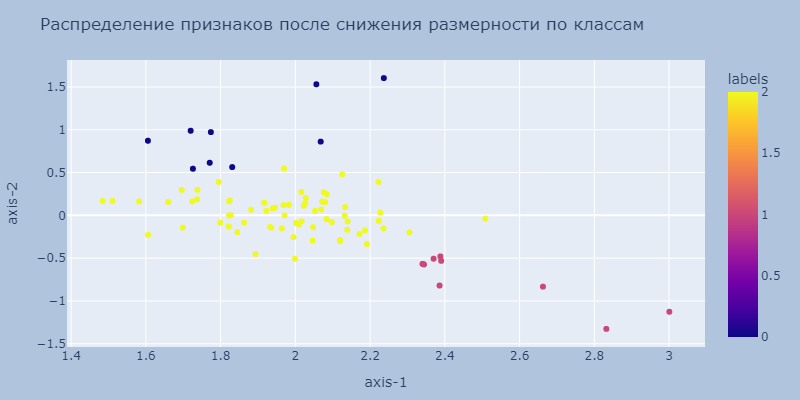

None


In [556]:
df_2024, data2024_group = add_labels(dict_result['df_2024'])

In [557]:
# приводим номера кластеров к единому порядку
df_2024.labels.replace({2:1, 1:2}, inplace=True)
data2024_group.labels.replace({2:1, 1:2}, inplace=True)
data2024_group.set_index('labels', inplace=True)

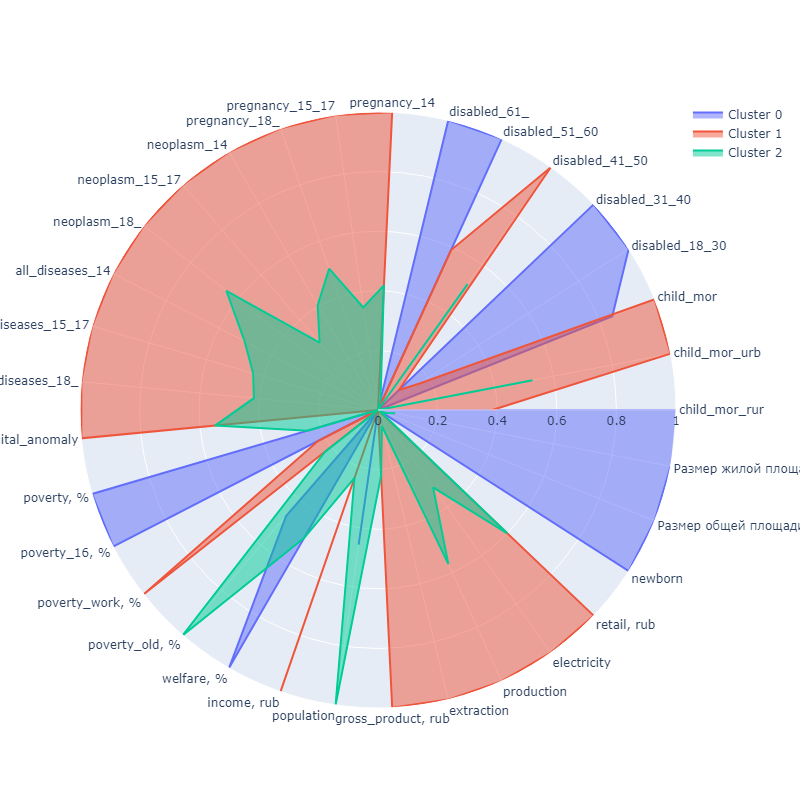

In [558]:
# полярная диаграмма
plot_cluster_profile(data2024_group, 3)

In [559]:
# стандартизация
col = data2024_group.columns
MM = preprocessing.MinMaxScaler()
data2024_scaled = data2024_group.copy()
data2024_scaled = pd.DataFrame(MM.fit_transform(data2024_scaled), columns=col)

In [560]:
data2024_group.T

labels                                                         0   
child_mor_rur                                       2.101697e+02  \
child_mor_urb                                       1.906612e+02   
child_mor                                           4.008310e+02   
disabled_18_30                                      2.517863e+01   
disabled_31_40                                      2.470520e+01   
disabled_41_50                                      3.085317e+00   
disabled_51_60                                     -4.588816e+01   
disabled_61_                                        3.840151e+01   
pregnancy_14                                        7.388889e+00   
pregnancy_15_17                                     3.464667e+02   
pregnancy_18_                                       5.602067e+03   
neoplasm_14                                         1.914778e+02   
neoplasm_15_17                                      2.007000e+02   
neoplasm_18_                                        7.416222e+02   
all_diseases_14                                     1.060281e+05   
all_diseases_15_17                                  9.623571e+04   
all_diseases_18_                                    4.397968e+04   
congenital_anomaly                                  7.874556e+02   
poverty, %                                          2.241111e+01   
poverty_16, %                                       3.998889e+01   
poverty_work, %                                     5.414000e+01   
poverty_old, %                                      5.857778e+00   
welfare, %                                          2.804444e+01   
income, rub                                         2.244056e+04   
population                                          1.421241e+06   
gross_product, rub                                  2.464722e+05   
extraction                                          1.430417e+01   
production                                          4.746099e+01   
electricity                                         1.756610e+01   
retail, rub                                         2.321348e+05   
newborn                                             1.384699e+03   
Размер общей площади в расчете на члена домохоз...  2.652222e+01   
Размер жилой площади в расчете на члена домохоз...  1.950000e+01   

labels                                                         2             1  
child_mor_rur                                       1.291851e+02  7.883391e+01  
child_mor_urb                                       2.862582e+02  2.411388e+02  
child_mor                                           4.154432e+02  3.199727e+02  
disabled_18_30                                      3.566042e+00 -6.491790e-01  
disabled_31_40                                     -4.931245e+00 -8.116898e+00  
disabled_41_50                                      1.364439e+01  8.558915e+00  
disabled_51_60                                     -5.574979e+01 -6.994683e+01  
disabled_61_                                       -1.876195e+02 -1.794001e+02  
pregnancy_14                                        4.706667e+01  2.401045e+01  
pregnancy_15_17                                     1.764700e+03  8.394493e+02  
pregnancy_18_                                       9.712011e+03  7.664528e+03  
neoplasm_14                                         8.523333e+02  4.591657e+02  
neoplasm_15_17                                      1.014667e+03  4.441194e+02  
neoplasm_18_                                        1.637244e+03  1.321321e+03  
all_diseases_14                                     2.616699e+05  1.844158e+05  
all_diseases_15_17                                  1.950949e+05  1.394128e+05  
all_diseases_18_                                    6.872038e+04  5.432971e+04  
congenital_anomaly                                  2.202400e+03  1.564746e+03  
poverty, %                                          1.004444e+01  1.308358e+01  
poverty_16, %                                       3.883815e+01  3

In [561]:
# столбцы неверные, потому что они по индексам(1 и 2 поменять местами)
data2024_scaled.T

0         1   
child_mor_rur                                       1.000000  0.383377  \
child_mor_urb                                       0.000000  1.000000   
child_mor                                           0.846945  1.000000   
disabled_18_30                                      1.000000  0.163205   
disabled_31_40                                      1.000000  0.097058   
disabled_41_50                                      0.000000  1.000000   
disabled_51_60                                      1.000000  0.590101   
disabled_61_                                        1.000000  0.000000   
pregnancy_14                                        0.000000  1.000000   
pregnancy_15_17                                     0.000000  1.000000   
pregnancy_18_                                       0.000000  1.000000   
neoplasm_14                                         0.000000  1.000000   
neoplasm_15_17                                      0.000000  1.000000   
neoplasm_18_                                        0.000000  1.000000   
all_diseases_14                                     0.000000  1.000000   
all_diseases_15_17                                  0.000000  1.000000   
all_diseases_18_                                    0.000000  1.000000   
congenital_anomaly                                  0.000000  1.000000   
poverty, %                                          1.000000  0.000000   
poverty_16, %                                       1.000000  0.225665   
poverty_work, %                                     0.000000  1.000000   
poverty_old, %                                      0.471016  0.000000   
welfare, %                                          1.000000  0.000000   
income, rub                                         0.000000  1.000000   
population                                          0.456189  0.000000   
gross_product, rub                                  0.000000  1.000000   
extraction                                          0.000000  1.000000   
production                                          0.000000  1.000000   
electricity                                         0.000000  1.000000   
retail, rub                                         0.000000  1.000000   
newborn                                             1.000000  0.000000   
Размер общей площади в расчете на члена домохоз...  1.000000  0.000000   
Размер жилой площади в расчете на члена домохоз...  1.000000  0.000000   

                                                           2  
child_mor_rur                                       0.000000  
child_mor_urb                                       0.528025  
child_mor                                           0.000000  
disabled_18_30                                      0.000000  
disabled_31_40                                      0.000000  
disabled_41_50                                      0.518379  
disabled_51_60                                      0.000000  
disabled_61_                                        0.036365  
pregnancy_14                                        0.418914  
pregnancy_15_17                                     0.347603  
pregnancy_18_                                       0.501822  
neoplasm_14                                         0.405063  
neoplasm_15_17                                      0.299053  
neoplasm_18_                                        0.647258  
all_diseases_14                                     0.503642  
all_diseases_15_17                                  0.436753  
all_diseases_18_                                    0.418340  
congenital_anomaly                                  0.549344  
poverty, %                                          0.245752  
poverty_16, %                                       0.000000  
poverty_work, %                                     0.225875  
poverty_old, %                                      1.000000  
welfare, %                                          0.496448  
income, rub                   

Можно было бы рассмотреть 2023 год отдельно, но особого смысла в этом нет, потому что большинство таблиц заканчивались на 2020, 2021 или 2022(если повезёт) и 2023 тоже по большей части является синтетическим.

Кластер 0

Республика Крым, Республика Дагестан, Республика Ингушетия, Кабардино-Балкарская Республика, Карачаево-Черкесская Республика, Чеченская Республика, Ставропольский край, Республика Тыва, Республика Бурятия

Малая заболеваемость и количество беременностей, плохая динамика по людям с инвалидностью, почему-то из общей картины выбивается возрастная категория 41-50 в ней самый маленький уровень прибавления людей с инвалидностью, низкие доходы и уровень производства, большое количество новорожденных и высокий уровень бедности.

Кластер 1

Низкий уровень детской смертности, маленькое количество новорождённых, наилучшая динамика среди людей с инвалидностью(более хорошая медицина?); низкий уровень бедности; наибольшая численность населения; более ничем не примечательный кластер

Кластер 2

Республика Карелия, Республика Коми, Архангельская область, Ненецкий автономный округ, Мурманская область, Город Санкт-Петербург, Ямало-Ненецкий автономный округ, Сахалинская область, Чукотский автономный округ

Высокий уровень детской смертности, особенно в городах; наибольшее количество зарегистрированных беременностей среди несовершеннолетних, также и у совершеннолетних, но разница в показателях существенно меньше; наибольший уровень заболеваемости(в том числе новообразования и хромосомные аномалии); низкий уровень бедности; высокие уровни доходов, производства, оборота розничной торговли. Чаще всего в этом кластере северные регионы.

# Вывод

Продублирую описание кластеров от 2024 года.
***
* ***Кластер 0***

*Республика Крым, Республика Дагестан, Республика Ингушетия, Кабардино-Балкарская Республика, Карачаево-Черкесская Республика, Чеченская Республика, Ставропольский край, Республика Тыва, Республика Бурятия*

Малая заболеваемость и количество беременностей, плохая динамика по людям с инвалидностью, почему-то из общей картины выбивается возрастная категория 41-50 в ней самый маленький уровень прибавления людей с инвалидностью, низкие доходы и уровень производства, большое количество новорожденных и высокий уровень бедности.

* ***Кластер 1***

Низкий уровень детской смертности, маленькое количество новорождённых, наилучшая динамика среди людей с инвалидностью(более хорошая медицина?); низкий уровень бедности; наибольшая численность населения; более ничем не примечательный кластер

* ***Кластер 2***

*Республика Карелия, Республика Коми, Архангельская область, Ненецкий автономный округ, Мурманская область, Город Санкт-Петербург, Ямало-Ненецкий автономный округ, Сахалинская область, Чукотский автономный округ*

Высокий уровень детской смертности, особенно в городах; наибольшее количество зарегистрированных беременностей среди несовершеннолетних, также и у совершеннолетних, но разница в показателях существенно меньше; наибольший уровень заболеваемости(в том числе новообразования и хромосомные аномалии); низкий уровень бедности; высокие уровни доходов, производства, оборота розничной торговли. Чаще всего в этом кластере северные регионы.
***
Очевидно кластер 0 остро нуждается в помощи малообеспеченным и неблагополучным слоям населения, но из года в год расходы на социальную политику в этом кластере самые большие, регионы качуют из года в год одни и те же, может это неэффективно... На графиках как регионы нуждающиеся в помощи буду указывать регионы кластера 0.

Группы населения сталкивающиеся с бедностью:

Думаю малая заболеваемость может быть следствием того что люди не обращаются в амбулатории, косвенно это подтверждает растущий уровень людей с инвалидностью в этом кластере, возможно люди доводят свои заболевания до крайности, а потом только обращаются к врачу, тем самым шансы на выздоровление стремятся к 0; низкие доходы; большинство бедных среди детей и людей трудоспособного возраста, среди пенсионеров их мало; валовой региональный продукт и оборот розничной торговли самые низкие и с большим отрывом, такая же ситуация обстоит и с добычей полезных ископаемых, обрабатывающими производствами и обеспечением электрической энергией(также газом и паром). Самое большое количество новорождённых при самом низком количестве зарегистрированных беременностей...видимо в случае беременности к врачу тоже не обращаются. Возможно низкий контакт с врачами обусловлен большим количеством сельской местности.

Большое количество детей и пенсионеров не влияет на уровень бедности в регионе - количество детей-трудоспособных-пенсионеров примерно в соотношении 40-55-5 за все годы и по всем кластерам.

Уровень бедности прямым образом связан с производством и потреблением в регионе - в кластере 2 эти показатели на высоте, в то же время уровень бедности самый низкий, в кластере 0 ситуация обратная уровень бедности на высоте, тогда как производство и потребление стабильно низкие.

# 3. Подготовка к продакшену

## 1. Построение карты России с регионами

Использована работа Алёшина Максима, он сделал интерактивную карту России с разделением по регионам. Вот ссылка на его работу: https://github.com/hairymax/offline_russia_plotly . Я изменила под свои нужды.

In [562]:
gdf = gpd.read_file("data/russia_regions.geojson")
gdf.info()            
gdf.sample(4)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   region            85 non-null     object  
 1   federal_district  85 non-null     object  
 2   population        85 non-null     int32   
 3   geometry          85 non-null     geometry
dtypes: geometry(1), int32(1), object(2)
memory usage: 2.5+ KB


region federal_district  population   
55  Республика Татарстан      Приволжский     4001625  \
70  Свердловская область        Уральский     4239161   
26           Севастополь         Крымский      558273   
25      Липецкая область      Центральный     1126263   

                                             geometry  
55  MULTIPOLYGON (((47.23702 54.8468, 47.2372 54.8...  
70  MULTIPOLYGON (((57.22938 56.856, 57.25442 56.8...  
26  MULTIPOLYGON (((33.83026 44.55701, 33.83024 44...  
25  MULTIPOLYGON (((37.72172 52.60002, 37.72206 52...

In [563]:
# выбор системы отсчёта координат
gdf = gdf.to_crs('EPSG:32646')

In [564]:
# проверка названий регонов
print(region_name(gdf.region))

['Республика Саха (Якутия)', 'Ханты-Мансийский автономный округ — Югра', 'Санкт-Петербург', 'Москва', 'Севастополь', 'Республика Северная Осетия — Алания']


In [565]:
# преобразуем в правильные на данный момент данные
dict_name = {'Москва':'Город Москва',
            'Санкт-Петербург':'Город Санкт-Петербург',
            'Севастополь':'Город Севастополь',
            'Республика Саха (Якутия)':'Республика Саха',
            'Республика Северная Осетия — Алания':'Республика Северная Осетия',
            'Ханты-Мансийский автономный округ — Югра':'Ханты-Мансийский автономный округ'
}
gdf.region.replace(dict_name, inplace=True)

# проверка названий регонов
region_name(set(gdf.region))

[]

In [566]:
# добавление кластеров за разные годы
#2017
gdf_year = gdf.merge(df_2017.labels, left_on='region', right_index=True)
gdf_year = gdf_year.rename(columns={'labels':'labels2017'})
#2018
gdf_year = gdf_year.merge(df_2018.labels, left_on='region', right_index=True)
gdf_year = gdf_year.rename(columns={'labels':'labels2018'})
#2019
gdf_year = gdf_year.merge(df_2019.labels, left_on='region', right_index=True)
gdf_year = gdf_year.rename(columns={'labels':'labels2019'})
#2020
gdf_year = gdf_year.merge(df_2020.labels, left_on='region', right_index=True)
gdf_year = gdf_year.rename(columns={'labels':'labels2020'})
#2021
gdf_year = gdf_year.merge(df_2021.labels, left_on='region', right_index=True)
gdf_year = gdf_year.rename(columns={'labels':'labels2021'})
#2022
gdf_year = gdf_year.merge(df_2022.labels, left_on='region', right_index=True)
gdf_year = gdf_year.rename(columns={'labels':'labels2022'})
#2023
gdf_year = gdf_year.merge(df_2023.labels, left_on='region', right_index=True)
gdf_year = gdf_year.rename(columns={'labels':'labels2023'})
#2024
gdf_year = gdf_year.merge(df_2024.labels, left_on='region', right_index=True)
gdf_year = gdf_year.rename(columns={'labels':'labels2024'})

В датасете раздроблен Чукотский автономный округ по причине пересечения со 180 меридианом. Для его объединения нужен пробег по циклу по всем парам полигонов и объединю их с допуском в 100 единиц с помощью команды .snap(). Далее построение геометрии до и после преобразования.

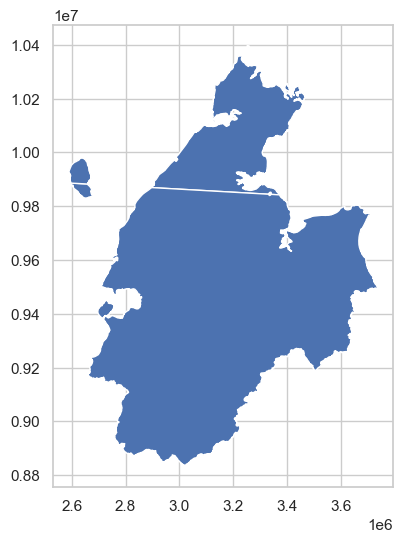

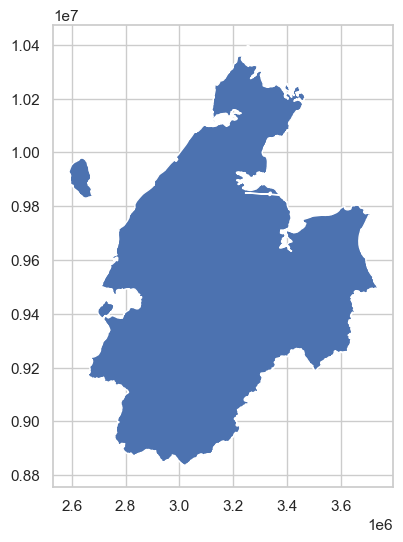

In [567]:
CHUK = 'Чукотский автономный округ'

gdf_year.loc[gdf_year.region == CHUK].plot(figsize=(6,6), color='b')
plt.show()

# Объединение разбитых полигонов Чукотки
new_chuk = []
chuk_geoms = gdf_year.loc[gdf_year.region == CHUK, 'geometry'].values[0].geoms

# приклеим друг к другу полигоны находящиеся на расстоянии менее 100 единиц
for i, g in enumerate(chuk_geoms):
    new_g = g
    for j in range(len(chuk_geoms)):
        new_g = snap(new_g, chuk_geoms[j], 100)
    new_chuk.append(new_g)
new_chuk = unary_union(MultiPolygon(new_chuk))
gdf_year.loc[gdf_year.region == CHUK, 'geometry'] = new_chuk

gdf_year.loc[gdf_year.region == CHUK].plot(figsize=(6,6), color='b')
plt.show();

Упрощение геометрии

Одна из основных проблем построения интерактивных карт – размерность геометрии. Чем «детальней» объекты, тем дольше будет идти прорисовка.

Основным инструментом оптимизации будет выступать специальный метод .simplify(), который позволяет уменьшить количество точек. Он принимает на вход параметр tolerance, все точки упрощённой геометрии будут находиться на расстоянии не более этого допуска. Рассмотрю уменьшение на примере Калининградской области. Упрощу геометрию региона до расстояния между соседними точками в 500 единиц.

Точек 3740


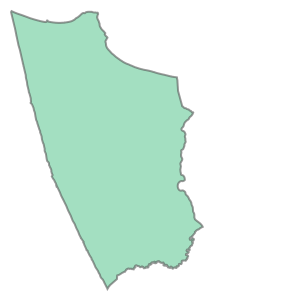

Точек 123


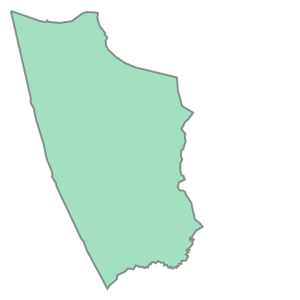

In [568]:
i = 61 # Калининградская область
tol = 500
print(f"Точек {shapely.get_num_coordinates(gdf_year.geometry[i])}") 
display(gdf_year.geometry[i])
print(f'Точек {shapely.get_num_coordinates(gdf_year.geometry[i].simplify(tol))}') 
display(gdf_year.geometry[i].simplify(tol))

In [569]:
#  функция упрощения геометрии всех регионов, используется модуль tqdm для отслеживания прогресса выполнения
def prepare_regions(gdf, area_thr=100e6, simplify_tol=500):
    """Подготовка регионов к построению
    
    - Упрощение геометрии с допуском simplify_tol
    - Удаление полигонов с площадью менее area_thr
    """
    gdf_ = gdf.copy()
    
    # Вспомогательный столбец для упорядочивания регионов по площади
    gdf_['area'] = gdf_.geometry.apply(lambda x: x.area)

    # Удаляем маленькие полигоны
    tqdm.pandas(desc='Удаление мелких полигонов')
    gdf_.geometry = gdf_.geometry.progress_apply(lambda geometry: 
        MultiPolygon([p for p in geometry.geoms if p.area > area_thr]) 
            if type(geometry) == MultiPolygon else geometry
    )
    
    # Упрощение геометрии
    gdf_.geometry = gdf_.geometry.simplify(simplify_tol)
    
    geoms = gdf_.geometry.values
    pbar = tqdm(enumerate(geoms), total=len(geoms))
    pbar.set_description_str('Объединение границ после упрощения')
    # проходим по всем граничащим полигонам и объединяем границы
    for i, g in pbar:
        g1 = g
        for g2 in geoms:
            if g1.distance(g2) < 100:
                g1 = snap(g1, g2, 800)
        geoms[i] = g1
    gdf_.geometry = geoms
    
    # сортировка по площади
    gdf_ = gdf_.sort_values(by='area', ascending=False).reset_index(drop=True) 
    
    return gdf_.drop(columns=['area'])

Финальная обработка геометрии

Последнее, что необходимо сделать — преобразовать полигоны и мультиполигоны шэйпы, которые способна считывать для построения Plotly. Графические объекты поддерживают рисование GeoJSON объектов только на упомянутых слоях типа go.layout.Geo. Будет использоваться класс go.Scatter, а значит, необходимо перевести геометрии в формат отдельных массивов координат x и y. Для этого реализована функция‑преобразование geom2shape.

In [570]:
def geom2shape(g):
    """Преобразование полигонов и мультиполигонов в plotly-readable шэйпы    
    
    Получает на вход Polygon или MultiPolygon из geopandas, 
    возвращает pd.Series с координатами x и y
    """
    # Если мультиполигон, то преобразуем каждый полигон отдельно, разделяя их None'ами
    if type(g) == MultiPolygon:
        x, y = np.array([[], []])
        for poly in g.geoms:
            x_, y_ = poly.exterior.coords.xy
            x, y = (np.append(x, x_), np.append(y, y_))
            x, y = (np.append(x, None), np.append(y, None))
        x, y = x[:-1], y[:-1]
    # Если полигон, то просто извлекаем координаты
    elif type(g) == Polygon:      
        x, y = np.array(g.exterior.coords.xy)
    # Если что-то другое, то возвращаем пустые массивы
    else:
        x, y = np.array([[], []])
    return pd.Series([x,y])

In [571]:
# Упрощение геометрии   
regions = prepare_regions(gdf_year)
# Преобразование полигонов в шейпы   
regions[['x','y']] = regions.geometry.progress_apply(geom2shape)
# Запись на диск   
regions.to_parquet('data/russia_regions.parquet')

Удаление мелких полигонов:  88%|████████▊ | 75/85 [00:00<00:00, 735.36it/s]

Удаление мелких полигонов: 100%|██████████| 85/85 [00:00<00:00, 988.42it/s]


Слой-подложка карты

Всё готово, чтобы создать слой‑подложку для карты. Построение будет проводиться с помощью собственного класса mapFigure, который наследуется от класса фигуры Plotly — go.Figure. Для этого импортирую подмодуль plotly.graph_objects, который содержит основные классы для построения фигур. В листинге ниже приведён код модуля map_figure.py. Помимо класса mapFigure в нём реализована функция convert_crs для преобразования координат в двух массивах x_arr, y_arr из одной системы отсчёта в другую. Она пригодится для подготовки данных к отображению на карте. Замечу, что у go.Figure разработчики отключили возможность добавления новых атрибутов и методов. Но здесь можно обойтись переопределением метода инициализации, а дальше работать с картой, как с обычным go.Figure.

In [572]:
'''Класс для слоя подложки карты России'''

REGIONS = pd.read_parquet("data/russia_regions.parquet")

def convert_crs(x_arr, y_arr, to_crs='EPSG:32646', from_crs="EPSG:4326"):
    """Преобразование значений координат в массивах x_arr и y_arr
    из географической системы отсчёта from_crs в систему to_crs
    """
    data = [Point(x,y) for x,y in zip(x_arr, y_arr)]
    pts = gpd.GeoSeries(data, from_crs).to_crs(to_crs)
    
    return pts.x, pts.y

class mapFigure(go.Figure):
    """ Шаблон фигуры для рисования поверх карты России
    """
    def __init__(self, # дефолтные параметры plotly
        data=None, layout=None, frames=None, skip_invalid=False, 
        **kwargs # аргументы (см. документацию к plotly.graph_objects.Figure())
    ):
        # создаём plotlу фигуру с дефолтными параметрами
        super().__init__(data, layout, frames, skip_invalid, **kwargs)

        # прорисовка регионов
        for i, r in REGIONS.iterrows():
            self.add_trace(go.Scatter(x=r.x, y=r.y,
                                      name=r.region,
                                      text=r.region,
                                      hoverinfo="text",
                                      line_color='grey',
                                      fill='toself',
                                      line_width=1,
                                      fillcolor='lightblue',
                                      showlegend=False
            ))
        
        # не отображать оси, уравнять масштаб по осям
        self.update_xaxes(visible=False)
        self.update_yaxes(visible=False, scaleanchor="x", scaleratio=1)

        # чтобы покрасивее вписывалась карта на поверхности фигуры
        self.update_layout(showlegend=False, dragmode='pan',
                           width=800, height=450, 
                           margin={'l': 10, 'b': 10, 't': 10, 'r': 10})

Параметры построения
* x,y — подготовленные ранее шэйпы для построения;

* name — название объекта;

* text — информация, отображаемая при наведении на объект;

* hoverinfo ‑ определяет, какая информация будет отображаться при наведении. В моём случае будет отображаться информация, прописанная в параметре text;

* line_color, line_width — цвет и ширина границ;

* fill — определяет, как именно объекты будут заполнятся цветом; в режиме «toself» регионы окрашиваются полностью до своих границ;

* fillcolor — устанавливает цвета заливки;

* showlegend — определяет, показывать ли легенду.

In [573]:
russia_map = mapFigure()
russia_map.show()

## Построение графиков за каждый год

In [574]:
regions = pd.read_parquet("data/russia_regions.parquet")
fo_list = [0, 1, 2] # список кластеров
colors = px.colors.qualitative.Pastel1

На гитхабе карта не интерактивна, потому что гитхаб не поддерживает отображение графиков библиотеки plotly.На сайте будет html с интерактивностью.

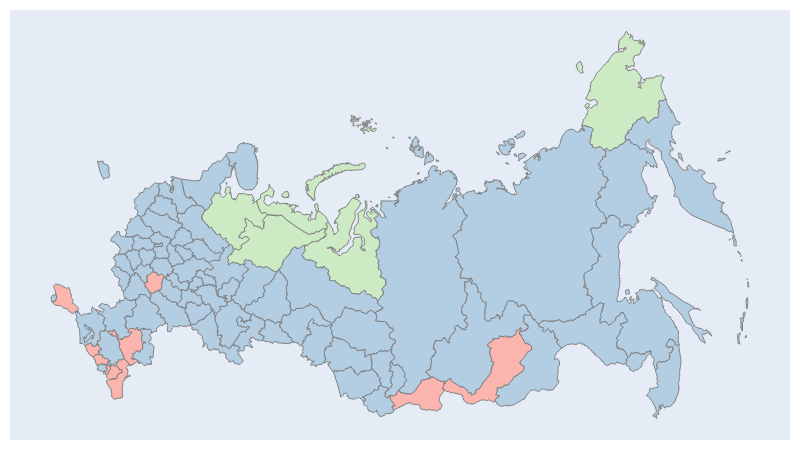

In [575]:
#2017
for i, r in regions.iterrows():
    popul_text = f"Кластер: <b>{r.labels2017:} </b>"
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.labels2017)])
russia_map.show('png')
#russia_map.write_html("plotly/2017.html")

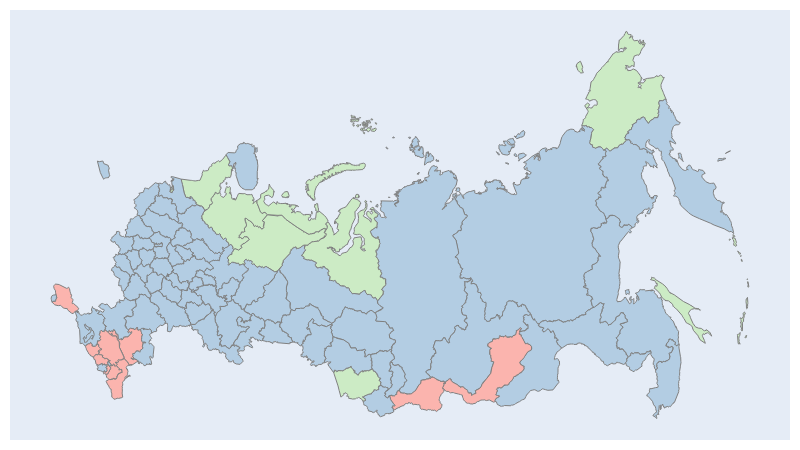

In [576]:
#2018
for i, r in regions.iterrows():
    popul_text = f"Кластер: <b>{r.labels2018:} </b>"
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.labels2018)])
russia_map.show('png')
#russia_map.write_html("plotly/2018.html")

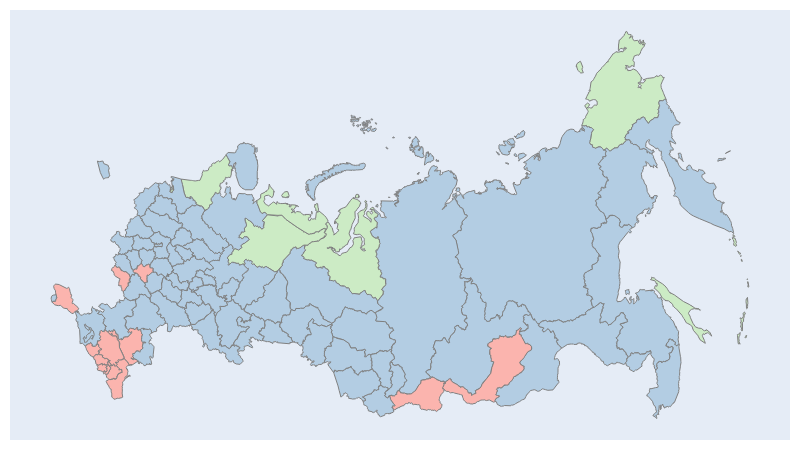

In [577]:
#2019
for i, r in regions.iterrows():
    popul_text = f"Кластер: <b>{r.labels2019:} </b>"
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.labels2019)])
russia_map.show('png')
#russia_map.write_html("plotly/2019.html")

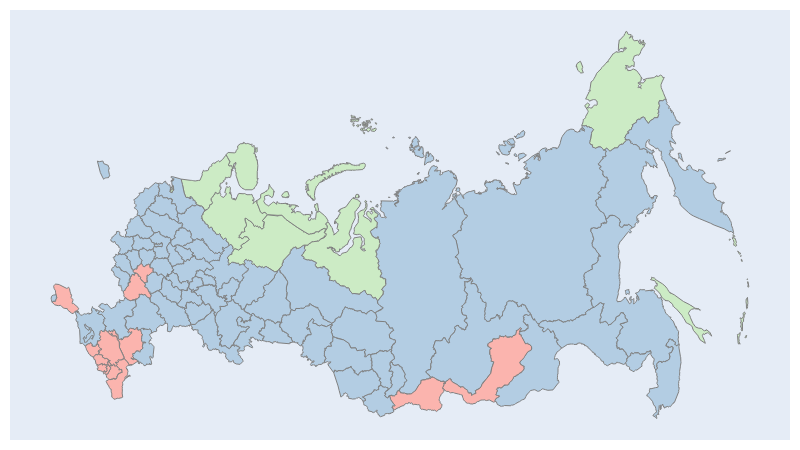

In [578]:
#2020
for i, r in regions.iterrows():
    popul_text = f"Кластер: <b>{r.labels2020:} </b>"
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.labels2020)])
russia_map.show('png')
#russia_map.write_html("plotly/2020.html")

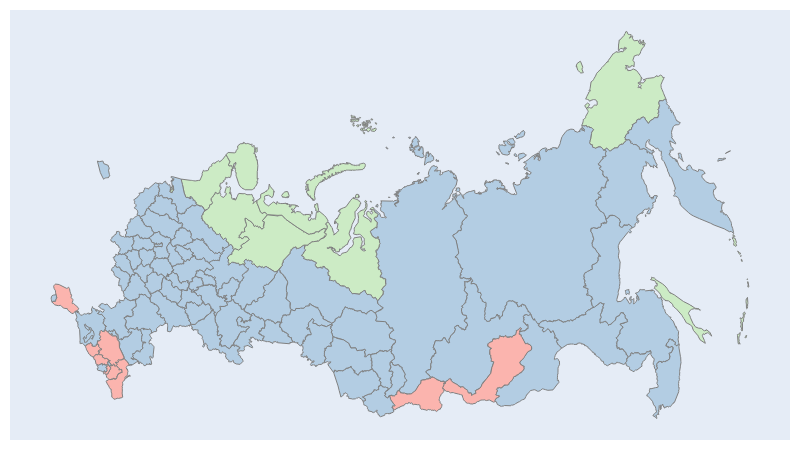

In [579]:
#2021
for i, r in regions.iterrows():
    popul_text = f"Кластер: <b>{r.labels2021:} </b>"
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.labels2021)])
russia_map.show('png')
#russia_map.write_html("plotly/2021.html")

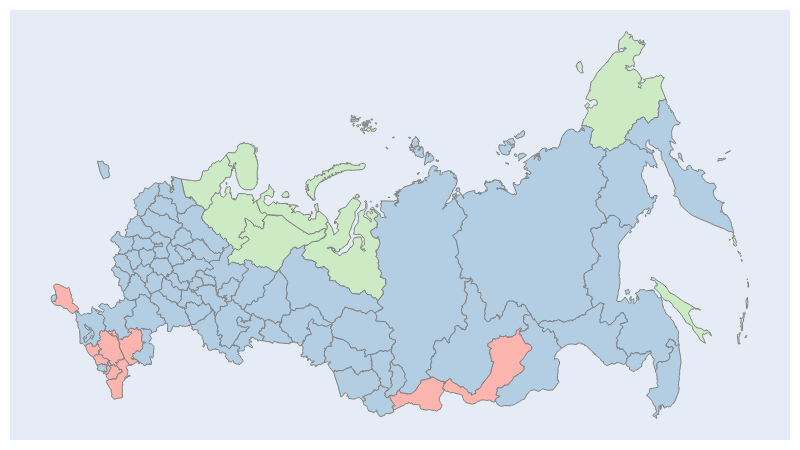

In [580]:
#2022
for i, r in regions.iterrows():
    popul_text = f"Кластер: <b>{r.labels2022:} </b>"
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.labels2022)])
russia_map.show('png')
#russia_map.write_html("plotly/2022.html")

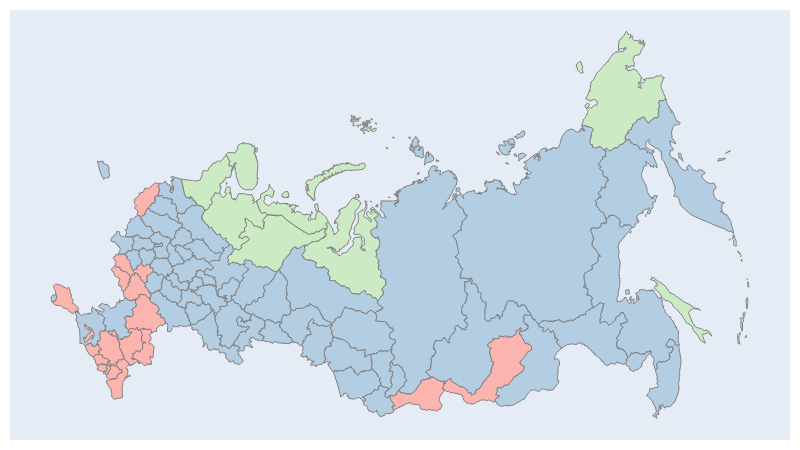

In [581]:
#2023
for i, r in regions.iterrows():
    popul_text = f"Кластер: <b>{r.labels2023:} </b>"
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.labels2023)])
russia_map.show('png')
#russia_map.write_html("plotly/2023.html")

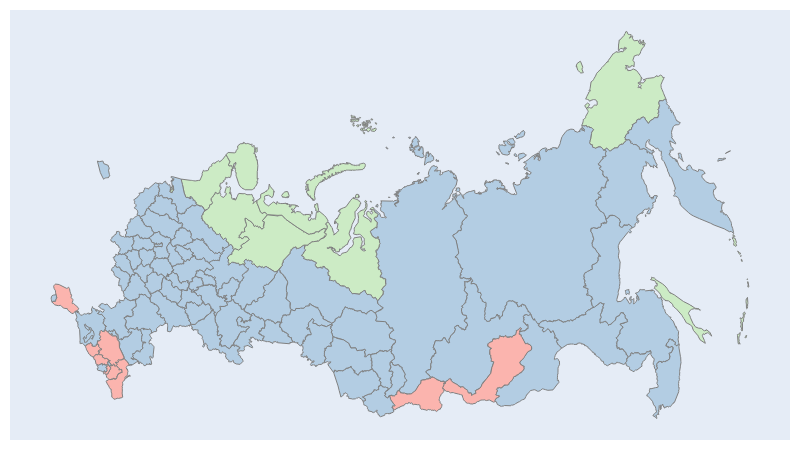

In [582]:
#2024
for i, r in regions.iterrows():
    popul_text = f"Кластер: <b>{r.labels2024:} </b>"
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.labels2024)])
russia_map.show('png')
#russia_map.write_html("plotly/2024.html")